In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.6858 eloss:1.8747 aloss2:1.5981 exploreP:0.9983
Episode:1 meanR:24.5000 R:32.0000 rate:0.0640 aloss:0.7062 eloss:1.9953 aloss2:1.5341 exploreP:0.9952
Episode:2 meanR:20.3333 R:12.0000 rate:0.0240 aloss:0.7105 eloss:2.0089 aloss2:1.5424 exploreP:0.9940
Episode:3 meanR:21.7500 R:26.0000 rate:0.0520 aloss:0.7066 eloss:1.9971 aloss2:1.5407 exploreP:0.9914
Episode:4 meanR:23.0000 R:28.0000 rate:0.0560 aloss:0.7072 eloss:2.0331 aloss2:1.5181 exploreP:0.9887
Episode:5 meanR:20.8333 R:10.0000 rate:0.0200 aloss:0.7071 eloss:1.8621 aloss2:1.6368 exploreP:0.9877
Episode:6 meanR:20.5714 R:19.0000 rate:0.0380 aloss:0.7050 eloss:1.9983 aloss2:1.5412 exploreP:0.9858
Episode:7 meanR:20.1250 R:17.0000 rate:0.0340 aloss:0.7054 eloss:2.0160 aloss2:1.5515 exploreP:0.9842
Episode:8 meanR:21.1111 R:29.0000 rate:0.0580 aloss:0.7061 eloss:2.0702 aloss2:1.5111 exploreP:0.9814
Episode:9 meanR:23.6000 R:46.0000 rate:0.0920 aloss:0.7041 eloss:1.9474 aloss2:1.5

Episode:80 meanR:26.2963 R:19.0000 rate:0.0380 aloss:0.6872 eloss:1.2917 aloss2:2.6454 exploreP:0.8101
Episode:81 meanR:26.2073 R:19.0000 rate:0.0380 aloss:0.7023 eloss:1.4170 aloss2:2.4912 exploreP:0.8086
Episode:82 meanR:26.2410 R:29.0000 rate:0.0580 aloss:0.6982 eloss:1.2204 aloss2:2.8072 exploreP:0.8062
Episode:83 meanR:26.3214 R:33.0000 rate:0.0660 aloss:0.6990 eloss:1.2179 aloss2:2.7436 exploreP:0.8036
Episode:84 meanR:26.5176 R:43.0000 rate:0.0860 aloss:0.7093 eloss:1.1566 aloss2:2.8119 exploreP:0.8002
Episode:85 meanR:26.5814 R:32.0000 rate:0.0640 aloss:0.7215 eloss:1.2055 aloss2:2.7192 exploreP:0.7977
Episode:86 meanR:26.4598 R:16.0000 rate:0.0320 aloss:0.7227 eloss:1.2145 aloss2:2.6951 exploreP:0.7964
Episode:87 meanR:26.5455 R:34.0000 rate:0.0680 aloss:0.7118 eloss:1.0365 aloss2:2.8857 exploreP:0.7938
Episode:88 meanR:26.6180 R:33.0000 rate:0.0660 aloss:0.7034 eloss:0.9754 aloss2:2.9667 exploreP:0.7912
Episode:89 meanR:26.6556 R:30.0000 rate:0.0600 aloss:0.7027 eloss:0.8616 

Episode:159 meanR:40.2300 R:41.0000 rate:0.0820 aloss:0.7336 eloss:-1.3703 aloss2:8.5348 exploreP:0.5815
Episode:160 meanR:40.2900 R:24.0000 rate:0.0480 aloss:0.7198 eloss:-1.9035 aloss2:9.2352 exploreP:0.5801
Episode:161 meanR:40.7700 R:80.0000 rate:0.1600 aloss:0.7087 eloss:-1.9268 aloss2:9.3213 exploreP:0.5756
Episode:162 meanR:40.1800 R:19.0000 rate:0.0380 aloss:0.6941 eloss:-2.0757 aloss2:9.5400 exploreP:0.5745
Episode:163 meanR:40.5300 R:58.0000 rate:0.1160 aloss:0.7206 eloss:-1.9600 aloss2:9.4734 exploreP:0.5712
Episode:164 meanR:40.8500 R:54.0000 rate:0.1080 aloss:0.7135 eloss:-2.0095 aloss2:9.7267 exploreP:0.5682
Episode:165 meanR:40.8000 R:27.0000 rate:0.0540 aloss:0.7208 eloss:-2.0821 aloss2:9.8679 exploreP:0.5667
Episode:166 meanR:41.2700 R:61.0000 rate:0.1220 aloss:0.7208 eloss:-2.1419 aloss2:9.9759 exploreP:0.5633
Episode:167 meanR:42.1300 R:103.0000 rate:0.2060 aloss:0.7178 eloss:-2.1364 aloss2:10.0862 exploreP:0.5576
Episode:168 meanR:43.0900 R:130.0000 rate:0.2600 alos

Episode:236 meanR:145.7200 R:500.0000 rate:1.0000 aloss:0.7670 eloss:-6.8335 aloss2:43.1180 exploreP:0.1602
Episode:237 meanR:149.6000 R:500.0000 rate:1.0000 aloss:0.7807 eloss:-6.1514 aloss2:42.9026 exploreP:0.1529
Episode:238 meanR:154.1900 R:500.0000 rate:1.0000 aloss:0.7809 eloss:-6.4300 aloss2:43.1097 exploreP:0.1459
Episode:239 meanR:158.8800 R:500.0000 rate:1.0000 aloss:0.7701 eloss:-7.1971 aloss2:43.2171 exploreP:0.1393
Episode:240 meanR:163.7300 R:500.0000 rate:1.0000 aloss:0.7665 eloss:-5.9778 aloss2:43.8153 exploreP:0.1330
Episode:241 meanR:167.6500 R:500.0000 rate:1.0000 aloss:0.7511 eloss:-6.5984 aloss2:43.5945 exploreP:0.1270
Episode:242 meanR:172.3600 R:500.0000 rate:1.0000 aloss:0.7537 eloss:-6.4228 aloss2:43.4540 exploreP:0.1213
Episode:243 meanR:175.8600 R:500.0000 rate:1.0000 aloss:0.7433 eloss:-7.1980 aloss2:43.7986 exploreP:0.1159
Episode:244 meanR:180.5700 R:500.0000 rate:1.0000 aloss:0.7482 eloss:-6.0894 aloss2:44.1547 exploreP:0.1107
Episode:245 meanR:185.0300 R

Episode:312 meanR:358.0300 R:177.0000 rate:0.3540 aloss:0.6647 eloss:-2.3066 aloss2:47.7837 exploreP:0.0195
Episode:313 meanR:361.2300 R:384.0000 rate:0.7680 aloss:0.6602 eloss:-5.4654 aloss2:47.2401 exploreP:0.0192
Episode:314 meanR:360.1800 R:184.0000 rate:0.3680 aloss:0.7009 eloss:-5.4000 aloss2:47.3851 exploreP:0.0190
Episode:315 meanR:364.0300 R:500.0000 rate:1.0000 aloss:0.6802 eloss:-5.7582 aloss2:47.7764 exploreP:0.0186
Episode:316 meanR:365.3600 R:168.0000 rate:0.3360 aloss:0.6632 eloss:-5.8003 aloss2:48.0023 exploreP:0.0184
Episode:317 meanR:369.4600 R:500.0000 rate:1.0000 aloss:0.6841 eloss:-5.2076 aloss2:46.8431 exploreP:0.0180
Episode:318 meanR:371.9600 R:500.0000 rate:1.0000 aloss:0.6505 eloss:-5.2283 aloss2:47.1085 exploreP:0.0176
Episode:319 meanR:372.1900 R:500.0000 rate:1.0000 aloss:0.6765 eloss:-5.9606 aloss2:48.0837 exploreP:0.0172
Episode:320 meanR:374.8100 R:471.0000 rate:0.9420 aloss:0.6856 eloss:-5.5114 aloss2:48.8672 exploreP:0.0169
Episode:321 meanR:375.3000 R

Episode:388 meanR:216.2600 R:40.0000 rate:0.0800 aloss:0.6012 eloss:-5.6867 aloss2:47.7185 exploreP:0.0120
Episode:389 meanR:216.1200 R:42.0000 rate:0.0840 aloss:0.5664 eloss:-4.8044 aloss2:48.1318 exploreP:0.0120
Episode:390 meanR:217.2400 R:162.0000 rate:0.3240 aloss:0.5615 eloss:-2.7296 aloss2:48.9049 exploreP:0.0119
Episode:391 meanR:214.5300 R:152.0000 rate:0.3040 aloss:0.5433 eloss:-5.3524 aloss2:47.6511 exploreP:0.0119
Episode:392 meanR:215.3300 R:126.0000 rate:0.2520 aloss:0.5442 eloss:-5.0489 aloss2:45.8641 exploreP:0.0119
Episode:393 meanR:213.2700 R:165.0000 rate:0.3300 aloss:0.5474 eloss:-4.1752 aloss2:46.1973 exploreP:0.0118
Episode:394 meanR:212.3400 R:150.0000 rate:0.3000 aloss:0.5555 eloss:-3.5811 aloss2:46.4719 exploreP:0.0118
Episode:395 meanR:210.2700 R:169.0000 rate:0.3380 aloss:0.5673 eloss:-5.5271 aloss2:47.9233 exploreP:0.0118
Episode:396 meanR:209.2100 R:171.0000 rate:0.3420 aloss:0.5515 eloss:-4.0412 aloss2:47.7960 exploreP:0.0118
Episode:397 meanR:208.2900 R:1

Episode:464 meanR:149.0100 R:147.0000 rate:0.2940 aloss:0.4919 eloss:-4.3973 aloss2:51.2265 exploreP:0.0107
Episode:465 meanR:148.5900 R:118.0000 rate:0.2360 aloss:0.5146 eloss:-0.2524 aloss2:54.7731 exploreP:0.0106
Episode:466 meanR:149.0700 R:189.0000 rate:0.3780 aloss:0.5234 eloss:-6.9440 aloss2:55.0827 exploreP:0.0106
Episode:467 meanR:148.9800 R:154.0000 rate:0.3080 aloss:0.5059 eloss:-4.4633 aloss2:52.5224 exploreP:0.0106
Episode:468 meanR:148.7400 R:154.0000 rate:0.3080 aloss:0.5167 eloss:-4.3088 aloss2:53.3139 exploreP:0.0106
Episode:469 meanR:148.2900 R:133.0000 rate:0.2660 aloss:0.5268 eloss:-3.7886 aloss2:52.7447 exploreP:0.0106
Episode:470 meanR:148.3400 R:161.0000 rate:0.3220 aloss:0.5010 eloss:-5.9034 aloss2:52.4240 exploreP:0.0106
Episode:471 meanR:148.3700 R:157.0000 rate:0.3140 aloss:0.4855 eloss:-5.1479 aloss2:52.0680 exploreP:0.0106
Episode:472 meanR:148.1700 R:168.0000 rate:0.3360 aloss:0.4910 eloss:-3.2165 aloss2:52.5330 exploreP:0.0106
Episode:473 meanR:148.2600 R

Episode:540 meanR:149.7900 R:43.0000 rate:0.0860 aloss:0.4346 eloss:-3.4358 aloss2:57.1765 exploreP:0.0102
Episode:541 meanR:149.6900 R:145.0000 rate:0.2900 aloss:0.4358 eloss:-6.8117 aloss2:58.1957 exploreP:0.0102
Episode:542 meanR:149.6700 R:154.0000 rate:0.3080 aloss:0.4874 eloss:-6.6054 aloss2:60.4386 exploreP:0.0102
Episode:543 meanR:149.2500 R:142.0000 rate:0.2840 aloss:0.4390 eloss:-7.4616 aloss2:59.8325 exploreP:0.0102
Episode:544 meanR:149.4900 R:194.0000 rate:0.3880 aloss:0.4408 eloss:-2.0305 aloss2:58.4090 exploreP:0.0102
Episode:545 meanR:149.6200 R:159.0000 rate:0.3180 aloss:0.4662 eloss:-4.2940 aloss2:59.6626 exploreP:0.0102
Episode:546 meanR:150.6600 R:144.0000 rate:0.2880 aloss:0.4562 eloss:-7.1270 aloss2:58.9177 exploreP:0.0102
Episode:547 meanR:150.2600 R:131.0000 rate:0.2620 aloss:0.4680 eloss:-2.2244 aloss2:61.8233 exploreP:0.0102
Episode:548 meanR:149.9700 R:145.0000 rate:0.2900 aloss:0.4509 eloss:-6.7295 aloss2:60.1244 exploreP:0.0102
Episode:549 meanR:151.3700 R:

Episode:616 meanR:171.1600 R:243.0000 rate:0.4860 aloss:0.3817 eloss:-6.3503 aloss2:71.7799 exploreP:0.0101
Episode:617 meanR:171.5100 R:214.0000 rate:0.4280 aloss:0.3760 eloss:-7.7716 aloss2:74.6486 exploreP:0.0101
Episode:618 meanR:172.0900 R:198.0000 rate:0.3960 aloss:0.3441 eloss:-9.7657 aloss2:74.1889 exploreP:0.0101
Episode:619 meanR:172.1700 R:169.0000 rate:0.3380 aloss:0.3673 eloss:-10.0529 aloss2:75.9561 exploreP:0.0100
Episode:620 meanR:172.2600 R:155.0000 rate:0.3100 aloss:0.3688 eloss:-6.9947 aloss2:73.7778 exploreP:0.0100
Episode:621 meanR:172.1300 R:187.0000 rate:0.3740 aloss:0.3896 eloss:-7.8957 aloss2:74.1911 exploreP:0.0100
Episode:622 meanR:172.3800 R:198.0000 rate:0.3960 aloss:0.3696 eloss:-8.3855 aloss2:75.1675 exploreP:0.0100
Episode:623 meanR:172.4100 R:157.0000 rate:0.3140 aloss:0.3900 eloss:-6.4333 aloss2:76.0545 exploreP:0.0100
Episode:624 meanR:172.6100 R:188.0000 rate:0.3760 aloss:0.3656 eloss:-10.6995 aloss2:77.2307 exploreP:0.0100
Episode:625 meanR:172.4200

Episode:692 meanR:279.7300 R:331.0000 rate:0.6620 aloss:0.2703 eloss:-14.2677 aloss2:141.2144 exploreP:0.0100
Episode:693 meanR:280.7700 R:280.0000 rate:0.5600 aloss:0.2695 eloss:-21.1210 aloss2:158.1136 exploreP:0.0100
Episode:694 meanR:280.9600 R:209.0000 rate:0.4180 aloss:0.2580 eloss:-21.6904 aloss2:156.4121 exploreP:0.0100
Episode:695 meanR:280.7400 R:158.0000 rate:0.3160 aloss:0.2445 eloss:-17.3475 aloss2:146.2220 exploreP:0.0100
Episode:696 meanR:282.3000 R:294.0000 rate:0.5880 aloss:0.2595 eloss:-16.2526 aloss2:145.2293 exploreP:0.0100
Episode:697 meanR:282.6100 R:194.0000 rate:0.3880 aloss:0.2738 eloss:-20.6082 aloss2:157.9183 exploreP:0.0100
Episode:698 meanR:284.0600 R:321.0000 rate:0.6420 aloss:0.2476 eloss:-20.1599 aloss2:154.9599 exploreP:0.0100
Episode:699 meanR:284.2700 R:174.0000 rate:0.3480 aloss:0.2459 eloss:-18.9934 aloss2:156.7800 exploreP:0.0100
Episode:700 meanR:285.7500 R:309.0000 rate:0.6180 aloss:0.2840 eloss:-16.2131 aloss2:156.3497 exploreP:0.0100
Episode:70

Episode:767 meanR:248.4800 R:331.0000 rate:0.6620 aloss:0.2115 eloss:-43.2175 aloss2:278.7127 exploreP:0.0100
Episode:768 meanR:246.4600 R:174.0000 rate:0.3480 aloss:0.1996 eloss:-47.4578 aloss2:295.4962 exploreP:0.0100
Episode:769 meanR:245.8900 R:334.0000 rate:0.6680 aloss:0.2003 eloss:-36.4551 aloss2:266.9936 exploreP:0.0100
Episode:770 meanR:244.1500 R:192.0000 rate:0.3840 aloss:0.2102 eloss:-14.0825 aloss2:262.1894 exploreP:0.0100
Episode:771 meanR:242.0500 R:140.0000 rate:0.2800 aloss:0.1921 eloss:-54.9913 aloss2:314.0145 exploreP:0.0100
Episode:772 meanR:239.7100 R:145.0000 rate:0.2900 aloss:0.1939 eloss:-41.9347 aloss2:278.1862 exploreP:0.0100
Episode:773 meanR:239.5900 R:374.0000 rate:0.7480 aloss:0.1973 eloss:-48.8970 aloss2:298.6511 exploreP:0.0100
Episode:774 meanR:237.6700 R:156.0000 rate:0.3120 aloss:0.1990 eloss:-35.5382 aloss2:284.1052 exploreP:0.0100
Episode:775 meanR:236.9700 R:328.0000 rate:0.6560 aloss:0.1974 eloss:-43.3977 aloss2:284.4804 exploreP:0.0100
Episode:77

Episode:842 meanR:197.1700 R:143.0000 rate:0.2860 aloss:0.2301 eloss:-58.6213 aloss2:381.8214 exploreP:0.0100
Episode:843 meanR:196.9500 R:128.0000 rate:0.2560 aloss:0.2432 eloss:-49.4480 aloss2:392.2977 exploreP:0.0100
Episode:844 meanR:196.5700 R:119.0000 rate:0.2380 aloss:0.2259 eloss:-48.5829 aloss2:391.9122 exploreP:0.0100
Episode:845 meanR:194.8500 R:151.0000 rate:0.3020 aloss:0.2117 eloss:-66.1354 aloss2:427.8997 exploreP:0.0100
Episode:846 meanR:194.4300 R:162.0000 rate:0.3240 aloss:0.2126 eloss:-71.8951 aloss2:438.6907 exploreP:0.0100
Episode:847 meanR:194.3000 R:128.0000 rate:0.2560 aloss:0.2169 eloss:-73.4741 aloss2:424.0368 exploreP:0.0100
Episode:848 meanR:194.1600 R:165.0000 rate:0.3300 aloss:0.2199 eloss:-59.0734 aloss2:399.7789 exploreP:0.0100
Episode:849 meanR:192.6800 R:178.0000 rate:0.3560 aloss:0.2330 eloss:-55.9475 aloss2:397.4176 exploreP:0.0100
Episode:850 meanR:192.5400 R:140.0000 rate:0.2800 aloss:0.2392 eloss:-46.6721 aloss2:365.4796 exploreP:0.0100
Episode:85

Episode:917 meanR:158.7800 R:142.0000 rate:0.2840 aloss:0.2218 eloss:-69.1802 aloss2:466.7121 exploreP:0.0100
Episode:918 meanR:157.5000 R:115.0000 rate:0.2300 aloss:0.2267 eloss:-60.2967 aloss2:453.3943 exploreP:0.0100
Episode:919 meanR:157.3100 R:167.0000 rate:0.3340 aloss:0.2402 eloss:-53.2896 aloss2:412.4329 exploreP:0.0100
Episode:920 meanR:156.7900 R:138.0000 rate:0.2760 aloss:0.2348 eloss:-62.8134 aloss2:443.8106 exploreP:0.0100
Episode:921 meanR:156.6600 R:149.0000 rate:0.2980 aloss:0.2232 eloss:-70.8885 aloss2:476.5433 exploreP:0.0100
Episode:922 meanR:156.9100 R:181.0000 rate:0.3620 aloss:0.2214 eloss:-66.0129 aloss2:488.8568 exploreP:0.0100
Episode:923 meanR:157.3400 R:164.0000 rate:0.3280 aloss:0.2404 eloss:-63.7680 aloss2:428.4980 exploreP:0.0100
Episode:924 meanR:157.8200 R:187.0000 rate:0.3740 aloss:0.2254 eloss:-60.4318 aloss2:446.6693 exploreP:0.0100
Episode:925 meanR:158.0100 R:170.0000 rate:0.3400 aloss:0.2291 eloss:-36.3198 aloss2:449.3635 exploreP:0.0100
Episode:92

Episode:992 meanR:196.4900 R:305.0000 rate:0.6100 aloss:0.2122 eloss:-39.2687 aloss2:407.0570 exploreP:0.0100
Episode:993 meanR:196.8100 R:333.0000 rate:0.6660 aloss:0.2078 eloss:-37.3394 aloss2:417.4789 exploreP:0.0100
Episode:994 meanR:198.8000 R:333.0000 rate:0.6660 aloss:0.2075 eloss:-35.2925 aloss2:420.4680 exploreP:0.0100
Episode:995 meanR:200.3700 R:296.0000 rate:0.5920 aloss:0.2187 eloss:-30.6020 aloss2:366.2369 exploreP:0.0100
Episode:996 meanR:200.2100 R:137.0000 rate:0.2740 aloss:0.2045 eloss:-7.6708 aloss2:426.7303 exploreP:0.0100
Episode:997 meanR:201.3100 R:256.0000 rate:0.5120 aloss:0.2036 eloss:-44.5401 aloss2:425.9381 exploreP:0.0100
Episode:998 meanR:201.5400 R:156.0000 rate:0.3120 aloss:0.2082 eloss:-58.1985 aloss2:447.0388 exploreP:0.0100
Episode:999 meanR:203.0500 R:293.0000 rate:0.5860 aloss:0.2127 eloss:-32.0783 aloss2:389.1406 exploreP:0.0100
Episode:1000 meanR:203.0000 R:323.0000 rate:0.6460 aloss:0.2101 eloss:-2.7450 aloss2:375.7181 exploreP:0.0100
Episode:100

Episode:1067 meanR:214.3000 R:149.0000 rate:0.2980 aloss:0.2024 eloss:-6.7269 aloss2:325.9607 exploreP:0.0100
Episode:1068 meanR:215.1700 R:254.0000 rate:0.5080 aloss:0.2081 eloss:-22.5430 aloss2:320.1700 exploreP:0.0100
Episode:1069 meanR:215.0800 R:140.0000 rate:0.2800 aloss:0.2106 eloss:5.1862 aloss2:297.2296 exploreP:0.0100
Episode:1070 meanR:214.1800 R:175.0000 rate:0.3500 aloss:0.2072 eloss:-13.8842 aloss2:299.0630 exploreP:0.0100
Episode:1071 meanR:213.7800 R:153.0000 rate:0.3060 aloss:0.2008 eloss:-27.7486 aloss2:362.3873 exploreP:0.0100
Episode:1072 meanR:212.0400 R:149.0000 rate:0.2980 aloss:0.2036 eloss:38.9404 aloss2:338.0220 exploreP:0.0100
Episode:1073 meanR:211.4200 R:220.0000 rate:0.4400 aloss:0.2081 eloss:-24.0925 aloss2:321.2099 exploreP:0.0100
Episode:1074 meanR:208.9900 R:130.0000 rate:0.2600 aloss:0.2062 eloss:-20.8966 aloss2:322.8831 exploreP:0.0100
Episode:1075 meanR:208.9200 R:149.0000 rate:0.2980 aloss:0.2158 eloss:-4.6858 aloss2:277.5618 exploreP:0.0100
Episod

Episode:1142 meanR:174.8300 R:134.0000 rate:0.2680 aloss:0.2175 eloss:-4.9622 aloss2:240.5999 exploreP:0.0100
Episode:1143 meanR:174.6400 R:235.0000 rate:0.4700 aloss:0.2179 eloss:-14.3764 aloss2:250.5505 exploreP:0.0100
Episode:1144 meanR:175.2200 R:175.0000 rate:0.3500 aloss:0.2250 eloss:-6.0723 aloss2:234.1040 exploreP:0.0100
Episode:1145 meanR:175.0900 R:157.0000 rate:0.3140 aloss:0.2186 eloss:-16.1387 aloss2:267.3173 exploreP:0.0100
Episode:1146 meanR:174.0500 R:133.0000 rate:0.2660 aloss:0.2137 eloss:-14.9552 aloss2:267.1128 exploreP:0.0100
Episode:1147 meanR:174.8800 R:229.0000 rate:0.4580 aloss:0.2091 eloss:-27.2190 aloss2:295.5540 exploreP:0.0100
Episode:1148 meanR:173.7400 R:128.0000 rate:0.2560 aloss:0.2105 eloss:-30.2567 aloss2:283.6143 exploreP:0.0100
Episode:1149 meanR:172.7300 R:156.0000 rate:0.3120 aloss:0.2195 eloss:-15.6532 aloss2:240.1850 exploreP:0.0100
Episode:1150 meanR:172.6800 R:139.0000 rate:0.2780 aloss:0.2199 eloss:-17.9729 aloss2:263.7581 exploreP:0.0100
Epi

Episode:1216 meanR:162.6500 R:138.0000 rate:0.2760 aloss:0.2185 eloss:-34.5832 aloss2:306.5532 exploreP:0.0100
Episode:1217 meanR:162.8200 R:149.0000 rate:0.2980 aloss:0.2174 eloss:-9.4178 aloss2:282.5959 exploreP:0.0100
Episode:1218 meanR:162.8600 R:149.0000 rate:0.2980 aloss:0.2200 eloss:-37.3126 aloss2:279.5076 exploreP:0.0100
Episode:1219 meanR:162.7900 R:146.0000 rate:0.2920 aloss:0.2383 eloss:-18.4911 aloss2:223.5265 exploreP:0.0100
Episode:1220 meanR:162.6800 R:152.0000 rate:0.3040 aloss:0.2321 eloss:-25.1669 aloss2:247.6153 exploreP:0.0100
Episode:1221 meanR:161.4600 R:138.0000 rate:0.2760 aloss:0.2360 eloss:-22.6393 aloss2:257.5775 exploreP:0.0100
Episode:1222 meanR:160.6700 R:174.0000 rate:0.3480 aloss:0.2220 eloss:-35.9195 aloss2:284.7841 exploreP:0.0100
Episode:1223 meanR:160.3500 R:133.0000 rate:0.2660 aloss:0.2258 eloss:-29.2740 aloss2:283.7916 exploreP:0.0100
Episode:1224 meanR:159.7900 R:122.0000 rate:0.2440 aloss:0.2231 eloss:-36.7598 aloss2:302.4070 exploreP:0.0100
Ep

Episode:1290 meanR:148.5700 R:142.0000 rate:0.2840 aloss:0.2428 eloss:-31.2272 aloss2:299.6155 exploreP:0.0100
Episode:1291 meanR:148.3700 R:134.0000 rate:0.2680 aloss:0.2344 eloss:-43.7539 aloss2:323.1375 exploreP:0.0100
Episode:1292 meanR:148.3500 R:125.0000 rate:0.2500 aloss:0.2480 eloss:-32.7809 aloss2:303.6955 exploreP:0.0100
Episode:1293 meanR:147.6100 R:163.0000 rate:0.3260 aloss:0.2363 eloss:-47.4510 aloss2:316.9563 exploreP:0.0100
Episode:1294 meanR:147.4400 R:129.0000 rate:0.2580 aloss:0.2463 eloss:-33.6452 aloss2:279.1567 exploreP:0.0100
Episode:1295 meanR:147.0600 R:128.0000 rate:0.2560 aloss:0.2598 eloss:-36.5873 aloss2:291.8095 exploreP:0.0100
Episode:1296 meanR:146.8700 R:132.0000 rate:0.2640 aloss:0.2547 eloss:-24.5859 aloss2:304.7717 exploreP:0.0100
Episode:1297 meanR:147.1700 R:148.0000 rate:0.2960 aloss:0.2560 eloss:-37.2216 aloss2:306.6384 exploreP:0.0100
Episode:1298 meanR:146.2500 R:153.0000 rate:0.3060 aloss:0.2400 eloss:-46.5117 aloss2:345.3424 exploreP:0.0100
E

Episode:1364 meanR:142.4600 R:128.0000 rate:0.2560 aloss:0.2607 eloss:-69.1752 aloss2:416.2891 exploreP:0.0100
Episode:1365 meanR:142.3300 R:125.0000 rate:0.2500 aloss:0.2588 eloss:-51.8828 aloss2:370.6793 exploreP:0.0100
Episode:1366 meanR:142.2000 R:126.0000 rate:0.2520 aloss:0.2675 eloss:-44.3268 aloss2:333.0545 exploreP:0.0100
Episode:1367 meanR:142.4500 R:158.0000 rate:0.3160 aloss:0.2747 eloss:-42.8268 aloss2:368.9716 exploreP:0.0100
Episode:1368 meanR:142.3100 R:136.0000 rate:0.2720 aloss:0.2687 eloss:-36.2918 aloss2:368.9506 exploreP:0.0100
Episode:1369 meanR:142.0700 R:134.0000 rate:0.2680 aloss:0.2738 eloss:-50.9068 aloss2:400.9086 exploreP:0.0100
Episode:1370 meanR:142.0500 R:130.0000 rate:0.2600 aloss:0.2729 eloss:-54.1536 aloss2:405.3151 exploreP:0.0100
Episode:1371 meanR:141.8000 R:124.0000 rate:0.2480 aloss:0.2739 eloss:-56.0032 aloss2:391.3857 exploreP:0.0100
Episode:1372 meanR:141.6500 R:128.0000 rate:0.2560 aloss:0.2653 eloss:-61.8377 aloss2:395.8190 exploreP:0.0100
E

Episode:1438 meanR:136.1900 R:124.0000 rate:0.2480 aloss:0.2573 eloss:-76.3836 aloss2:474.9218 exploreP:0.0100
Episode:1439 meanR:136.1000 R:137.0000 rate:0.2740 aloss:0.2577 eloss:-66.4135 aloss2:435.0156 exploreP:0.0100
Episode:1440 meanR:135.8200 R:129.0000 rate:0.2580 aloss:0.2595 eloss:-65.9992 aloss2:437.3395 exploreP:0.0100
Episode:1441 meanR:135.7300 R:129.0000 rate:0.2580 aloss:0.2622 eloss:-57.9329 aloss2:447.3989 exploreP:0.0100
Episode:1442 meanR:135.5800 R:124.0000 rate:0.2480 aloss:0.2574 eloss:-63.9610 aloss2:421.3421 exploreP:0.0100
Episode:1443 meanR:135.4800 R:131.0000 rate:0.2620 aloss:0.2602 eloss:-69.3652 aloss2:462.2729 exploreP:0.0100
Episode:1444 meanR:135.7900 R:155.0000 rate:0.3100 aloss:0.2613 eloss:-68.1589 aloss2:477.7464 exploreP:0.0100
Episode:1445 meanR:135.7300 R:140.0000 rate:0.2800 aloss:0.2565 eloss:-69.5449 aloss2:456.7871 exploreP:0.0100
Episode:1446 meanR:135.6800 R:135.0000 rate:0.2700 aloss:0.2618 eloss:-71.9300 aloss2:464.1924 exploreP:0.0100
E

Episode:1512 meanR:140.6900 R:147.0000 rate:0.2940 aloss:0.2479 eloss:-69.9966 aloss2:481.2706 exploreP:0.0100
Episode:1513 meanR:141.9200 R:258.0000 rate:0.5160 aloss:0.2418 eloss:-80.5361 aloss2:535.6064 exploreP:0.0100
Episode:1514 meanR:142.0300 R:130.0000 rate:0.2600 aloss:0.2496 eloss:-72.0147 aloss2:510.3630 exploreP:0.0100
Episode:1515 meanR:142.2200 R:138.0000 rate:0.2760 aloss:0.2390 eloss:-83.1559 aloss2:525.6724 exploreP:0.0100
Episode:1516 meanR:142.0700 R:132.0000 rate:0.2640 aloss:0.2564 eloss:-62.2320 aloss2:456.1839 exploreP:0.0100
Episode:1517 meanR:142.2300 R:135.0000 rate:0.2700 aloss:0.2474 eloss:-71.9876 aloss2:473.9402 exploreP:0.0100
Episode:1518 meanR:142.4200 R:143.0000 rate:0.2860 aloss:0.2484 eloss:-62.4551 aloss2:474.5869 exploreP:0.0100
Episode:1519 meanR:142.3900 R:126.0000 rate:0.2520 aloss:0.2481 eloss:-59.9330 aloss2:438.8182 exploreP:0.0100
Episode:1520 meanR:142.3800 R:123.0000 rate:0.2460 aloss:0.2458 eloss:-72.9804 aloss2:522.0760 exploreP:0.0100
E

Episode:1586 meanR:145.3100 R:164.0000 rate:0.3280 aloss:0.2493 eloss:-66.3843 aloss2:508.1755 exploreP:0.0100
Episode:1587 meanR:145.7200 R:157.0000 rate:0.3140 aloss:0.2543 eloss:-68.2581 aloss2:515.3237 exploreP:0.0100
Episode:1588 meanR:145.8500 R:157.0000 rate:0.3140 aloss:0.2564 eloss:-71.7344 aloss2:556.2617 exploreP:0.0100
Episode:1589 meanR:145.8100 R:137.0000 rate:0.2740 aloss:0.2535 eloss:-98.9996 aloss2:592.6133 exploreP:0.0100
Episode:1590 meanR:145.9500 R:140.0000 rate:0.2800 aloss:0.2467 eloss:-100.6675 aloss2:604.6078 exploreP:0.0100
Episode:1591 meanR:146.4500 R:173.0000 rate:0.3460 aloss:0.2546 eloss:-70.8929 aloss2:558.0836 exploreP:0.0100
Episode:1592 meanR:146.2500 R:120.0000 rate:0.2400 aloss:0.2499 eloss:-80.8734 aloss2:544.4851 exploreP:0.0100
Episode:1593 meanR:146.1100 R:138.0000 rate:0.2760 aloss:0.2492 eloss:-79.9581 aloss2:550.5786 exploreP:0.0100
Episode:1594 meanR:146.1200 R:134.0000 rate:0.2680 aloss:0.2503 eloss:-80.9718 aloss2:546.7178 exploreP:0.0100


Episode:1660 meanR:145.2800 R:150.0000 rate:0.3000 aloss:0.2361 eloss:-88.2202 aloss2:664.0373 exploreP:0.0100
Episode:1661 meanR:145.2500 R:147.0000 rate:0.2940 aloss:0.2397 eloss:-102.7396 aloss2:660.6894 exploreP:0.0100
Episode:1662 meanR:145.0500 R:129.0000 rate:0.2580 aloss:0.2395 eloss:-76.4914 aloss2:615.7573 exploreP:0.0100
Episode:1663 meanR:145.3000 R:164.0000 rate:0.3280 aloss:0.2429 eloss:-93.9982 aloss2:605.2900 exploreP:0.0100
Episode:1664 meanR:145.1600 R:135.0000 rate:0.2700 aloss:0.2413 eloss:-86.2742 aloss2:639.7805 exploreP:0.0100
Episode:1665 meanR:145.3500 R:165.0000 rate:0.3300 aloss:0.2371 eloss:-100.6259 aloss2:674.6923 exploreP:0.0100
Episode:1666 meanR:145.4300 R:158.0000 rate:0.3160 aloss:0.2352 eloss:-107.9913 aloss2:664.2159 exploreP:0.0100
Episode:1667 meanR:145.3200 R:145.0000 rate:0.2900 aloss:0.2349 eloss:-108.1604 aloss2:683.3720 exploreP:0.0100
Episode:1668 meanR:145.3100 R:141.0000 rate:0.2820 aloss:0.2346 eloss:-103.9941 aloss2:651.9305 exploreP:0.0

Episode:1734 meanR:149.6100 R:162.0000 rate:0.3240 aloss:0.2136 eloss:-161.7495 aloss2:1016.3079 exploreP:0.0100
Episode:1735 meanR:150.8600 R:245.0000 rate:0.4900 aloss:0.2218 eloss:-135.3107 aloss2:937.6909 exploreP:0.0100
Episode:1736 meanR:151.0000 R:167.0000 rate:0.3340 aloss:0.2163 eloss:-144.4909 aloss2:971.5806 exploreP:0.0100
Episode:1737 meanR:151.0000 R:140.0000 rate:0.2800 aloss:0.2172 eloss:-167.8069 aloss2:1051.4684 exploreP:0.0100
Episode:1738 meanR:152.5100 R:300.0000 rate:0.6000 aloss:0.2147 eloss:-145.7854 aloss2:1000.3898 exploreP:0.0100
Episode:1739 meanR:152.4600 R:126.0000 rate:0.2520 aloss:0.2167 eloss:-146.0117 aloss2:1007.5535 exploreP:0.0100
Episode:1740 meanR:152.5900 R:156.0000 rate:0.3120 aloss:0.2220 eloss:-138.0438 aloss2:971.3423 exploreP:0.0100
Episode:1741 meanR:152.5000 R:126.0000 rate:0.2520 aloss:0.2235 eloss:-147.8066 aloss2:1025.3232 exploreP:0.0100
Episode:1742 meanR:152.2800 R:133.0000 rate:0.2660 aloss:0.2184 eloss:-148.2905 aloss2:1022.2011 ex

Episode:1807 meanR:141.2200 R:90.0000 rate:0.1800 aloss:0.2434 eloss:-159.1740 aloss2:1169.3457 exploreP:0.0100
Episode:1808 meanR:140.4200 R:143.0000 rate:0.2860 aloss:0.2431 eloss:-148.0286 aloss2:1111.4585 exploreP:0.0100
Episode:1809 meanR:140.4200 R:127.0000 rate:0.2540 aloss:0.2485 eloss:-159.3497 aloss2:1173.3159 exploreP:0.0100
Episode:1810 meanR:139.5100 R:141.0000 rate:0.2820 aloss:0.2542 eloss:-143.5073 aloss2:1046.6996 exploreP:0.0100
Episode:1811 meanR:138.9600 R:79.0000 rate:0.1580 aloss:0.2526 eloss:-140.4548 aloss2:1101.1888 exploreP:0.0100
Episode:1812 meanR:138.8000 R:109.0000 rate:0.2180 aloss:0.2387 eloss:-167.8402 aloss2:1145.9177 exploreP:0.0100
Episode:1813 meanR:137.6900 R:139.0000 rate:0.2780 aloss:0.2416 eloss:-170.7949 aloss2:1194.3926 exploreP:0.0100
Episode:1814 meanR:137.4200 R:94.0000 rate:0.1880 aloss:0.2455 eloss:-175.4066 aloss2:1244.7792 exploreP:0.0100
Episode:1815 meanR:137.2400 R:120.0000 rate:0.2400 aloss:0.2500 eloss:-132.5181 aloss2:1147.0936 ex

Episode:1880 meanR:104.9300 R:98.0000 rate:0.1960 aloss:0.2533 eloss:-187.2743 aloss2:1283.0818 exploreP:0.0100
Episode:1881 meanR:104.9900 R:107.0000 rate:0.2140 aloss:0.2471 eloss:-142.4377 aloss2:1214.0314 exploreP:0.0100
Episode:1882 meanR:106.6000 R:251.0000 rate:0.5020 aloss:0.2539 eloss:-67.2531 aloss2:1211.8953 exploreP:0.0100
Episode:1883 meanR:105.9000 R:83.0000 rate:0.1660 aloss:0.2498 eloss:-141.7752 aloss2:1125.9722 exploreP:0.0100
Episode:1884 meanR:106.3300 R:159.0000 rate:0.3180 aloss:0.2537 eloss:-183.0075 aloss2:1221.7435 exploreP:0.0100
Episode:1885 meanR:106.1400 R:94.0000 rate:0.1880 aloss:0.2526 eloss:-166.7474 aloss2:1198.5262 exploreP:0.0100
Episode:1886 meanR:105.9800 R:86.0000 rate:0.1720 aloss:0.2648 eloss:-158.2916 aloss2:1160.9175 exploreP:0.0100
Episode:1887 meanR:105.4700 R:84.0000 rate:0.1680 aloss:0.2580 eloss:-149.6555 aloss2:1138.1490 exploreP:0.0100
Episode:1888 meanR:104.3800 R:21.0000 rate:0.0420 aloss:0.2557 eloss:-168.4326 aloss2:1208.9829 explor

Episode:1954 meanR:88.2900 R:117.0000 rate:0.2340 aloss:0.2370 eloss:-181.1514 aloss2:1219.4156 exploreP:0.0100
Episode:1955 meanR:88.4700 R:105.0000 rate:0.2100 aloss:0.2491 eloss:-172.3878 aloss2:1178.8960 exploreP:0.0100
Episode:1956 meanR:88.9600 R:145.0000 rate:0.2900 aloss:0.2447 eloss:139.3026 aloss2:1155.2505 exploreP:0.0100
Episode:1957 meanR:89.0300 R:92.0000 rate:0.1840 aloss:0.2441 eloss:-171.8702 aloss2:1182.2036 exploreP:0.0100
Episode:1958 meanR:89.2400 R:123.0000 rate:0.2460 aloss:0.2361 eloss:-192.2320 aloss2:1216.6945 exploreP:0.0100
Episode:1959 meanR:89.1100 R:84.0000 rate:0.1680 aloss:0.2370 eloss:-191.2579 aloss2:1216.2595 exploreP:0.0100
Episode:1960 meanR:88.3800 R:132.0000 rate:0.2640 aloss:0.2534 eloss:-126.6761 aloss2:1200.5824 exploreP:0.0100
Episode:1961 meanR:88.3800 R:22.0000 rate:0.0440 aloss:0.2264 eloss:-153.7773 aloss2:1058.9792 exploreP:0.0100
Episode:1962 meanR:87.5600 R:8.0000 rate:0.0160 aloss:0.2241 eloss:-136.9874 aloss2:1008.3231 exploreP:0.010

Episode:2028 meanR:85.2900 R:101.0000 rate:0.2020 aloss:0.2353 eloss:-164.9759 aloss2:1134.0676 exploreP:0.0100
Episode:2029 meanR:85.1400 R:75.0000 rate:0.1500 aloss:0.2452 eloss:-149.0234 aloss2:1160.0380 exploreP:0.0100
Episode:2030 meanR:85.8700 R:100.0000 rate:0.2000 aloss:0.2253 eloss:-49.2718 aloss2:1055.5201 exploreP:0.0100
Episode:2031 meanR:85.7500 R:131.0000 rate:0.2620 aloss:0.2244 eloss:-159.6663 aloss2:1203.8535 exploreP:0.0100
Episode:2032 meanR:86.2400 R:135.0000 rate:0.2700 aloss:0.2390 eloss:-136.7173 aloss2:1222.6699 exploreP:0.0100
Episode:2033 meanR:86.1400 R:82.0000 rate:0.1640 aloss:0.2200 eloss:-172.8868 aloss2:1194.1187 exploreP:0.0100
Episode:2034 meanR:87.3700 R:134.0000 rate:0.2680 aloss:0.2300 eloss:-166.0840 aloss2:1172.4529 exploreP:0.0100
Episode:2035 meanR:86.6800 R:15.0000 rate:0.0300 aloss:0.2247 eloss:-203.7627 aloss2:1244.2126 exploreP:0.0100
Episode:2036 meanR:87.4400 R:93.0000 rate:0.1860 aloss:0.2321 eloss:-74.7880 aloss2:1191.9735 exploreP:0.010

Episode:2102 meanR:75.0600 R:57.0000 rate:0.1140 aloss:0.2333 eloss:-38.0013 aloss2:1210.3848 exploreP:0.0100
Episode:2103 meanR:73.8600 R:8.0000 rate:0.0160 aloss:0.1948 eloss:526.7435 aloss2:1295.2104 exploreP:0.0100
Episode:2104 meanR:74.1800 R:153.0000 rate:0.3060 aloss:0.2291 eloss:-124.6619 aloss2:1137.2849 exploreP:0.0100
Episode:2105 meanR:74.0900 R:9.0000 rate:0.0180 aloss:0.2047 eloss:-233.3261 aloss2:1314.1846 exploreP:0.0100
Episode:2106 meanR:75.4900 R:161.0000 rate:0.3220 aloss:0.2328 eloss:-133.6837 aloss2:1102.4434 exploreP:0.0100
Episode:2107 meanR:75.0300 R:77.0000 rate:0.1540 aloss:0.2291 eloss:-182.3250 aloss2:1140.9894 exploreP:0.0100
Episode:2108 meanR:74.9800 R:9.0000 rate:0.0180 aloss:0.2552 eloss:-149.7241 aloss2:1083.3149 exploreP:0.0100
Episode:2109 meanR:74.9000 R:123.0000 rate:0.2460 aloss:0.2255 eloss:-169.6939 aloss2:1125.1882 exploreP:0.0100
Episode:2110 meanR:75.2200 R:112.0000 rate:0.2240 aloss:0.2349 eloss:-167.4618 aloss2:1104.0494 exploreP:0.0100
Ep

Episode:2176 meanR:80.0800 R:9.0000 rate:0.0180 aloss:0.1746 eloss:-184.6913 aloss2:1068.4674 exploreP:0.0100
Episode:2177 meanR:79.5700 R:80.0000 rate:0.1600 aloss:0.2345 eloss:-115.1842 aloss2:1085.4198 exploreP:0.0100
Episode:2178 meanR:80.9300 R:144.0000 rate:0.2880 aloss:0.2212 eloss:-180.2165 aloss2:1116.8375 exploreP:0.0100
Episode:2179 meanR:80.9400 R:110.0000 rate:0.2200 aloss:0.2371 eloss:-164.2125 aloss2:1120.2057 exploreP:0.0100
Episode:2180 meanR:82.3200 R:146.0000 rate:0.2920 aloss:0.2369 eloss:-142.6646 aloss2:1156.8256 exploreP:0.0100
Episode:2181 meanR:81.2800 R:8.0000 rate:0.0160 aloss:0.2628 eloss:-116.1150 aloss2:974.6443 exploreP:0.0100
Episode:2182 meanR:81.3000 R:108.0000 rate:0.2160 aloss:0.2319 eloss:-145.4572 aloss2:1139.8319 exploreP:0.0100
Episode:2183 meanR:81.3100 R:9.0000 rate:0.0180 aloss:0.1945 eloss:-144.4019 aloss2:1044.3921 exploreP:0.0100
Episode:2184 meanR:82.5700 R:134.0000 rate:0.2680 aloss:0.2481 eloss:112.4453 aloss2:1090.6779 exploreP:0.0100
E

Episode:2250 meanR:84.1500 R:122.0000 rate:0.2440 aloss:0.2334 eloss:-161.2046 aloss2:1105.2673 exploreP:0.0100
Episode:2251 meanR:84.3500 R:105.0000 rate:0.2100 aloss:0.2249 eloss:-170.9909 aloss2:1101.5548 exploreP:0.0100
Episode:2252 meanR:85.3000 R:104.0000 rate:0.2080 aloss:0.2213 eloss:-149.7291 aloss2:1136.3892 exploreP:0.0100
Episode:2253 meanR:85.3400 R:93.0000 rate:0.1860 aloss:0.2093 eloss:-142.2195 aloss2:1063.0930 exploreP:0.0100
Episode:2254 meanR:85.3600 R:122.0000 rate:0.2440 aloss:0.2348 eloss:-160.7231 aloss2:1063.2671 exploreP:0.0100
Episode:2255 meanR:84.2100 R:8.0000 rate:0.0160 aloss:0.1904 eloss:-201.6519 aloss2:1178.0029 exploreP:0.0100
Episode:2256 meanR:83.8800 R:92.0000 rate:0.1840 aloss:0.2458 eloss:-142.9657 aloss2:1031.6700 exploreP:0.0100
Episode:2257 meanR:84.8200 R:106.0000 rate:0.2120 aloss:0.2327 eloss:-169.0515 aloss2:1076.7443 exploreP:0.0100
Episode:2258 meanR:84.8200 R:8.0000 rate:0.0160 aloss:0.1829 eloss:-177.8870 aloss2:1111.9065 exploreP:0.010

Episode:2324 meanR:88.3800 R:9.0000 rate:0.0180 aloss:0.2524 eloss:-154.7039 aloss2:1044.7123 exploreP:0.0100
Episode:2325 meanR:87.2500 R:8.0000 rate:0.0160 aloss:0.2211 eloss:-182.3245 aloss2:1102.9224 exploreP:0.0100
Episode:2326 meanR:87.7200 R:134.0000 rate:0.2680 aloss:0.2451 eloss:-123.9425 aloss2:1014.4421 exploreP:0.0100
Episode:2327 meanR:86.8500 R:9.0000 rate:0.0180 aloss:0.2033 eloss:-189.6943 aloss2:1091.0312 exploreP:0.0100
Episode:2328 meanR:88.3700 R:163.0000 rate:0.3260 aloss:0.2258 eloss:-144.1712 aloss2:1099.6284 exploreP:0.0100
Episode:2329 meanR:89.2000 R:91.0000 rate:0.1820 aloss:0.2265 eloss:-169.3833 aloss2:1047.7434 exploreP:0.0100
Episode:2330 meanR:89.2000 R:8.0000 rate:0.0160 aloss:0.2243 eloss:-134.2570 aloss2:906.8846 exploreP:0.0100
Episode:2331 meanR:89.1100 R:92.0000 rate:0.1840 aloss:0.2434 eloss:-167.4400 aloss2:1123.8032 exploreP:0.0100
Episode:2332 meanR:88.7500 R:125.0000 rate:0.2500 aloss:0.2326 eloss:-152.8729 aloss2:1116.1370 exploreP:0.0100
Epi

Episode:2398 meanR:96.0500 R:129.0000 rate:0.2580 aloss:0.2451 eloss:-187.8363 aloss2:1129.0608 exploreP:0.0100
Episode:2399 meanR:96.4800 R:135.0000 rate:0.2700 aloss:0.2316 eloss:-175.8627 aloss2:1075.9241 exploreP:0.0100
Episode:2400 meanR:96.4200 R:131.0000 rate:0.2620 aloss:0.2432 eloss:-152.5081 aloss2:1088.8164 exploreP:0.0100
Episode:2401 meanR:96.2800 R:133.0000 rate:0.2660 aloss:0.2370 eloss:-170.3927 aloss2:1073.8463 exploreP:0.0100
Episode:2402 meanR:95.0900 R:8.0000 rate:0.0160 aloss:0.2558 eloss:-99.9666 aloss2:718.4718 exploreP:0.0100
Episode:2403 meanR:94.3500 R:16.0000 rate:0.0320 aloss:0.3444 eloss:-164.9505 aloss2:1000.1741 exploreP:0.0100
Episode:2404 meanR:94.0900 R:89.0000 rate:0.1780 aloss:0.2437 eloss:-171.4976 aloss2:1082.1909 exploreP:0.0100
Episode:2405 meanR:92.8500 R:8.0000 rate:0.0160 aloss:0.2591 eloss:-205.2218 aloss2:1174.3882 exploreP:0.0100
Episode:2406 meanR:93.0200 R:116.0000 rate:0.2320 aloss:0.2493 eloss:-174.6741 aloss2:1108.3760 exploreP:0.0100


Episode:2472 meanR:116.6400 R:155.0000 rate:0.3100 aloss:0.2943 eloss:-171.7452 aloss2:1155.4238 exploreP:0.0100
Episode:2473 meanR:115.0700 R:11.0000 rate:0.0220 aloss:0.2877 eloss:139.9908 aloss2:1212.5815 exploreP:0.0100
Episode:2474 meanR:114.9600 R:119.0000 rate:0.2380 aloss:0.3020 eloss:25.2530 aloss2:1114.7605 exploreP:0.0100
Episode:2475 meanR:115.5100 R:154.0000 rate:0.3080 aloss:0.2937 eloss:-175.9775 aloss2:1080.3607 exploreP:0.0100
Episode:2476 meanR:115.3200 R:113.0000 rate:0.2260 aloss:0.3124 eloss:-100.3995 aloss2:1094.6005 exploreP:0.0100
Episode:2477 meanR:115.7200 R:136.0000 rate:0.2720 aloss:0.3064 eloss:-148.7118 aloss2:1080.4121 exploreP:0.0100
Episode:2478 meanR:115.8300 R:145.0000 rate:0.2900 aloss:0.2880 eloss:-184.6233 aloss2:1165.8593 exploreP:0.0100
Episode:2479 meanR:115.7900 R:109.0000 rate:0.2180 aloss:0.3034 eloss:-171.0783 aloss2:1104.7161 exploreP:0.0100
Episode:2480 meanR:116.0400 R:144.0000 rate:0.2880 aloss:0.2967 eloss:-169.1259 aloss2:1165.1124 exp

Episode:2545 meanR:121.9800 R:130.0000 rate:0.2600 aloss:0.2740 eloss:-192.5409 aloss2:1135.1390 exploreP:0.0100
Episode:2546 meanR:121.8300 R:124.0000 rate:0.2480 aloss:0.2877 eloss:-178.8523 aloss2:1137.5657 exploreP:0.0100
Episode:2547 meanR:121.7300 R:114.0000 rate:0.2280 aloss:0.2991 eloss:-102.3735 aloss2:1096.2827 exploreP:0.0100
Episode:2548 meanR:121.5400 R:126.0000 rate:0.2520 aloss:0.2773 eloss:-172.7963 aloss2:1070.3402 exploreP:0.0100
Episode:2549 meanR:121.2400 R:110.0000 rate:0.2200 aloss:0.2711 eloss:-157.1402 aloss2:1100.7501 exploreP:0.0100
Episode:2550 meanR:121.2300 R:150.0000 rate:0.3000 aloss:0.2745 eloss:-172.6628 aloss2:1069.3931 exploreP:0.0100
Episode:2551 meanR:121.1700 R:130.0000 rate:0.2600 aloss:0.3047 eloss:-90.7156 aloss2:1083.4493 exploreP:0.0100
Episode:2552 meanR:122.4000 R:131.0000 rate:0.2620 aloss:0.2722 eloss:-158.9967 aloss2:1039.0312 exploreP:0.0100
Episode:2553 meanR:123.4200 R:111.0000 rate:0.2220 aloss:0.2671 eloss:-186.4471 aloss2:1108.8186 

Episode:2618 meanR:129.6700 R:135.0000 rate:0.2700 aloss:0.2995 eloss:-133.4158 aloss2:1065.4153 exploreP:0.0100
Episode:2619 meanR:129.5800 R:124.0000 rate:0.2480 aloss:0.2910 eloss:-179.9611 aloss2:1087.0021 exploreP:0.0100
Episode:2620 meanR:129.7200 R:120.0000 rate:0.2400 aloss:0.2825 eloss:-192.2709 aloss2:1136.3628 exploreP:0.0100
Episode:2621 meanR:129.7900 R:125.0000 rate:0.2500 aloss:0.2761 eloss:-128.7808 aloss2:1044.2344 exploreP:0.0100
Episode:2622 meanR:130.0900 R:139.0000 rate:0.2780 aloss:0.2778 eloss:-179.2517 aloss2:1122.7876 exploreP:0.0100
Episode:2623 meanR:130.1700 R:131.0000 rate:0.2620 aloss:0.3059 eloss:-154.9529 aloss2:1084.9165 exploreP:0.0100
Episode:2624 meanR:129.5800 R:106.0000 rate:0.2120 aloss:0.2667 eloss:-180.0278 aloss2:1108.5580 exploreP:0.0100
Episode:2625 meanR:129.6500 R:126.0000 rate:0.2520 aloss:0.2765 eloss:-176.2666 aloss2:1138.0410 exploreP:0.0100
Episode:2626 meanR:129.7100 R:120.0000 rate:0.2400 aloss:0.2752 eloss:-155.6061 aloss2:1074.3356

Episode:2691 meanR:131.9700 R:109.0000 rate:0.2180 aloss:0.3720 eloss:-107.9822 aloss2:1164.7313 exploreP:0.0100
Episode:2692 meanR:131.9500 R:122.0000 rate:0.2440 aloss:0.2205 eloss:-145.5335 aloss2:1089.9194 exploreP:0.0100
Episode:2693 meanR:131.8700 R:128.0000 rate:0.2560 aloss:0.1862 eloss:-186.2021 aloss2:1154.7129 exploreP:0.0100
Episode:2694 meanR:131.7400 R:133.0000 rate:0.2660 aloss:0.2008 eloss:-171.9067 aloss2:1181.9291 exploreP:0.0100
Episode:2695 meanR:131.5200 R:111.0000 rate:0.2220 aloss:0.2356 eloss:-138.4294 aloss2:1157.7181 exploreP:0.0100
Episode:2696 meanR:131.5100 R:121.0000 rate:0.2420 aloss:0.1959 eloss:-184.5722 aloss2:1187.1542 exploreP:0.0100
Episode:2697 meanR:131.3900 R:141.0000 rate:0.2820 aloss:0.2212 eloss:-171.9855 aloss2:1123.5171 exploreP:0.0100
Episode:2698 meanR:131.1100 R:117.0000 rate:0.2340 aloss:0.2587 eloss:-194.3278 aloss2:1217.2766 exploreP:0.0100
Episode:2699 meanR:131.3700 R:155.0000 rate:0.3100 aloss:0.2603 eloss:-123.6779 aloss2:1123.9075

Episode:2764 meanR:130.1100 R:109.0000 rate:0.2180 aloss:0.1806 eloss:-197.6812 aloss2:1204.7725 exploreP:0.0100
Episode:2765 meanR:129.9400 R:100.0000 rate:0.2000 aloss:0.1820 eloss:-196.9179 aloss2:1212.5773 exploreP:0.0100
Episode:2766 meanR:129.8700 R:143.0000 rate:0.2860 aloss:0.2076 eloss:-182.6570 aloss2:1180.6552 exploreP:0.0100
Episode:2767 meanR:130.2000 R:148.0000 rate:0.2960 aloss:0.2127 eloss:-160.5729 aloss2:1248.0974 exploreP:0.0100
Episode:2768 meanR:130.0700 R:150.0000 rate:0.3000 aloss:0.1824 eloss:-149.0862 aloss2:1143.8505 exploreP:0.0100
Episode:2769 meanR:130.0700 R:112.0000 rate:0.2240 aloss:0.1696 eloss:-183.3976 aloss2:1207.9840 exploreP:0.0100
Episode:2770 meanR:129.9500 R:105.0000 rate:0.2100 aloss:0.2005 eloss:-193.3944 aloss2:1225.9746 exploreP:0.0100
Episode:2771 meanR:129.8700 R:110.0000 rate:0.2200 aloss:0.2018 eloss:-150.7381 aloss2:1163.5381 exploreP:0.0100
Episode:2772 meanR:129.7300 R:128.0000 rate:0.2560 aloss:0.1774 eloss:-173.8505 aloss2:1157.2262

Episode:2837 meanR:128.6100 R:131.0000 rate:0.2620 aloss:0.1933 eloss:-197.3380 aloss2:1258.2048 exploreP:0.0100
Episode:2838 meanR:127.8600 R:115.0000 rate:0.2300 aloss:0.1865 eloss:-187.9761 aloss2:1250.9742 exploreP:0.0100
Episode:2839 meanR:127.9100 R:122.0000 rate:0.2440 aloss:0.2574 eloss:-73.4717 aloss2:1180.4131 exploreP:0.0100
Episode:2840 meanR:127.5900 R:118.0000 rate:0.2360 aloss:0.1710 eloss:-146.1066 aloss2:1137.9907 exploreP:0.0100
Episode:2841 meanR:127.6600 R:148.0000 rate:0.2960 aloss:0.1722 eloss:-188.8971 aloss2:1221.0186 exploreP:0.0100
Episode:2842 meanR:127.6400 R:123.0000 rate:0.2460 aloss:0.1725 eloss:-179.6402 aloss2:1197.5874 exploreP:0.0100
Episode:2843 meanR:127.8900 R:156.0000 rate:0.3120 aloss:0.1826 eloss:-179.9106 aloss2:1248.7349 exploreP:0.0100
Episode:2844 meanR:128.0700 R:139.0000 rate:0.2780 aloss:0.1734 eloss:-185.7474 aloss2:1245.0219 exploreP:0.0100
Episode:2845 meanR:128.1900 R:144.0000 rate:0.2880 aloss:0.1938 eloss:-170.8889 aloss2:1206.2509 

Episode:2910 meanR:126.4100 R:123.0000 rate:0.2460 aloss:0.1694 eloss:-198.8692 aloss2:1283.0872 exploreP:0.0100
Episode:2911 meanR:126.3200 R:105.0000 rate:0.2100 aloss:0.1671 eloss:-183.6853 aloss2:1287.4948 exploreP:0.0100
Episode:2912 meanR:126.1600 R:110.0000 rate:0.2200 aloss:0.1673 eloss:-204.0127 aloss2:1293.0319 exploreP:0.0100
Episode:2913 meanR:126.1300 R:120.0000 rate:0.2400 aloss:0.1673 eloss:-198.1086 aloss2:1296.3364 exploreP:0.0100
Episode:2914 meanR:125.6400 R:106.0000 rate:0.2120 aloss:0.1752 eloss:-188.7948 aloss2:1264.5729 exploreP:0.0100
Episode:2915 meanR:125.3500 R:140.0000 rate:0.2800 aloss:0.1636 eloss:-193.2315 aloss2:1289.5148 exploreP:0.0100
Episode:2916 meanR:125.4000 R:121.0000 rate:0.2420 aloss:0.1614 eloss:-205.6694 aloss2:1327.8798 exploreP:0.0100
Episode:2917 meanR:125.5300 R:135.0000 rate:0.2700 aloss:0.1713 eloss:-183.5865 aloss2:1263.0948 exploreP:0.0100
Episode:2918 meanR:125.3800 R:101.0000 rate:0.2020 aloss:0.1890 eloss:-204.3535 aloss2:1322.4855

Episode:2983 meanR:121.4000 R:145.0000 rate:0.2900 aloss:0.1741 eloss:-201.2841 aloss2:1358.4775 exploreP:0.0100
Episode:2984 meanR:121.2600 R:111.0000 rate:0.2220 aloss:0.1695 eloss:-220.2348 aloss2:1402.1007 exploreP:0.0100
Episode:2985 meanR:121.0600 R:104.0000 rate:0.2080 aloss:0.1689 eloss:-169.5992 aloss2:1317.2638 exploreP:0.0100
Episode:2986 meanR:121.4900 R:156.0000 rate:0.3120 aloss:0.1654 eloss:-213.0555 aloss2:1413.2179 exploreP:0.0100
Episode:2987 meanR:121.3300 R:104.0000 rate:0.2080 aloss:0.1764 eloss:-191.2587 aloss2:1345.8795 exploreP:0.0100
Episode:2988 meanR:121.4000 R:127.0000 rate:0.2540 aloss:0.1650 eloss:-210.8913 aloss2:1386.0123 exploreP:0.0100
Episode:2989 meanR:121.2800 R:107.0000 rate:0.2140 aloss:0.1782 eloss:-165.7222 aloss2:1357.1527 exploreP:0.0100
Episode:2990 meanR:121.3300 R:134.0000 rate:0.2680 aloss:0.1693 eloss:-224.8390 aloss2:1418.5533 exploreP:0.0100
Episode:2991 meanR:121.1800 R:109.0000 rate:0.2180 aloss:0.1736 eloss:-222.8306 aloss2:1394.6006

Episode:3056 meanR:124.2200 R:154.0000 rate:0.3080 aloss:0.1720 eloss:-199.8611 aloss2:1373.8303 exploreP:0.0100
Episode:3057 meanR:124.1400 R:107.0000 rate:0.2140 aloss:0.1610 eloss:-197.8622 aloss2:1380.7928 exploreP:0.0100
Episode:3058 meanR:124.2500 R:121.0000 rate:0.2420 aloss:0.1666 eloss:-198.5487 aloss2:1445.8856 exploreP:0.0100
Episode:3059 meanR:124.3100 R:141.0000 rate:0.2820 aloss:0.1607 eloss:-212.6677 aloss2:1441.6354 exploreP:0.0100
Episode:3060 meanR:124.0100 R:121.0000 rate:0.2420 aloss:0.1668 eloss:-224.1491 aloss2:1457.6980 exploreP:0.0100
Episode:3061 meanR:123.8500 R:109.0000 rate:0.2180 aloss:0.1636 eloss:-201.7647 aloss2:1424.8182 exploreP:0.0100
Episode:3062 meanR:124.1600 R:142.0000 rate:0.2840 aloss:0.1665 eloss:-212.0799 aloss2:1434.7892 exploreP:0.0100
Episode:3063 meanR:124.1200 R:122.0000 rate:0.2440 aloss:0.1617 eloss:-220.3450 aloss2:1444.3961 exploreP:0.0100
Episode:3064 meanR:124.4500 R:143.0000 rate:0.2860 aloss:0.1633 eloss:-198.3154 aloss2:1405.6893

Episode:3129 meanR:123.5600 R:111.0000 rate:0.2220 aloss:0.1620 eloss:-194.6417 aloss2:1437.7410 exploreP:0.0100
Episode:3130 meanR:123.2000 R:103.0000 rate:0.2060 aloss:0.1637 eloss:-213.0425 aloss2:1418.8127 exploreP:0.0100
Episode:3131 meanR:122.9400 R:117.0000 rate:0.2340 aloss:0.1613 eloss:-222.9612 aloss2:1490.5043 exploreP:0.0100
Episode:3132 meanR:122.6300 R:112.0000 rate:0.2240 aloss:0.1513 eloss:-206.0716 aloss2:1469.6300 exploreP:0.0100
Episode:3133 meanR:122.1800 R:78.0000 rate:0.1560 aloss:0.1644 eloss:-273.3509 aloss2:1550.7393 exploreP:0.0100
Episode:3134 meanR:122.5100 R:157.0000 rate:0.3140 aloss:0.1630 eloss:-213.8270 aloss2:1464.6571 exploreP:0.0100
Episode:3135 meanR:122.5100 R:115.0000 rate:0.2300 aloss:0.1576 eloss:-222.2367 aloss2:1479.2455 exploreP:0.0100
Episode:3136 meanR:122.3800 R:107.0000 rate:0.2140 aloss:0.1613 eloss:-222.4594 aloss2:1494.4838 exploreP:0.0100
Episode:3137 meanR:122.8500 R:148.0000 rate:0.2960 aloss:0.1679 eloss:-227.2340 aloss2:1491.2437 

Episode:3202 meanR:127.1000 R:139.0000 rate:0.2780 aloss:0.1312 eloss:-215.8942 aloss2:1543.7423 exploreP:0.0100
Episode:3203 meanR:127.1900 R:155.0000 rate:0.3100 aloss:0.1389 eloss:-244.3855 aloss2:1544.8348 exploreP:0.0100
Episode:3204 meanR:126.9400 R:119.0000 rate:0.2380 aloss:0.1383 eloss:-223.1432 aloss2:1568.3978 exploreP:0.0100
Episode:3205 meanR:126.8100 R:160.0000 rate:0.3200 aloss:0.1396 eloss:-213.7377 aloss2:1536.4758 exploreP:0.0100
Episode:3206 meanR:127.2800 R:149.0000 rate:0.2980 aloss:0.1428 eloss:-214.2964 aloss2:1518.3605 exploreP:0.0100
Episode:3207 meanR:128.1000 R:126.0000 rate:0.2520 aloss:0.1494 eloss:-228.7320 aloss2:1563.8302 exploreP:0.0100
Episode:3208 meanR:128.0200 R:143.0000 rate:0.2860 aloss:0.1349 eloss:-242.4824 aloss2:1547.9839 exploreP:0.0100
Episode:3209 meanR:128.1000 R:130.0000 rate:0.2600 aloss:0.1329 eloss:-223.3050 aloss2:1567.9379 exploreP:0.0100
Episode:3210 meanR:127.9700 R:121.0000 rate:0.2420 aloss:0.1332 eloss:-245.6109 aloss2:1580.9288

Episode:3275 meanR:136.4600 R:125.0000 rate:0.2500 aloss:0.1322 eloss:-237.3852 aloss2:1591.2542 exploreP:0.0100
Episode:3276 meanR:136.5100 R:151.0000 rate:0.3020 aloss:0.1375 eloss:-235.9000 aloss2:1580.2098 exploreP:0.0100
Episode:3277 meanR:136.6000 R:155.0000 rate:0.3100 aloss:0.1392 eloss:-220.1531 aloss2:1534.2448 exploreP:0.0100
Episode:3278 meanR:136.6400 R:147.0000 rate:0.2940 aloss:0.1387 eloss:-223.5079 aloss2:1566.1692 exploreP:0.0100
Episode:3279 meanR:136.6500 R:129.0000 rate:0.2580 aloss:0.1380 eloss:-224.6972 aloss2:1566.6119 exploreP:0.0100
Episode:3280 meanR:137.0500 R:164.0000 rate:0.3280 aloss:0.1410 eloss:-225.3587 aloss2:1550.3718 exploreP:0.0100
Episode:3281 meanR:136.8400 R:116.0000 rate:0.2320 aloss:0.1355 eloss:-211.6017 aloss2:1566.7517 exploreP:0.0100
Episode:3282 meanR:137.0600 R:168.0000 rate:0.3360 aloss:0.1339 eloss:-243.2002 aloss2:1605.7224 exploreP:0.0100
Episode:3283 meanR:137.3100 R:151.0000 rate:0.3020 aloss:0.1290 eloss:-230.6158 aloss2:1569.7598

Episode:3348 meanR:143.5000 R:130.0000 rate:0.2600 aloss:0.1350 eloss:-243.0349 aloss2:1635.8784 exploreP:0.0100
Episode:3349 meanR:143.4700 R:131.0000 rate:0.2620 aloss:0.1390 eloss:-227.9618 aloss2:1615.9850 exploreP:0.0100
Episode:3350 meanR:143.4600 R:139.0000 rate:0.2780 aloss:0.1360 eloss:-239.9166 aloss2:1627.4249 exploreP:0.0100
Episode:3351 meanR:143.4700 R:158.0000 rate:0.3160 aloss:0.1342 eloss:-228.4110 aloss2:1609.7123 exploreP:0.0100
Episode:3352 meanR:143.5700 R:149.0000 rate:0.2980 aloss:0.1390 eloss:-252.8339 aloss2:1647.6536 exploreP:0.0100
Episode:3353 meanR:143.8200 R:144.0000 rate:0.2880 aloss:0.1376 eloss:-225.8143 aloss2:1599.8763 exploreP:0.0100
Episode:3354 meanR:143.7700 R:152.0000 rate:0.3040 aloss:0.1421 eloss:-252.4707 aloss2:1648.4233 exploreP:0.0100
Episode:3355 meanR:143.7200 R:146.0000 rate:0.2920 aloss:0.1377 eloss:-240.1562 aloss2:1593.3669 exploreP:0.0100
Episode:3356 meanR:143.8700 R:167.0000 rate:0.3340 aloss:0.1338 eloss:-230.7251 aloss2:1613.7584

Episode:3421 meanR:143.9300 R:160.0000 rate:0.3200 aloss:0.2362 eloss:-246.2572 aloss2:1646.7250 exploreP:0.0100
Episode:3422 meanR:143.8600 R:117.0000 rate:0.2340 aloss:0.2364 eloss:-269.9672 aloss2:1706.9772 exploreP:0.0100
Episode:3423 meanR:143.2700 R:135.0000 rate:0.2700 aloss:0.2421 eloss:-260.0627 aloss2:1698.2826 exploreP:0.0100
Episode:3424 meanR:143.2700 R:149.0000 rate:0.2980 aloss:0.2500 eloss:-265.0634 aloss2:1697.2845 exploreP:0.0100
Episode:3425 meanR:143.0100 R:124.0000 rate:0.2480 aloss:0.2492 eloss:-255.7232 aloss2:1656.0627 exploreP:0.0100
Episode:3426 meanR:143.0700 R:122.0000 rate:0.2440 aloss:0.2580 eloss:-238.5916 aloss2:1672.1731 exploreP:0.0100
Episode:3427 meanR:142.9500 R:133.0000 rate:0.2660 aloss:0.2632 eloss:-228.0744 aloss2:1617.6555 exploreP:0.0100
Episode:3428 meanR:142.5000 R:123.0000 rate:0.2460 aloss:0.2589 eloss:-275.7690 aloss2:1718.2816 exploreP:0.0100
Episode:3429 meanR:142.6900 R:137.0000 rate:0.2740 aloss:0.2625 eloss:-254.3183 aloss2:1666.6649

Episode:3494 meanR:129.7600 R:117.0000 rate:0.2340 aloss:0.2260 eloss:-199.9490 aloss2:1639.1206 exploreP:0.0100
Episode:3495 meanR:129.8800 R:138.0000 rate:0.2760 aloss:0.2310 eloss:-227.0678 aloss2:1619.8805 exploreP:0.0100
Episode:3496 meanR:129.6200 R:115.0000 rate:0.2300 aloss:0.2285 eloss:-223.5979 aloss2:1639.0149 exploreP:0.0100
Episode:3497 meanR:128.9700 R:110.0000 rate:0.2200 aloss:0.2289 eloss:-219.0024 aloss2:1638.6287 exploreP:0.0100
Episode:3498 meanR:128.5600 R:112.0000 rate:0.2240 aloss:0.2307 eloss:-203.9137 aloss2:1600.7782 exploreP:0.0100
Episode:3499 meanR:128.4000 R:152.0000 rate:0.3040 aloss:0.2302 eloss:-238.0461 aloss2:1663.4031 exploreP:0.0100
Episode:3500 meanR:128.3300 R:133.0000 rate:0.2660 aloss:0.2276 eloss:-227.1282 aloss2:1635.2102 exploreP:0.0100
Episode:3501 meanR:128.1600 R:114.0000 rate:0.2280 aloss:0.2277 eloss:-230.5713 aloss2:1655.6129 exploreP:0.0100
Episode:3502 meanR:127.8700 R:118.0000 rate:0.2360 aloss:0.2333 eloss:-234.9186 aloss2:1663.8690

Episode:3567 meanR:128.5500 R:150.0000 rate:0.3000 aloss:0.2174 eloss:-230.3392 aloss2:1580.5714 exploreP:0.0100
Episode:3568 meanR:128.6300 R:122.0000 rate:0.2440 aloss:0.2093 eloss:-252.4002 aloss2:1634.2634 exploreP:0.0100
Episode:3569 meanR:128.9200 R:149.0000 rate:0.2980 aloss:0.2107 eloss:-214.4391 aloss2:1561.6218 exploreP:0.0100
Episode:3570 meanR:129.1300 R:137.0000 rate:0.2740 aloss:0.2141 eloss:-239.1543 aloss2:1627.3553 exploreP:0.0100
Episode:3571 meanR:129.2100 R:133.0000 rate:0.2660 aloss:0.2076 eloss:-256.8293 aloss2:1626.2559 exploreP:0.0100
Episode:3572 meanR:129.1700 R:113.0000 rate:0.2260 aloss:0.2074 eloss:-230.5161 aloss2:1658.7634 exploreP:0.0100
Episode:3573 meanR:129.0800 R:123.0000 rate:0.2460 aloss:0.2088 eloss:-267.7505 aloss2:1655.3020 exploreP:0.0100
Episode:3574 meanR:129.4700 R:157.0000 rate:0.3140 aloss:0.2082 eloss:-233.7917 aloss2:1608.4496 exploreP:0.0100
Episode:3575 meanR:128.9800 R:106.0000 rate:0.2120 aloss:0.2077 eloss:-218.6430 aloss2:1598.8806

Episode:3640 meanR:131.0700 R:107.0000 rate:0.2140 aloss:0.1781 eloss:-227.6340 aloss2:1649.5043 exploreP:0.0100
Episode:3641 meanR:131.0900 R:120.0000 rate:0.2400 aloss:0.1780 eloss:-248.5298 aloss2:1641.9695 exploreP:0.0100
Episode:3642 meanR:130.6600 R:98.0000 rate:0.1960 aloss:0.1718 eloss:-265.0610 aloss2:1685.0858 exploreP:0.0100
Episode:3643 meanR:130.6800 R:151.0000 rate:0.3020 aloss:0.1788 eloss:-234.6059 aloss2:1660.6058 exploreP:0.0100
Episode:3644 meanR:130.6400 R:120.0000 rate:0.2400 aloss:0.1728 eloss:-236.6705 aloss2:1622.8235 exploreP:0.0100
Episode:3645 meanR:130.8100 R:135.0000 rate:0.2700 aloss:0.1716 eloss:-256.7137 aloss2:1664.7327 exploreP:0.0100
Episode:3646 meanR:131.3300 R:158.0000 rate:0.3160 aloss:0.1797 eloss:-243.1136 aloss2:1676.9664 exploreP:0.0100
Episode:3647 meanR:131.4000 R:137.0000 rate:0.2740 aloss:0.1734 eloss:-231.3020 aloss2:1619.3489 exploreP:0.0100
Episode:3648 meanR:131.3900 R:113.0000 rate:0.2260 aloss:0.1717 eloss:-224.6217 aloss2:1633.8898 

Episode:3713 meanR:130.6300 R:127.0000 rate:0.2540 aloss:0.1730 eloss:-200.0317 aloss2:1577.4304 exploreP:0.0100
Episode:3714 meanR:130.7300 R:129.0000 rate:0.2580 aloss:0.1649 eloss:-253.7166 aloss2:1692.1843 exploreP:0.0100
Episode:3715 meanR:131.1000 R:166.0000 rate:0.3320 aloss:0.1644 eloss:-241.0598 aloss2:1655.2079 exploreP:0.0100
Episode:3716 meanR:130.7100 R:112.0000 rate:0.2240 aloss:0.1654 eloss:-234.5273 aloss2:1656.2136 exploreP:0.0100
Episode:3717 meanR:130.8500 R:140.0000 rate:0.2800 aloss:0.1657 eloss:-238.2874 aloss2:1647.5065 exploreP:0.0100
Episode:3718 meanR:130.9400 R:139.0000 rate:0.2780 aloss:0.1637 eloss:-247.7825 aloss2:1661.6360 exploreP:0.0100
Episode:3719 meanR:130.5900 R:124.0000 rate:0.2480 aloss:0.1696 eloss:-257.4159 aloss2:1677.3677 exploreP:0.0100
Episode:3720 meanR:130.9100 R:155.0000 rate:0.3100 aloss:0.1734 eloss:-216.3552 aloss2:1599.8995 exploreP:0.0100
Episode:3721 meanR:131.3300 R:185.0000 rate:0.3700 aloss:0.1653 eloss:-253.2703 aloss2:1688.4658

Episode:3786 meanR:132.7100 R:165.0000 rate:0.3300 aloss:0.1518 eloss:-274.4691 aloss2:1708.0247 exploreP:0.0100
Episode:3787 meanR:132.9600 R:149.0000 rate:0.2980 aloss:0.1685 eloss:-260.0705 aloss2:1681.4371 exploreP:0.0100
Episode:3788 meanR:133.1100 R:151.0000 rate:0.3020 aloss:0.1526 eloss:-250.4428 aloss2:1722.6833 exploreP:0.0100
Episode:3789 meanR:133.1100 R:144.0000 rate:0.2880 aloss:0.1553 eloss:-257.6037 aloss2:1709.4230 exploreP:0.0100
Episode:3790 meanR:133.0600 R:125.0000 rate:0.2500 aloss:0.1619 eloss:-265.8564 aloss2:1690.6743 exploreP:0.0100
Episode:3791 meanR:133.6800 R:177.0000 rate:0.3540 aloss:0.1721 eloss:-205.9101 aloss2:1608.5939 exploreP:0.0100
Episode:3792 meanR:133.1800 R:109.0000 rate:0.2180 aloss:0.1587 eloss:-260.5468 aloss2:1708.2417 exploreP:0.0100
Episode:3793 meanR:132.8200 R:105.0000 rate:0.2100 aloss:0.1492 eloss:-280.7063 aloss2:1734.1333 exploreP:0.0100
Episode:3794 meanR:132.6800 R:115.0000 rate:0.2300 aloss:0.1668 eloss:-263.5576 aloss2:1661.5813

Episode:3859 meanR:133.1800 R:123.0000 rate:0.2460 aloss:0.1656 eloss:-275.4605 aloss2:1771.8438 exploreP:0.0100
Episode:3860 meanR:133.2900 R:133.0000 rate:0.2660 aloss:0.1598 eloss:-260.5653 aloss2:1735.2061 exploreP:0.0100
Episode:3861 meanR:133.7200 R:162.0000 rate:0.3240 aloss:0.1611 eloss:-286.6780 aloss2:1781.7534 exploreP:0.0100
Episode:3862 meanR:133.4000 R:123.0000 rate:0.2460 aloss:0.1653 eloss:-256.0737 aloss2:1739.6423 exploreP:0.0100
Episode:3863 meanR:133.7500 R:177.0000 rate:0.3540 aloss:0.1703 eloss:-243.8629 aloss2:1712.2006 exploreP:0.0100
Episode:3864 meanR:133.3700 R:121.0000 rate:0.2420 aloss:0.1658 eloss:-288.4861 aloss2:1773.4559 exploreP:0.0100
Episode:3865 meanR:133.4100 R:111.0000 rate:0.2220 aloss:0.1631 eloss:-276.9449 aloss2:1779.4445 exploreP:0.0100
Episode:3866 meanR:133.5800 R:131.0000 rate:0.2620 aloss:0.1667 eloss:-248.0394 aloss2:1748.3282 exploreP:0.0100
Episode:3867 meanR:133.7600 R:134.0000 rate:0.2680 aloss:0.1592 eloss:-282.1512 aloss2:1814.8357

Episode:3932 meanR:130.0600 R:108.0000 rate:0.2160 aloss:0.1606 eloss:-281.7687 aloss2:1771.0728 exploreP:0.0100
Episode:3933 meanR:130.4600 R:149.0000 rate:0.2980 aloss:0.1596 eloss:-262.5095 aloss2:1774.0302 exploreP:0.0100
Episode:3934 meanR:130.8000 R:144.0000 rate:0.2880 aloss:0.1607 eloss:-259.8277 aloss2:1758.5957 exploreP:0.0100
Episode:3935 meanR:130.8500 R:122.0000 rate:0.2440 aloss:0.1578 eloss:-240.5534 aloss2:1721.7722 exploreP:0.0100
Episode:3936 meanR:130.8300 R:123.0000 rate:0.2460 aloss:0.1599 eloss:-245.3326 aloss2:1710.5533 exploreP:0.0100
Episode:3937 meanR:130.9600 R:127.0000 rate:0.2540 aloss:0.1626 eloss:-249.3419 aloss2:1725.9009 exploreP:0.0100
Episode:3938 meanR:131.0800 R:124.0000 rate:0.2480 aloss:0.1603 eloss:-296.2710 aloss2:1790.5118 exploreP:0.0100
Episode:3939 meanR:131.1900 R:142.0000 rate:0.2840 aloss:0.1541 eloss:-302.0926 aloss2:1794.6788 exploreP:0.0100
Episode:3940 meanR:130.9000 R:115.0000 rate:0.2300 aloss:0.1678 eloss:-232.9414 aloss2:1683.7523

Episode:4005 meanR:129.7900 R:126.0000 rate:0.2520 aloss:0.1578 eloss:-286.8576 aloss2:1784.6470 exploreP:0.0100
Episode:4006 meanR:129.8800 R:114.0000 rate:0.2280 aloss:0.1620 eloss:-274.4803 aloss2:1791.0082 exploreP:0.0100
Episode:4007 meanR:129.7700 R:114.0000 rate:0.2280 aloss:0.1574 eloss:-311.0477 aloss2:1874.4940 exploreP:0.0100
Episode:4008 meanR:129.7100 R:121.0000 rate:0.2420 aloss:0.1551 eloss:-297.5811 aloss2:1852.5675 exploreP:0.0100
Episode:4009 meanR:129.4000 R:119.0000 rate:0.2380 aloss:0.1577 eloss:-292.4521 aloss2:1840.3910 exploreP:0.0100
Episode:4010 meanR:129.2300 R:113.0000 rate:0.2260 aloss:0.1607 eloss:-251.3304 aloss2:1789.6715 exploreP:0.0100
Episode:4011 meanR:129.4500 R:145.0000 rate:0.2900 aloss:0.1536 eloss:-269.8302 aloss2:1761.9896 exploreP:0.0100
Episode:4012 meanR:129.0200 R:117.0000 rate:0.2340 aloss:0.1578 eloss:-244.9147 aloss2:1722.6680 exploreP:0.0100
Episode:4013 meanR:129.0200 R:112.0000 rate:0.2240 aloss:0.1674 eloss:-216.9547 aloss2:1736.2921

Episode:4078 meanR:129.1700 R:149.0000 rate:0.2980 aloss:0.1609 eloss:-262.8830 aloss2:1792.0149 exploreP:0.0100
Episode:4079 meanR:129.4300 R:135.0000 rate:0.2700 aloss:0.1679 eloss:-238.1527 aloss2:1727.3704 exploreP:0.0100
Episode:4080 meanR:129.3300 R:124.0000 rate:0.2480 aloss:0.1605 eloss:-276.7453 aloss2:1806.7335 exploreP:0.0100
Episode:4081 meanR:129.3400 R:134.0000 rate:0.2680 aloss:0.1665 eloss:-249.3549 aloss2:1726.1393 exploreP:0.0100
Episode:4082 meanR:129.3300 R:110.0000 rate:0.2200 aloss:0.1628 eloss:-249.9606 aloss2:1750.5504 exploreP:0.0100
Episode:4083 meanR:129.3600 R:116.0000 rate:0.2320 aloss:0.1577 eloss:-274.7671 aloss2:1799.7471 exploreP:0.0100
Episode:4084 meanR:129.6800 R:139.0000 rate:0.2780 aloss:0.1553 eloss:-306.1429 aloss2:1849.4540 exploreP:0.0100
Episode:4085 meanR:129.5600 R:128.0000 rate:0.2560 aloss:0.1580 eloss:-283.2757 aloss2:1833.3912 exploreP:0.0100
Episode:4086 meanR:129.6600 R:134.0000 rate:0.2680 aloss:0.1613 eloss:-241.5419 aloss2:1762.8092

Episode:4151 meanR:138.6000 R:176.0000 rate:0.3520 aloss:0.1756 eloss:-236.3685 aloss2:1722.3832 exploreP:0.0100
Episode:4152 meanR:138.5600 R:103.0000 rate:0.2060 aloss:0.1717 eloss:-282.1520 aloss2:1814.3477 exploreP:0.0100
Episode:4153 meanR:139.0700 R:157.0000 rate:0.3140 aloss:0.1842 eloss:-231.3146 aloss2:1750.4679 exploreP:0.0100
Episode:4154 meanR:138.6800 R:130.0000 rate:0.2600 aloss:0.1771 eloss:-273.9958 aloss2:1790.5610 exploreP:0.0100
Episode:4155 meanR:138.5400 R:130.0000 rate:0.2600 aloss:0.1778 eloss:-261.1005 aloss2:1751.3497 exploreP:0.0100
Episode:4156 meanR:138.3300 R:130.0000 rate:0.2600 aloss:0.1844 eloss:-238.8799 aloss2:1735.1429 exploreP:0.0100
Episode:4157 meanR:138.9100 R:163.0000 rate:0.3260 aloss:0.1755 eloss:-246.5832 aloss2:1766.3860 exploreP:0.0100
Episode:4158 meanR:138.9800 R:123.0000 rate:0.2460 aloss:0.1730 eloss:-243.5570 aloss2:1705.5074 exploreP:0.0100
Episode:4159 meanR:139.2200 R:136.0000 rate:0.2720 aloss:0.1757 eloss:-265.8874 aloss2:1761.3976

Episode:4224 meanR:139.7200 R:134.0000 rate:0.2680 aloss:0.1823 eloss:-248.5732 aloss2:1709.3312 exploreP:0.0100
Episode:4225 meanR:139.9500 R:179.0000 rate:0.3580 aloss:0.1922 eloss:-271.1048 aloss2:1785.3641 exploreP:0.0100
Episode:4226 meanR:139.7900 R:165.0000 rate:0.3300 aloss:0.1876 eloss:-256.8969 aloss2:1799.4760 exploreP:0.0100
Episode:4227 meanR:139.5900 R:144.0000 rate:0.2880 aloss:0.1918 eloss:-276.2454 aloss2:1805.1089 exploreP:0.0100
Episode:4228 meanR:139.9700 R:143.0000 rate:0.2860 aloss:0.1880 eloss:-276.3260 aloss2:1797.1115 exploreP:0.0100
Episode:4229 meanR:140.2700 R:151.0000 rate:0.3020 aloss:0.1891 eloss:-258.4860 aloss2:1785.7904 exploreP:0.0100
Episode:4230 meanR:140.2000 R:128.0000 rate:0.2560 aloss:0.1829 eloss:-277.1001 aloss2:1801.6115 exploreP:0.0100
Episode:4231 meanR:139.7400 R:129.0000 rate:0.2580 aloss:0.1855 eloss:-281.1841 aloss2:1814.6499 exploreP:0.0100
Episode:4232 meanR:139.5400 R:139.0000 rate:0.2780 aloss:0.1926 eloss:-234.3084 aloss2:1703.8501

Episode:4297 meanR:141.5200 R:141.0000 rate:0.2820 aloss:0.2230 eloss:-265.7333 aloss2:1736.7042 exploreP:0.0100
Episode:4298 meanR:142.0100 R:165.0000 rate:0.3300 aloss:0.2236 eloss:-248.4511 aloss2:1726.6556 exploreP:0.0100
Episode:4299 meanR:141.8500 R:124.0000 rate:0.2480 aloss:0.2329 eloss:-227.1088 aloss2:1760.8899 exploreP:0.0100
Episode:4300 meanR:141.6700 R:112.0000 rate:0.2240 aloss:0.2253 eloss:-254.5585 aloss2:1806.1842 exploreP:0.0100
Episode:4301 meanR:141.7600 R:143.0000 rate:0.2860 aloss:0.2259 eloss:-265.2545 aloss2:1710.6825 exploreP:0.0100
Episode:4302 meanR:141.9900 R:152.0000 rate:0.3040 aloss:0.2398 eloss:-223.8451 aloss2:1739.4327 exploreP:0.0100
Episode:4303 meanR:142.3100 R:168.0000 rate:0.3360 aloss:0.2333 eloss:-221.3415 aloss2:1727.3096 exploreP:0.0100
Episode:4304 meanR:142.2700 R:105.0000 rate:0.2100 aloss:0.2316 eloss:-270.8063 aloss2:1743.5732 exploreP:0.0100
Episode:4305 meanR:142.0500 R:106.0000 rate:0.2120 aloss:0.2349 eloss:-214.4320 aloss2:1745.4973

Episode:4370 meanR:145.3400 R:118.0000 rate:0.2360 aloss:0.2508 eloss:-209.3531 aloss2:1596.8358 exploreP:0.0100
Episode:4371 meanR:145.0400 R:109.0000 rate:0.2180 aloss:0.2650 eloss:-249.4116 aloss2:1710.2467 exploreP:0.0100
Episode:4372 meanR:145.7700 R:193.0000 rate:0.3860 aloss:0.2450 eloss:-236.2582 aloss2:1648.8468 exploreP:0.0100
Episode:4373 meanR:146.1600 R:227.0000 rate:0.4540 aloss:0.2496 eloss:-207.9885 aloss2:1646.3398 exploreP:0.0100
Episode:4374 meanR:147.1800 R:232.0000 rate:0.4640 aloss:0.2483 eloss:-164.3758 aloss2:1678.9935 exploreP:0.0100
Episode:4375 meanR:146.6500 R:107.0000 rate:0.2140 aloss:0.2445 eloss:-207.1882 aloss2:1559.8582 exploreP:0.0100
Episode:4376 meanR:146.7800 R:134.0000 rate:0.2680 aloss:0.2322 eloss:-225.8719 aloss2:1619.5709 exploreP:0.0100
Episode:4377 meanR:146.7300 R:127.0000 rate:0.2540 aloss:0.2531 eloss:-168.7023 aloss2:1561.6587 exploreP:0.0100
Episode:4378 meanR:146.2400 R:146.0000 rate:0.2920 aloss:0.2520 eloss:-197.8706 aloss2:1610.8303

Episode:4443 meanR:156.4600 R:242.0000 rate:0.4840 aloss:0.1971 eloss:-80.6434 aloss2:1485.9471 exploreP:0.0100
Episode:4444 meanR:156.9300 R:186.0000 rate:0.3720 aloss:0.1943 eloss:10.1631 aloss2:1518.9382 exploreP:0.0100
Episode:4445 meanR:156.9100 R:122.0000 rate:0.2440 aloss:0.1951 eloss:-91.2687 aloss2:1524.1105 exploreP:0.0100
Episode:4446 meanR:157.6700 R:206.0000 rate:0.4120 aloss:0.1937 eloss:-105.8151 aloss2:1506.0581 exploreP:0.0100
Episode:4447 meanR:157.2300 R:155.0000 rate:0.3100 aloss:0.1912 eloss:-186.5295 aloss2:1544.7484 exploreP:0.0100
Episode:4448 meanR:157.8900 R:192.0000 rate:0.3840 aloss:0.1947 eloss:-118.1198 aloss2:1490.0963 exploreP:0.0100
Episode:4449 meanR:158.6100 R:219.0000 rate:0.4380 aloss:0.1896 eloss:-58.2865 aloss2:1542.2762 exploreP:0.0100
Episode:4450 meanR:158.9200 R:160.0000 rate:0.3200 aloss:0.1872 eloss:-198.7509 aloss2:1527.6299 exploreP:0.0100
Episode:4451 meanR:159.3300 R:156.0000 rate:0.3120 aloss:0.1890 eloss:-128.3351 aloss2:1451.9694 expl

Episode:4517 meanR:162.1400 R:110.0000 rate:0.2200 aloss:0.1548 eloss:104.9924 aloss2:1379.4672 exploreP:0.0100
Episode:4518 meanR:161.9600 R:131.0000 rate:0.2620 aloss:0.1574 eloss:-102.3033 aloss2:1368.7753 exploreP:0.0100
Episode:4519 meanR:162.1300 R:160.0000 rate:0.3200 aloss:0.1554 eloss:-187.9074 aloss2:1414.9910 exploreP:0.0100
Episode:4520 meanR:160.9600 R:124.0000 rate:0.2480 aloss:0.1512 eloss:-84.0289 aloss2:1435.0938 exploreP:0.0100
Episode:4521 meanR:160.5700 R:109.0000 rate:0.2180 aloss:0.1548 eloss:-36.2626 aloss2:1375.9910 exploreP:0.0100
Episode:4522 meanR:160.2500 R:131.0000 rate:0.2620 aloss:0.1595 eloss:88.4258 aloss2:1348.0129 exploreP:0.0100
Episode:4523 meanR:160.4500 R:188.0000 rate:0.3760 aloss:0.1595 eloss:-7.7460 aloss2:1409.6848 exploreP:0.0100
Episode:4524 meanR:160.1500 R:116.0000 rate:0.2320 aloss:0.1517 eloss:67.0851 aloss2:1417.6840 exploreP:0.0100
Episode:4525 meanR:158.4400 R:100.0000 rate:0.2000 aloss:0.1526 eloss:20.1098 aloss2:1434.9553 exploreP:0

Episode:4591 meanR:143.3700 R:117.0000 rate:0.2340 aloss:0.1569 eloss:-52.6172 aloss2:1271.2983 exploreP:0.0100
Episode:4592 meanR:143.7000 R:144.0000 rate:0.2880 aloss:0.1529 eloss:-205.1936 aloss2:1275.9913 exploreP:0.0100
Episode:4593 meanR:142.4800 R:107.0000 rate:0.2140 aloss:0.1635 eloss:275.0225 aloss2:1267.7054 exploreP:0.0100
Episode:4594 meanR:143.7100 R:236.0000 rate:0.4720 aloss:0.1570 eloss:406.8123 aloss2:1249.4330 exploreP:0.0100
Episode:4595 meanR:143.8800 R:137.0000 rate:0.2740 aloss:0.1576 eloss:2128.5435 aloss2:1269.4628 exploreP:0.0100
Episode:4596 meanR:144.6700 R:212.0000 rate:0.4240 aloss:0.1570 eloss:42.2625 aloss2:1224.1642 exploreP:0.0100
Episode:4597 meanR:145.5500 R:233.0000 rate:0.4660 aloss:0.1736 eloss:203.7656 aloss2:1242.7776 exploreP:0.0100
Episode:4598 meanR:145.5300 R:124.0000 rate:0.2480 aloss:0.1575 eloss:282.2608 aloss2:1261.7993 exploreP:0.0100
Episode:4599 meanR:145.2700 R:114.0000 rate:0.2280 aloss:0.1565 eloss:-115.9359 aloss2:1247.2955 explor

Episode:4665 meanR:141.5200 R:125.0000 rate:0.2500 aloss:0.3173 eloss:138.3982 aloss2:1210.7615 exploreP:0.0100
Episode:4666 meanR:141.6400 R:120.0000 rate:0.2400 aloss:0.2464 eloss:-19.4892 aloss2:1160.6096 exploreP:0.0100
Episode:4667 meanR:141.4100 R:123.0000 rate:0.2460 aloss:0.3222 eloss:17.2498 aloss2:1186.2443 exploreP:0.0100
Episode:4668 meanR:141.4500 R:128.0000 rate:0.2560 aloss:0.2816 eloss:-11.0484 aloss2:1130.0465 exploreP:0.0100
Episode:4669 meanR:140.9300 R:146.0000 rate:0.2920 aloss:0.2040 eloss:-122.0710 aloss2:1172.6777 exploreP:0.0100
Episode:4670 meanR:139.7000 R:105.0000 rate:0.2100 aloss:0.2625 eloss:-5.4171 aloss2:1183.6132 exploreP:0.0100
Episode:4671 meanR:139.2600 R:147.0000 rate:0.2940 aloss:0.2763 eloss:-8.6835 aloss2:1186.5702 exploreP:0.0100
Episode:4672 meanR:138.6800 R:136.0000 rate:0.2720 aloss:0.8956 eloss:701.0359 aloss2:1154.9546 exploreP:0.0100
Episode:4673 meanR:139.0500 R:135.0000 rate:0.2700 aloss:0.7020 eloss:767.8677 aloss2:1184.5236 exploreP:0

Episode:4739 meanR:114.8500 R:57.0000 rate:0.1140 aloss:0.2935 eloss:162.5862 aloss2:1028.6738 exploreP:0.0100
Episode:4740 meanR:114.3100 R:87.0000 rate:0.1740 aloss:0.3598 eloss:318.6602 aloss2:1053.2638 exploreP:0.0100
Episode:4741 meanR:114.5800 R:82.0000 rate:0.1640 aloss:0.2778 eloss:-102.6093 aloss2:1079.3557 exploreP:0.0100
Episode:4742 meanR:114.5800 R:99.0000 rate:0.1980 aloss:0.4336 eloss:-39.4971 aloss2:1073.7186 exploreP:0.0100
Episode:4743 meanR:114.1400 R:117.0000 rate:0.2340 aloss:0.2709 eloss:-53.1426 aloss2:1097.5090 exploreP:0.0100
Episode:4744 meanR:113.0600 R:99.0000 rate:0.1980 aloss:0.3553 eloss:9.5629 aloss2:1151.2924 exploreP:0.0100
Episode:4745 meanR:112.4200 R:112.0000 rate:0.2240 aloss:0.2670 eloss:-35.5492 aloss2:1014.2241 exploreP:0.0100
Episode:4746 meanR:111.5100 R:51.0000 rate:0.1020 aloss:0.4586 eloss:238.1096 aloss2:990.1082 exploreP:0.0100
Episode:4747 meanR:111.1800 R:74.0000 rate:0.1480 aloss:0.6322 eloss:324.1155 aloss2:1125.0833 exploreP:0.0100
E

Episode:4814 meanR:73.0500 R:58.0000 rate:0.1160 aloss:0.6697 eloss:263.1467 aloss2:961.0831 exploreP:0.0100
Episode:4815 meanR:72.5200 R:54.0000 rate:0.1080 aloss:0.5799 eloss:72.7592 aloss2:1058.1177 exploreP:0.0100
Episode:4816 meanR:72.2300 R:42.0000 rate:0.0840 aloss:0.7872 eloss:119.9084 aloss2:1047.2920 exploreP:0.0100
Episode:4817 meanR:72.1600 R:62.0000 rate:0.1240 aloss:0.6390 eloss:133.0207 aloss2:1005.7410 exploreP:0.0100
Episode:4818 meanR:72.6400 R:72.0000 rate:0.1440 aloss:0.6519 eloss:27.6215 aloss2:1059.6934 exploreP:0.0100
Episode:4819 meanR:72.4000 R:51.0000 rate:0.1020 aloss:0.5425 eloss:76.4672 aloss2:1097.5731 exploreP:0.0100
Episode:4820 meanR:71.8200 R:55.0000 rate:0.1100 aloss:0.5596 eloss:251.8427 aloss2:1028.2195 exploreP:0.0100
Episode:4821 meanR:72.0900 R:82.0000 rate:0.1640 aloss:0.8633 eloss:533.7210 aloss2:1035.9976 exploreP:0.0100
Episode:4822 meanR:71.8000 R:53.0000 rate:0.1060 aloss:1.5994 eloss:856.3856 aloss2:918.7211 exploreP:0.0100
Episode:4823 me

Episode:4889 meanR:68.0900 R:84.0000 rate:0.1680 aloss:0.9482 eloss:287.8192 aloss2:1018.3474 exploreP:0.0100
Episode:4890 meanR:68.2000 R:86.0000 rate:0.1720 aloss:0.7702 eloss:259.2692 aloss2:871.3646 exploreP:0.0100
Episode:4891 meanR:67.9800 R:48.0000 rate:0.0960 aloss:0.8833 eloss:395.2388 aloss2:922.8994 exploreP:0.0100
Episode:4892 meanR:67.4400 R:51.0000 rate:0.1020 aloss:0.8095 eloss:345.7650 aloss2:914.9895 exploreP:0.0100
Episode:4893 meanR:67.8700 R:99.0000 rate:0.1980 aloss:0.6406 eloss:504.9619 aloss2:914.8742 exploreP:0.0100
Episode:4894 meanR:68.5700 R:148.0000 rate:0.2960 aloss:0.6896 eloss:193.2659 aloss2:918.7490 exploreP:0.0100
Episode:4895 meanR:68.3100 R:52.0000 rate:0.1040 aloss:0.7236 eloss:159.5681 aloss2:912.6954 exploreP:0.0100
Episode:4896 meanR:68.3000 R:67.0000 rate:0.1340 aloss:0.9255 eloss:414.3918 aloss2:875.3989 exploreP:0.0100
Episode:4897 meanR:68.6000 R:120.0000 rate:0.2400 aloss:0.6404 eloss:241.3564 aloss2:886.4180 exploreP:0.0100
Episode:4898 mea

Episode:4964 meanR:100.6500 R:114.0000 rate:0.2280 aloss:0.6192 eloss:852.9387 aloss2:794.1467 exploreP:0.0100
Episode:4965 meanR:101.3500 R:118.0000 rate:0.2360 aloss:0.8679 eloss:254.5939 aloss2:809.9326 exploreP:0.0100
Episode:4966 meanR:102.5400 R:172.0000 rate:0.3440 aloss:0.5208 eloss:154.9273 aloss2:792.0539 exploreP:0.0100
Episode:4967 meanR:102.9300 R:100.0000 rate:0.2000 aloss:0.4182 eloss:169.5099 aloss2:852.8065 exploreP:0.0100
Episode:4968 meanR:103.8100 R:167.0000 rate:0.3340 aloss:0.5820 eloss:125.3432 aloss2:788.6972 exploreP:0.0100
Episode:4969 meanR:104.3900 R:142.0000 rate:0.2840 aloss:0.3487 eloss:23.4010 aloss2:796.1671 exploreP:0.0100
Episode:4970 meanR:104.9500 R:116.0000 rate:0.2320 aloss:0.5152 eloss:234.0239 aloss2:835.1023 exploreP:0.0100
Episode:4971 meanR:105.2400 R:127.0000 rate:0.2540 aloss:0.6101 eloss:125.9328 aloss2:816.0328 exploreP:0.0100
Episode:4972 meanR:105.9400 R:140.0000 rate:0.2800 aloss:0.5124 eloss:132.9326 aloss2:792.8890 exploreP:0.0100
Ep

Episode:5038 meanR:140.5100 R:190.0000 rate:0.3800 aloss:0.4842 eloss:353.3994 aloss2:713.8075 exploreP:0.0100
Episode:5039 meanR:140.3600 R:117.0000 rate:0.2340 aloss:0.4203 eloss:258.3390 aloss2:692.2710 exploreP:0.0100
Episode:5040 meanR:141.0700 R:169.0000 rate:0.3380 aloss:0.5357 eloss:373.8106 aloss2:663.2874 exploreP:0.0100
Episode:5041 meanR:142.3000 R:223.0000 rate:0.4460 aloss:0.4919 eloss:337.5380 aloss2:648.9288 exploreP:0.0100
Episode:5042 meanR:142.7100 R:142.0000 rate:0.2840 aloss:0.5529 eloss:77.0609 aloss2:603.7535 exploreP:0.0100
Episode:5043 meanR:142.4900 R:112.0000 rate:0.2240 aloss:0.4421 eloss:71.6481 aloss2:668.0347 exploreP:0.0100
Episode:5044 meanR:142.4700 R:116.0000 rate:0.2320 aloss:0.4623 eloss:556.5566 aloss2:638.1902 exploreP:0.0100
Episode:5045 meanR:142.6700 R:137.0000 rate:0.2740 aloss:0.6347 eloss:301.2483 aloss2:661.8477 exploreP:0.0100
Episode:5046 meanR:142.6900 R:115.0000 rate:0.2300 aloss:0.5955 eloss:146.8484 aloss2:637.0914 exploreP:0.0100
Epi

Episode:5112 meanR:146.1000 R:199.0000 rate:0.3980 aloss:0.4611 eloss:196.6430 aloss2:515.1968 exploreP:0.0100
Episode:5113 meanR:145.6000 R:152.0000 rate:0.3040 aloss:0.4187 eloss:252.7409 aloss2:528.9929 exploreP:0.0100
Episode:5114 meanR:145.8400 R:150.0000 rate:0.3000 aloss:0.4793 eloss:273.6599 aloss2:562.4657 exploreP:0.0100
Episode:5115 meanR:145.7200 R:143.0000 rate:0.2860 aloss:0.4461 eloss:196.9281 aloss2:575.4836 exploreP:0.0100
Episode:5116 meanR:145.3300 R:118.0000 rate:0.2360 aloss:0.3599 eloss:198.7562 aloss2:558.4977 exploreP:0.0100
Episode:5117 meanR:144.9300 R:144.0000 rate:0.2880 aloss:0.6226 eloss:503.8210 aloss2:558.8522 exploreP:0.0100
Episode:5118 meanR:144.0300 R:156.0000 rate:0.3120 aloss:0.5874 eloss:257.6135 aloss2:535.7801 exploreP:0.0100
Episode:5119 meanR:143.5400 R:105.0000 rate:0.2100 aloss:0.4089 eloss:236.1094 aloss2:507.3116 exploreP:0.0100
Episode:5120 meanR:142.9500 R:133.0000 rate:0.2660 aloss:0.5668 eloss:133.5243 aloss2:502.9427 exploreP:0.0100
E

Episode:5186 meanR:147.6300 R:119.0000 rate:0.2380 aloss:0.4258 eloss:358.0907 aloss2:472.3559 exploreP:0.0100
Episode:5187 meanR:147.6800 R:127.0000 rate:0.2540 aloss:0.4689 eloss:489.3844 aloss2:397.9862 exploreP:0.0100
Episode:5188 meanR:147.5900 R:134.0000 rate:0.2680 aloss:0.4251 eloss:237.8700 aloss2:436.7006 exploreP:0.0100
Episode:5189 meanR:147.0200 R:128.0000 rate:0.2560 aloss:0.5314 eloss:408.2700 aloss2:396.5193 exploreP:0.0100
Episode:5190 meanR:147.0400 R:141.0000 rate:0.2820 aloss:0.5905 eloss:468.0501 aloss2:425.9321 exploreP:0.0100
Episode:5191 meanR:146.9000 R:118.0000 rate:0.2360 aloss:0.7548 eloss:356.0633 aloss2:449.9557 exploreP:0.0100
Episode:5192 meanR:146.4300 R:112.0000 rate:0.2240 aloss:1.1111 eloss:380.9673 aloss2:470.0468 exploreP:0.0100
Episode:5193 meanR:146.4700 R:139.0000 rate:0.2780 aloss:0.4065 eloss:310.6974 aloss2:409.0009 exploreP:0.0100
Episode:5194 meanR:146.9300 R:179.0000 rate:0.3580 aloss:0.4285 eloss:313.7196 aloss2:396.9031 exploreP:0.0100
E

Episode:5260 meanR:135.3600 R:134.0000 rate:0.2680 aloss:0.4652 eloss:149.3104 aloss2:332.6948 exploreP:0.0100
Episode:5261 meanR:134.5500 R:158.0000 rate:0.3160 aloss:0.6737 eloss:126.4692 aloss2:328.7054 exploreP:0.0100
Episode:5262 meanR:133.8300 R:139.0000 rate:0.2780 aloss:0.4373 eloss:87.7384 aloss2:304.7050 exploreP:0.0100
Episode:5263 meanR:133.7400 R:110.0000 rate:0.2200 aloss:0.4048 eloss:86.8594 aloss2:299.4726 exploreP:0.0100
Episode:5264 meanR:133.7000 R:81.0000 rate:0.1620 aloss:0.5157 eloss:108.4789 aloss2:287.0435 exploreP:0.0100
Episode:5265 meanR:133.9800 R:161.0000 rate:0.3220 aloss:0.5297 eloss:106.0261 aloss2:336.0872 exploreP:0.0100
Episode:5266 meanR:133.7500 R:120.0000 rate:0.2400 aloss:0.4341 eloss:121.1346 aloss2:315.4441 exploreP:0.0100
Episode:5267 meanR:133.5600 R:90.0000 rate:0.1800 aloss:0.4808 eloss:97.1776 aloss2:299.8377 exploreP:0.0100
Episode:5268 meanR:131.8900 R:65.0000 rate:0.1300 aloss:0.4144 eloss:96.3931 aloss2:285.4812 exploreP:0.0100
Episode:

Episode:5335 meanR:113.5000 R:103.0000 rate:0.2060 aloss:0.3987 eloss:47.8149 aloss2:257.4612 exploreP:0.0100
Episode:5336 meanR:112.9900 R:70.0000 rate:0.1400 aloss:0.4047 eloss:-0.0220 aloss2:276.2587 exploreP:0.0100
Episode:5337 meanR:112.7100 R:115.0000 rate:0.2300 aloss:0.4076 eloss:48.1993 aloss2:261.3991 exploreP:0.0100
Episode:5338 meanR:112.0600 R:59.0000 rate:0.1180 aloss:0.5601 eloss:158.2128 aloss2:289.8168 exploreP:0.0100
Episode:5339 meanR:111.5000 R:63.0000 rate:0.1260 aloss:0.3916 eloss:61.3958 aloss2:282.2414 exploreP:0.0100
Episode:5340 meanR:111.5000 R:100.0000 rate:0.2000 aloss:0.4342 eloss:142.6913 aloss2:253.4177 exploreP:0.0100
Episode:5341 meanR:111.0500 R:85.0000 rate:0.1700 aloss:0.3822 eloss:45.2688 aloss2:244.8309 exploreP:0.0100
Episode:5342 meanR:111.2300 R:140.0000 rate:0.2800 aloss:0.4477 eloss:92.3458 aloss2:258.4358 exploreP:0.0100
Episode:5343 meanR:111.3000 R:109.0000 rate:0.2180 aloss:0.3637 eloss:48.4275 aloss2:267.9034 exploreP:0.0100
Episode:5344

Episode:5411 meanR:90.0600 R:52.0000 rate:0.1040 aloss:0.3447 eloss:20.8437 aloss2:202.3988 exploreP:0.0100
Episode:5412 meanR:89.9400 R:95.0000 rate:0.1900 aloss:0.3628 eloss:14.9636 aloss2:225.9582 exploreP:0.0100
Episode:5413 meanR:90.0300 R:75.0000 rate:0.1500 aloss:0.3569 eloss:40.7564 aloss2:225.7412 exploreP:0.0100
Episode:5414 meanR:90.2300 R:75.0000 rate:0.1500 aloss:0.3712 eloss:29.6453 aloss2:202.3832 exploreP:0.0100
Episode:5415 meanR:90.1500 R:94.0000 rate:0.1880 aloss:0.3628 eloss:13.7440 aloss2:230.2692 exploreP:0.0100
Episode:5416 meanR:90.0500 R:80.0000 rate:0.1600 aloss:0.4853 eloss:40.2212 aloss2:220.6651 exploreP:0.0100
Episode:5417 meanR:89.5700 R:57.0000 rate:0.1140 aloss:0.5097 eloss:49.5468 aloss2:210.5684 exploreP:0.0100
Episode:5418 meanR:89.4400 R:92.0000 rate:0.1840 aloss:0.3306 eloss:16.6483 aloss2:215.4158 exploreP:0.0100
Episode:5419 meanR:89.3700 R:92.0000 rate:0.1840 aloss:0.3482 eloss:35.8721 aloss2:212.4876 exploreP:0.0100
Episode:5420 meanR:89.8300 R

Episode:5487 meanR:88.1300 R:107.0000 rate:0.2140 aloss:0.3848 eloss:116.1442 aloss2:190.3346 exploreP:0.0100
Episode:5488 meanR:88.6600 R:118.0000 rate:0.2360 aloss:0.4128 eloss:29.4382 aloss2:188.8642 exploreP:0.0100
Episode:5489 meanR:88.5800 R:68.0000 rate:0.1360 aloss:0.2743 eloss:32.4288 aloss2:185.3282 exploreP:0.0100
Episode:5490 meanR:88.4900 R:105.0000 rate:0.2100 aloss:0.3329 eloss:48.3865 aloss2:175.4166 exploreP:0.0100
Episode:5491 meanR:88.8200 R:85.0000 rate:0.1700 aloss:0.3143 eloss:9.1810 aloss2:184.0851 exploreP:0.0100
Episode:5492 meanR:89.0100 R:78.0000 rate:0.1560 aloss:0.3471 eloss:5.6010 aloss2:191.0191 exploreP:0.0100
Episode:5493 meanR:89.1400 R:67.0000 rate:0.1340 aloss:0.3097 eloss:1.2547 aloss2:176.6442 exploreP:0.0100
Episode:5494 meanR:88.9700 R:85.0000 rate:0.1700 aloss:0.3660 eloss:2.9524 aloss2:171.4687 exploreP:0.0100
Episode:5495 meanR:88.7200 R:100.0000 rate:0.2000 aloss:0.3685 eloss:23.8156 aloss2:187.4728 exploreP:0.0100
Episode:5496 meanR:88.5200 

Episode:5563 meanR:95.1500 R:114.0000 rate:0.2280 aloss:0.3080 eloss:-1.1417 aloss2:143.0721 exploreP:0.0100
Episode:5564 meanR:95.4600 R:102.0000 rate:0.2040 aloss:0.3170 eloss:8.9319 aloss2:148.1579 exploreP:0.0100
Episode:5565 meanR:95.4400 R:98.0000 rate:0.1960 aloss:0.2996 eloss:-7.3808 aloss2:148.1619 exploreP:0.0100
Episode:5566 meanR:95.4700 R:92.0000 rate:0.1840 aloss:0.2910 eloss:-4.0588 aloss2:146.2531 exploreP:0.0100
Episode:5567 meanR:95.7800 R:103.0000 rate:0.2060 aloss:0.3289 eloss:0.3764 aloss2:154.8979 exploreP:0.0100
Episode:5568 meanR:95.8900 R:89.0000 rate:0.1780 aloss:0.3423 eloss:-1.4432 aloss2:144.4315 exploreP:0.0100
Episode:5569 meanR:96.5900 R:146.0000 rate:0.2920 aloss:0.3194 eloss:-5.7110 aloss2:145.6593 exploreP:0.0100
Episode:5570 meanR:96.3000 R:95.0000 rate:0.1900 aloss:0.2980 eloss:-9.4128 aloss2:138.6862 exploreP:0.0100
Episode:5571 meanR:96.3800 R:95.0000 rate:0.1900 aloss:0.3837 eloss:38.7754 aloss2:150.3244 exploreP:0.0100
Episode:5572 meanR:96.1100

Episode:5639 meanR:108.4100 R:145.0000 rate:0.2900 aloss:0.2866 eloss:-8.0170 aloss2:126.8316 exploreP:0.0100
Episode:5640 meanR:108.0500 R:87.0000 rate:0.1740 aloss:0.3173 eloss:-6.6486 aloss2:130.5859 exploreP:0.0100
Episode:5641 meanR:108.2800 R:104.0000 rate:0.2080 aloss:0.3003 eloss:-8.2588 aloss2:131.0839 exploreP:0.0100
Episode:5642 meanR:109.6000 R:223.0000 rate:0.4460 aloss:0.3156 eloss:-1.1560 aloss2:131.3219 exploreP:0.0100
Episode:5643 meanR:109.5500 R:103.0000 rate:0.2060 aloss:0.2931 eloss:5.3122 aloss2:133.7548 exploreP:0.0100
Episode:5644 meanR:109.5000 R:113.0000 rate:0.2260 aloss:0.2766 eloss:-8.0462 aloss2:135.7303 exploreP:0.0100
Episode:5645 meanR:109.6400 R:115.0000 rate:0.2300 aloss:0.2977 eloss:1.6007 aloss2:133.0880 exploreP:0.0100
Episode:5646 meanR:109.4200 R:111.0000 rate:0.2220 aloss:0.2864 eloss:-10.1567 aloss2:124.9154 exploreP:0.0100
Episode:5647 meanR:109.3500 R:111.0000 rate:0.2220 aloss:0.2773 eloss:-2.5820 aloss2:134.6506 exploreP:0.0100
Episode:5648

Episode:5714 meanR:120.8800 R:179.0000 rate:0.3580 aloss:0.2937 eloss:-2.9134 aloss2:122.3774 exploreP:0.0100
Episode:5715 meanR:121.5500 R:180.0000 rate:0.3600 aloss:0.3043 eloss:-4.8790 aloss2:124.4458 exploreP:0.0100
Episode:5716 meanR:121.4400 R:114.0000 rate:0.2280 aloss:0.2783 eloss:8.7457 aloss2:122.2269 exploreP:0.0100
Episode:5717 meanR:121.3800 R:130.0000 rate:0.2600 aloss:0.2774 eloss:-13.8442 aloss2:119.2359 exploreP:0.0100
Episode:5718 meanR:121.6900 R:135.0000 rate:0.2700 aloss:0.2723 eloss:-12.6420 aloss2:123.2490 exploreP:0.0100
Episode:5719 meanR:122.1800 R:139.0000 rate:0.2780 aloss:0.2773 eloss:-13.2574 aloss2:118.9800 exploreP:0.0100
Episode:5720 meanR:122.5000 R:143.0000 rate:0.2860 aloss:0.2936 eloss:6.2938 aloss2:122.2033 exploreP:0.0100
Episode:5721 meanR:123.0900 R:160.0000 rate:0.3200 aloss:0.2876 eloss:-12.0455 aloss2:120.1866 exploreP:0.0100
Episode:5722 meanR:123.4800 R:164.0000 rate:0.3280 aloss:0.2903 eloss:4.2856 aloss2:120.8142 exploreP:0.0100
Episode:5

Episode:5789 meanR:139.4600 R:146.0000 rate:0.2920 aloss:0.2647 eloss:-14.6792 aloss2:122.8356 exploreP:0.0100
Episode:5790 meanR:139.6300 R:132.0000 rate:0.2640 aloss:0.3030 eloss:-2.7409 aloss2:122.2697 exploreP:0.0100
Episode:5791 meanR:140.1200 R:149.0000 rate:0.2980 aloss:0.2970 eloss:-6.8805 aloss2:120.4536 exploreP:0.0100
Episode:5792 meanR:139.3700 R:113.0000 rate:0.2260 aloss:0.2824 eloss:-10.9393 aloss2:117.5552 exploreP:0.0100
Episode:5793 meanR:139.5000 R:143.0000 rate:0.2860 aloss:0.2825 eloss:-4.7819 aloss2:119.6520 exploreP:0.0100
Episode:5794 meanR:139.6100 R:136.0000 rate:0.2720 aloss:0.3100 eloss:-5.5680 aloss2:116.1133 exploreP:0.0100
Episode:5795 meanR:139.9200 R:144.0000 rate:0.2880 aloss:0.2796 eloss:-13.1733 aloss2:120.0827 exploreP:0.0100
Episode:5796 meanR:139.7100 R:114.0000 rate:0.2280 aloss:0.2694 eloss:-7.5254 aloss2:119.7294 exploreP:0.0100
Episode:5797 meanR:139.9900 R:153.0000 rate:0.3060 aloss:0.2832 eloss:-7.9476 aloss2:115.9781 exploreP:0.0100
Episode

Episode:5864 meanR:148.3300 R:138.0000 rate:0.2760 aloss:0.2941 eloss:-15.5220 aloss2:116.2328 exploreP:0.0100
Episode:5865 meanR:149.1500 R:211.0000 rate:0.4220 aloss:0.2931 eloss:-14.7588 aloss2:124.3425 exploreP:0.0100
Episode:5866 meanR:149.0200 R:154.0000 rate:0.3080 aloss:0.2907 eloss:-14.5950 aloss2:122.1656 exploreP:0.0100
Episode:5867 meanR:149.1800 R:128.0000 rate:0.2560 aloss:0.3001 eloss:-10.2694 aloss2:118.5344 exploreP:0.0100
Episode:5868 meanR:149.6500 R:184.0000 rate:0.3680 aloss:0.2860 eloss:-13.9069 aloss2:124.6725 exploreP:0.0100
Episode:5869 meanR:149.6200 R:139.0000 rate:0.2780 aloss:0.2891 eloss:-5.2216 aloss2:124.1716 exploreP:0.0100
Episode:5870 meanR:149.4700 R:154.0000 rate:0.3080 aloss:0.2903 eloss:-14.0987 aloss2:118.0905 exploreP:0.0100
Episode:5871 meanR:149.9000 R:190.0000 rate:0.3800 aloss:0.3019 eloss:-9.3323 aloss2:127.0255 exploreP:0.0100
Episode:5872 meanR:149.9000 R:161.0000 rate:0.3220 aloss:0.2791 eloss:-14.3856 aloss2:127.8389 exploreP:0.0100
Epi

Episode:5939 meanR:154.0600 R:203.0000 rate:0.4060 aloss:0.3168 eloss:-6.1513 aloss2:121.0332 exploreP:0.0100
Episode:5940 meanR:153.6700 R:130.0000 rate:0.2600 aloss:0.3051 eloss:-5.5330 aloss2:124.7022 exploreP:0.0100
Episode:5941 meanR:153.7400 R:125.0000 rate:0.2500 aloss:0.3130 eloss:-11.2737 aloss2:116.3744 exploreP:0.0100
Episode:5942 meanR:153.4300 R:132.0000 rate:0.2640 aloss:0.2919 eloss:-11.2944 aloss2:123.9417 exploreP:0.0100
Episode:5943 meanR:153.2700 R:117.0000 rate:0.2340 aloss:0.3003 eloss:-9.8511 aloss2:125.0852 exploreP:0.0100
Episode:5944 meanR:152.7700 R:124.0000 rate:0.2480 aloss:0.3106 eloss:-10.7736 aloss2:122.5575 exploreP:0.0100
Episode:5945 meanR:152.6200 R:119.0000 rate:0.2380 aloss:0.3269 eloss:-5.7249 aloss2:122.3630 exploreP:0.0100
Episode:5946 meanR:152.5700 R:133.0000 rate:0.2660 aloss:0.2972 eloss:-13.1445 aloss2:117.4946 exploreP:0.0100
Episode:5947 meanR:152.5400 R:155.0000 rate:0.3100 aloss:0.3011 eloss:-17.0502 aloss2:118.3173 exploreP:0.0100
Episo

Episode:6014 meanR:151.6600 R:144.0000 rate:0.2880 aloss:0.3208 eloss:-9.9806 aloss2:116.4592 exploreP:0.0100
Episode:6015 meanR:152.0200 R:161.0000 rate:0.3220 aloss:0.3083 eloss:-18.4914 aloss2:121.5758 exploreP:0.0100
Episode:6016 meanR:152.3000 R:177.0000 rate:0.3540 aloss:0.2989 eloss:-16.5668 aloss2:122.5030 exploreP:0.0100
Episode:6017 meanR:152.6400 R:173.0000 rate:0.3460 aloss:0.3138 eloss:-15.3992 aloss2:117.9746 exploreP:0.0100
Episode:6018 meanR:153.2300 R:170.0000 rate:0.3400 aloss:0.3074 eloss:-13.4882 aloss2:123.1763 exploreP:0.0100
Episode:6019 meanR:153.3900 R:147.0000 rate:0.2940 aloss:0.3090 eloss:-20.1122 aloss2:120.9631 exploreP:0.0100
Episode:6020 meanR:153.4900 R:201.0000 rate:0.4020 aloss:0.3119 eloss:-18.2734 aloss2:121.4762 exploreP:0.0100
Episode:6021 meanR:153.3700 R:129.0000 rate:0.2580 aloss:0.3040 eloss:-12.9013 aloss2:126.6268 exploreP:0.0100
Episode:6022 meanR:152.7700 R:148.0000 rate:0.2960 aloss:0.3071 eloss:-17.6085 aloss2:124.3728 exploreP:0.0100
Ep

Episode:6088 meanR:151.7800 R:154.0000 rate:0.3080 aloss:0.3118 eloss:-17.6562 aloss2:133.8973 exploreP:0.0100
Episode:6089 meanR:151.2700 R:121.0000 rate:0.2420 aloss:0.3141 eloss:-19.1162 aloss2:133.7323 exploreP:0.0100
Episode:6090 meanR:151.3700 R:161.0000 rate:0.3220 aloss:0.3227 eloss:-17.4336 aloss2:129.4577 exploreP:0.0100
Episode:6091 meanR:151.2500 R:132.0000 rate:0.2640 aloss:0.3367 eloss:-20.7376 aloss2:126.1308 exploreP:0.0100
Episode:6092 meanR:150.3900 R:127.0000 rate:0.2540 aloss:0.3434 eloss:-19.0687 aloss2:125.7036 exploreP:0.0100
Episode:6093 meanR:149.5400 R:96.0000 rate:0.1920 aloss:0.3285 eloss:-20.4581 aloss2:132.8713 exploreP:0.0100
Episode:6094 meanR:149.7900 R:153.0000 rate:0.3060 aloss:0.3167 eloss:-20.2830 aloss2:133.2031 exploreP:0.0100
Episode:6095 meanR:149.9100 R:145.0000 rate:0.2900 aloss:0.3270 eloss:-17.1106 aloss2:134.1968 exploreP:0.0100
Episode:6096 meanR:149.7100 R:133.0000 rate:0.2660 aloss:0.3265 eloss:-16.9712 aloss2:135.0269 exploreP:0.0100
Ep

Episode:6163 meanR:140.5600 R:133.0000 rate:0.2660 aloss:0.3207 eloss:-8.1308 aloss2:125.7562 exploreP:0.0100
Episode:6164 meanR:139.7700 R:75.0000 rate:0.1500 aloss:0.3341 eloss:-5.6183 aloss2:121.0450 exploreP:0.0100
Episode:6165 meanR:138.9200 R:104.0000 rate:0.2080 aloss:0.3338 eloss:-17.0275 aloss2:123.3782 exploreP:0.0100
Episode:6166 meanR:138.8400 R:127.0000 rate:0.2540 aloss:0.3304 eloss:-14.2804 aloss2:122.9841 exploreP:0.0100
Episode:6167 meanR:138.6500 R:127.0000 rate:0.2540 aloss:0.3095 eloss:-14.3866 aloss2:128.7236 exploreP:0.0100
Episode:6168 meanR:138.5100 R:102.0000 rate:0.2040 aloss:0.3138 eloss:-17.7853 aloss2:125.7908 exploreP:0.0100
Episode:6169 meanR:138.1200 R:126.0000 rate:0.2520 aloss:0.3265 eloss:-16.8169 aloss2:124.6054 exploreP:0.0100
Episode:6170 meanR:137.8500 R:129.0000 rate:0.2580 aloss:0.3310 eloss:-13.5508 aloss2:125.7080 exploreP:0.0100
Episode:6171 meanR:137.3600 R:111.0000 rate:0.2220 aloss:0.3405 eloss:-17.4578 aloss2:124.4645 exploreP:0.0100
Epis

Episode:6238 meanR:119.8000 R:127.0000 rate:0.2540 aloss:0.3416 eloss:-12.8099 aloss2:123.2233 exploreP:0.0100
Episode:6239 meanR:119.7200 R:110.0000 rate:0.2200 aloss:0.3602 eloss:-3.9210 aloss2:124.2407 exploreP:0.0100
Episode:6240 meanR:119.7800 R:120.0000 rate:0.2400 aloss:0.3312 eloss:-15.0831 aloss2:125.4390 exploreP:0.0100
Episode:6241 meanR:119.6300 R:111.0000 rate:0.2220 aloss:0.3492 eloss:-15.7626 aloss2:121.2022 exploreP:0.0100
Episode:6242 meanR:119.7100 R:138.0000 rate:0.2760 aloss:0.3735 eloss:-10.0227 aloss2:120.6504 exploreP:0.0100
Episode:6243 meanR:119.5500 R:139.0000 rate:0.2780 aloss:0.3593 eloss:-11.0980 aloss2:122.5157 exploreP:0.0100
Episode:6244 meanR:119.1600 R:106.0000 rate:0.2120 aloss:0.3519 eloss:-8.6080 aloss2:120.4321 exploreP:0.0100
Episode:6245 meanR:118.6000 R:70.0000 rate:0.1400 aloss:0.3665 eloss:-12.9029 aloss2:117.9733 exploreP:0.0100
Episode:6246 meanR:118.1300 R:76.0000 rate:0.1520 aloss:0.3531 eloss:-8.3100 aloss2:127.2372 exploreP:0.0100
Episod

Episode:6313 meanR:114.2100 R:133.0000 rate:0.2660 aloss:0.3880 eloss:-0.6567 aloss2:114.2869 exploreP:0.0100
Episode:6314 meanR:114.3900 R:127.0000 rate:0.2540 aloss:0.3705 eloss:-14.0650 aloss2:116.6632 exploreP:0.0100
Episode:6315 meanR:114.5000 R:81.0000 rate:0.1620 aloss:0.3703 eloss:-8.3522 aloss2:119.1448 exploreP:0.0100
Episode:6316 meanR:113.5500 R:82.0000 rate:0.1640 aloss:0.3884 eloss:-9.9862 aloss2:112.7506 exploreP:0.0100
Episode:6317 meanR:113.1500 R:108.0000 rate:0.2160 aloss:0.3615 eloss:-0.3343 aloss2:115.6615 exploreP:0.0100
Episode:6318 meanR:112.9900 R:89.0000 rate:0.1780 aloss:0.3640 eloss:-4.8060 aloss2:120.7626 exploreP:0.0100
Episode:6319 meanR:113.2100 R:129.0000 rate:0.2580 aloss:0.3698 eloss:-2.7531 aloss2:116.8195 exploreP:0.0100
Episode:6320 meanR:113.7500 R:136.0000 rate:0.2720 aloss:0.3829 eloss:-15.3042 aloss2:114.6347 exploreP:0.0100
Episode:6321 meanR:113.6900 R:80.0000 rate:0.1600 aloss:0.3501 eloss:-9.1158 aloss2:118.9479 exploreP:0.0100
Episode:6322

Episode:6388 meanR:100.3100 R:89.0000 rate:0.1780 aloss:0.3443 eloss:-10.7969 aloss2:112.3990 exploreP:0.0100
Episode:6389 meanR:100.3000 R:77.0000 rate:0.1540 aloss:0.3452 eloss:-11.0651 aloss2:111.7411 exploreP:0.0100
Episode:6390 meanR:100.4300 R:124.0000 rate:0.2480 aloss:0.3441 eloss:-1.9379 aloss2:118.2642 exploreP:0.0100
Episode:6391 meanR:99.9800 R:90.0000 rate:0.1800 aloss:0.3290 eloss:-11.8128 aloss2:113.2941 exploreP:0.0100
Episode:6392 meanR:99.5100 R:64.0000 rate:0.1280 aloss:0.3258 eloss:-16.0608 aloss2:115.6708 exploreP:0.0100
Episode:6393 meanR:99.2600 R:87.0000 rate:0.1740 aloss:0.3317 eloss:-16.3518 aloss2:114.6018 exploreP:0.0100
Episode:6394 meanR:99.3300 R:127.0000 rate:0.2540 aloss:0.3334 eloss:-9.4291 aloss2:115.9041 exploreP:0.0100
Episode:6395 meanR:99.2700 R:78.0000 rate:0.1560 aloss:0.3445 eloss:-3.4452 aloss2:117.6993 exploreP:0.0100
Episode:6396 meanR:98.5400 R:64.0000 rate:0.1280 aloss:0.3460 eloss:-4.7889 aloss2:114.1456 exploreP:0.0100
Episode:6397 meanR

Episode:6464 meanR:91.7000 R:89.0000 rate:0.1780 aloss:0.3528 eloss:-11.5080 aloss2:106.3149 exploreP:0.0100
Episode:6465 meanR:91.6600 R:74.0000 rate:0.1480 aloss:0.3370 eloss:-8.4198 aloss2:107.4532 exploreP:0.0100
Episode:6466 meanR:91.2000 R:47.0000 rate:0.0940 aloss:0.3279 eloss:-9.7940 aloss2:109.7177 exploreP:0.0100
Episode:6467 meanR:91.1700 R:82.0000 rate:0.1640 aloss:0.3443 eloss:-13.7460 aloss2:109.3323 exploreP:0.0100
Episode:6468 meanR:91.0500 R:117.0000 rate:0.2340 aloss:0.3408 eloss:-4.5050 aloss2:110.9349 exploreP:0.0100
Episode:6469 meanR:90.9100 R:76.0000 rate:0.1520 aloss:0.3266 eloss:-11.0791 aloss2:111.4272 exploreP:0.0100
Episode:6470 meanR:90.7800 R:112.0000 rate:0.2240 aloss:0.3626 eloss:-11.9726 aloss2:110.7872 exploreP:0.0100
Episode:6471 meanR:90.9000 R:107.0000 rate:0.2140 aloss:0.3508 eloss:-10.4648 aloss2:109.0613 exploreP:0.0100
Episode:6472 meanR:90.9500 R:68.0000 rate:0.1360 aloss:0.3466 eloss:-13.9873 aloss2:108.2701 exploreP:0.0100
Episode:6473 meanR:

Episode:6540 meanR:80.6800 R:55.0000 rate:0.1100 aloss:0.3460 eloss:-8.4602 aloss2:108.6188 exploreP:0.0100
Episode:6541 meanR:81.0800 R:106.0000 rate:0.2120 aloss:0.3410 eloss:-9.2004 aloss2:104.5626 exploreP:0.0100
Episode:6542 meanR:80.6100 R:62.0000 rate:0.1240 aloss:0.3259 eloss:-15.6583 aloss2:106.6006 exploreP:0.0100
Episode:6543 meanR:81.0200 R:117.0000 rate:0.2340 aloss:0.3252 eloss:-7.7634 aloss2:109.7358 exploreP:0.0100
Episode:6544 meanR:80.5800 R:72.0000 rate:0.1440 aloss:0.3458 eloss:-6.6300 aloss2:105.8024 exploreP:0.0100
Episode:6545 meanR:80.1500 R:47.0000 rate:0.0940 aloss:0.3415 eloss:-9.1676 aloss2:109.2669 exploreP:0.0100
Episode:6546 meanR:79.7000 R:43.0000 rate:0.0860 aloss:0.3624 eloss:-7.1447 aloss2:105.6400 exploreP:0.0100
Episode:6547 meanR:79.7300 R:79.0000 rate:0.1580 aloss:0.3577 eloss:-10.6866 aloss2:108.0676 exploreP:0.0100
Episode:6548 meanR:79.8700 R:64.0000 rate:0.1280 aloss:0.3243 eloss:-15.0358 aloss2:109.1671 exploreP:0.0100
Episode:6549 meanR:79.9

Episode:6616 meanR:72.6100 R:59.0000 rate:0.1180 aloss:0.3485 eloss:-17.6597 aloss2:106.9650 exploreP:0.0100
Episode:6617 meanR:72.4400 R:54.0000 rate:0.1080 aloss:0.3503 eloss:-15.7124 aloss2:104.4203 exploreP:0.0100
Episode:6618 meanR:73.1700 R:119.0000 rate:0.2380 aloss:0.3345 eloss:-14.8134 aloss2:108.3937 exploreP:0.0100
Episode:6619 meanR:72.6400 R:65.0000 rate:0.1300 aloss:0.3301 eloss:-7.9535 aloss2:109.3288 exploreP:0.0100
Episode:6620 meanR:72.6400 R:106.0000 rate:0.2120 aloss:0.3355 eloss:-13.5137 aloss2:106.6847 exploreP:0.0100
Episode:6621 meanR:72.5500 R:58.0000 rate:0.1160 aloss:0.3663 eloss:-7.9531 aloss2:109.8282 exploreP:0.0100
Episode:6622 meanR:72.5700 R:66.0000 rate:0.1320 aloss:0.3831 eloss:2.1823 aloss2:105.0857 exploreP:0.0100
Episode:6623 meanR:72.6500 R:49.0000 rate:0.0980 aloss:0.3376 eloss:-12.3073 aloss2:110.6875 exploreP:0.0100
Episode:6624 meanR:72.4300 R:64.0000 rate:0.1280 aloss:0.3072 eloss:-17.6958 aloss2:106.2448 exploreP:0.0100
Episode:6625 meanR:72

Episode:6692 meanR:66.6500 R:34.0000 rate:0.0680 aloss:0.4080 eloss:13.3235 aloss2:108.0970 exploreP:0.0100
Episode:6693 meanR:67.2800 R:109.0000 rate:0.2180 aloss:0.3613 eloss:-16.9504 aloss2:108.4211 exploreP:0.0100
Episode:6694 meanR:67.7500 R:96.0000 rate:0.1920 aloss:0.3581 eloss:-11.1061 aloss2:107.8674 exploreP:0.0100
Episode:6695 meanR:67.4800 R:40.0000 rate:0.0800 aloss:0.3479 eloss:-15.7307 aloss2:103.4059 exploreP:0.0100
Episode:6696 meanR:67.6500 R:105.0000 rate:0.2100 aloss:0.3676 eloss:-13.2830 aloss2:106.8625 exploreP:0.0100
Episode:6697 meanR:67.5600 R:48.0000 rate:0.0960 aloss:0.3564 eloss:-12.2942 aloss2:114.8964 exploreP:0.0100
Episode:6698 meanR:66.8100 R:54.0000 rate:0.1080 aloss:0.3807 eloss:-14.1913 aloss2:109.1444 exploreP:0.0100
Episode:6699 meanR:66.6900 R:54.0000 rate:0.1080 aloss:0.3424 eloss:-7.4249 aloss2:110.8036 exploreP:0.0100
Episode:6700 meanR:66.0200 R:48.0000 rate:0.0960 aloss:0.3619 eloss:-11.8633 aloss2:108.6922 exploreP:0.0100
Episode:6701 meanR:

Episode:6768 meanR:61.6900 R:47.0000 rate:0.0940 aloss:0.3727 eloss:-8.1532 aloss2:105.5428 exploreP:0.0100
Episode:6769 meanR:61.0200 R:31.0000 rate:0.0620 aloss:0.3449 eloss:-13.4676 aloss2:102.6538 exploreP:0.0100
Episode:6770 meanR:60.7100 R:32.0000 rate:0.0640 aloss:0.3486 eloss:-17.0174 aloss2:103.7700 exploreP:0.0100
Episode:6771 meanR:60.5800 R:85.0000 rate:0.1700 aloss:0.3623 eloss:-16.5451 aloss2:102.4852 exploreP:0.0100
Episode:6772 meanR:60.3500 R:95.0000 rate:0.1900 aloss:0.3696 eloss:-13.1356 aloss2:108.5933 exploreP:0.0100
Episode:6773 meanR:60.1700 R:44.0000 rate:0.0880 aloss:0.3396 eloss:-12.5147 aloss2:105.6273 exploreP:0.0100
Episode:6774 meanR:60.6200 R:107.0000 rate:0.2140 aloss:0.3995 eloss:3.2284 aloss2:110.6125 exploreP:0.0100
Episode:6775 meanR:60.7500 R:56.0000 rate:0.1120 aloss:0.3652 eloss:-12.0155 aloss2:104.3677 exploreP:0.0100
Episode:6776 meanR:61.5100 R:118.0000 rate:0.2360 aloss:0.3577 eloss:-13.1738 aloss2:107.5562 exploreP:0.0100
Episode:6777 meanR:6

Episode:6844 meanR:59.0800 R:32.0000 rate:0.0640 aloss:0.3307 eloss:-14.9804 aloss2:106.6447 exploreP:0.0100
Episode:6845 meanR:59.1400 R:50.0000 rate:0.1000 aloss:0.3656 eloss:-12.0409 aloss2:106.2398 exploreP:0.0100
Episode:6846 meanR:59.0400 R:40.0000 rate:0.0800 aloss:0.3545 eloss:-10.7610 aloss2:111.3403 exploreP:0.0100
Episode:6847 meanR:58.9600 R:44.0000 rate:0.0880 aloss:0.3137 eloss:-15.4470 aloss2:106.5567 exploreP:0.0100
Episode:6848 meanR:59.2600 R:71.0000 rate:0.1420 aloss:0.3313 eloss:-10.9678 aloss2:108.9328 exploreP:0.0100
Episode:6849 meanR:59.4300 R:53.0000 rate:0.1060 aloss:0.3232 eloss:-16.3157 aloss2:101.8756 exploreP:0.0100
Episode:6850 meanR:59.3600 R:36.0000 rate:0.0720 aloss:0.3409 eloss:-12.9123 aloss2:106.6361 exploreP:0.0100
Episode:6851 meanR:59.1900 R:37.0000 rate:0.0740 aloss:0.3318 eloss:-10.6143 aloss2:105.7739 exploreP:0.0100
Episode:6852 meanR:58.5900 R:36.0000 rate:0.0720 aloss:0.3604 eloss:-5.1662 aloss2:110.7972 exploreP:0.0100
Episode:6853 meanR:5

Episode:6920 meanR:57.4600 R:80.0000 rate:0.1600 aloss:0.3467 eloss:-11.7793 aloss2:106.3164 exploreP:0.0100
Episode:6921 meanR:57.6900 R:65.0000 rate:0.1300 aloss:0.4049 eloss:-6.2071 aloss2:108.2912 exploreP:0.0100
Episode:6922 meanR:57.5900 R:56.0000 rate:0.1120 aloss:0.3294 eloss:-14.9354 aloss2:107.6271 exploreP:0.0100
Episode:6923 meanR:57.5200 R:39.0000 rate:0.0780 aloss:0.3264 eloss:-11.7315 aloss2:109.2669 exploreP:0.0100
Episode:6924 meanR:57.3400 R:34.0000 rate:0.0680 aloss:0.3322 eloss:-20.0543 aloss2:100.5604 exploreP:0.0100
Episode:6925 meanR:57.4300 R:54.0000 rate:0.1080 aloss:0.3381 eloss:-16.9724 aloss2:106.2014 exploreP:0.0100
Episode:6926 meanR:57.3700 R:47.0000 rate:0.0940 aloss:0.3531 eloss:-15.5362 aloss2:104.4383 exploreP:0.0100
Episode:6927 meanR:57.3600 R:45.0000 rate:0.0900 aloss:0.3384 eloss:-15.6811 aloss2:107.2804 exploreP:0.0100
Episode:6928 meanR:57.1900 R:94.0000 rate:0.1880 aloss:0.3271 eloss:-2.4643 aloss2:110.4247 exploreP:0.0100
Episode:6929 meanR:57

Episode:6996 meanR:57.7400 R:54.0000 rate:0.1080 aloss:0.3693 eloss:-18.2519 aloss2:107.5488 exploreP:0.0100
Episode:6997 meanR:57.7400 R:37.0000 rate:0.0740 aloss:0.3707 eloss:-14.7491 aloss2:106.9239 exploreP:0.0100
Episode:6998 meanR:57.4500 R:45.0000 rate:0.0900 aloss:0.3698 eloss:-16.7747 aloss2:104.0490 exploreP:0.0100
Episode:6999 meanR:57.5600 R:45.0000 rate:0.0900 aloss:0.3658 eloss:-11.9932 aloss2:109.2120 exploreP:0.0100
Episode:7000 meanR:57.5700 R:51.0000 rate:0.1020 aloss:0.3647 eloss:-1.4433 aloss2:111.0384 exploreP:0.0100
Episode:7001 meanR:57.6200 R:100.0000 rate:0.2000 aloss:0.3816 eloss:-15.6094 aloss2:106.7034 exploreP:0.0100
Episode:7002 meanR:57.5700 R:45.0000 rate:0.0900 aloss:0.3758 eloss:-20.9200 aloss2:108.3125 exploreP:0.0100
Episode:7003 meanR:57.4900 R:38.0000 rate:0.0760 aloss:0.3822 eloss:-9.6583 aloss2:109.9270 exploreP:0.0100
Episode:7004 meanR:57.5300 R:42.0000 rate:0.0840 aloss:0.3607 eloss:-17.2983 aloss2:109.6668 exploreP:0.0100
Episode:7005 meanR:5

Episode:7072 meanR:55.3800 R:55.0000 rate:0.1100 aloss:0.3940 eloss:-18.6893 aloss2:106.0793 exploreP:0.0100
Episode:7073 meanR:55.1300 R:41.0000 rate:0.0820 aloss:0.3779 eloss:-9.8354 aloss2:106.8031 exploreP:0.0100
Episode:7074 meanR:55.2400 R:53.0000 rate:0.1060 aloss:0.3876 eloss:-18.2826 aloss2:105.5327 exploreP:0.0100
Episode:7075 meanR:55.1000 R:40.0000 rate:0.0800 aloss:0.3879 eloss:-21.6299 aloss2:108.1134 exploreP:0.0100
Episode:7076 meanR:55.3000 R:54.0000 rate:0.1080 aloss:0.3739 eloss:-10.1448 aloss2:109.9795 exploreP:0.0100
Episode:7077 meanR:55.3200 R:52.0000 rate:0.1040 aloss:0.3709 eloss:-16.9588 aloss2:113.1226 exploreP:0.0100
Episode:7078 meanR:54.9900 R:56.0000 rate:0.1120 aloss:0.3843 eloss:-12.6837 aloss2:107.5192 exploreP:0.0100
Episode:7079 meanR:54.6600 R:41.0000 rate:0.0820 aloss:0.4954 eloss:14.4723 aloss2:103.9252 exploreP:0.0100
Episode:7080 meanR:54.7400 R:52.0000 rate:0.1040 aloss:0.4114 eloss:-17.9082 aloss2:108.3650 exploreP:0.0100
Episode:7081 meanR:54

Episode:7148 meanR:53.2800 R:38.0000 rate:0.0760 aloss:0.3752 eloss:-13.9524 aloss2:113.1180 exploreP:0.0100
Episode:7149 meanR:53.5200 R:82.0000 rate:0.1640 aloss:0.3968 eloss:-18.6000 aloss2:112.9233 exploreP:0.0100
Episode:7150 meanR:53.6600 R:56.0000 rate:0.1120 aloss:0.3876 eloss:-18.2099 aloss2:114.5337 exploreP:0.0100
Episode:7151 meanR:53.5500 R:45.0000 rate:0.0900 aloss:0.3854 eloss:-15.5658 aloss2:116.2966 exploreP:0.0100
Episode:7152 meanR:53.0500 R:39.0000 rate:0.0780 aloss:0.4041 eloss:-13.9205 aloss2:114.3512 exploreP:0.0100
Episode:7153 meanR:52.9600 R:36.0000 rate:0.0720 aloss:0.3842 eloss:-17.8659 aloss2:110.8936 exploreP:0.0100
Episode:7154 meanR:52.7800 R:38.0000 rate:0.0760 aloss:0.4262 eloss:-16.4842 aloss2:111.0298 exploreP:0.0100
Episode:7155 meanR:52.8000 R:45.0000 rate:0.0900 aloss:0.3997 eloss:-14.2258 aloss2:111.1454 exploreP:0.0100
Episode:7156 meanR:53.1100 R:76.0000 rate:0.1520 aloss:0.4056 eloss:-14.9150 aloss2:112.7526 exploreP:0.0100
Episode:7157 meanR:

Episode:7224 meanR:53.2500 R:51.0000 rate:0.1020 aloss:0.3677 eloss:-21.9915 aloss2:118.9812 exploreP:0.0100
Episode:7225 meanR:53.2800 R:55.0000 rate:0.1100 aloss:0.3915 eloss:-18.3163 aloss2:121.3597 exploreP:0.0100
Episode:7226 meanR:53.0000 R:54.0000 rate:0.1080 aloss:0.3913 eloss:-21.4179 aloss2:119.9698 exploreP:0.0100
Episode:7227 meanR:53.3600 R:80.0000 rate:0.1600 aloss:0.4250 eloss:-19.0526 aloss2:123.9309 exploreP:0.0100
Episode:7228 meanR:52.9600 R:37.0000 rate:0.0740 aloss:0.4020 eloss:-18.5325 aloss2:118.0232 exploreP:0.0100
Episode:7229 meanR:53.0100 R:73.0000 rate:0.1460 aloss:0.3768 eloss:-14.6321 aloss2:122.6741 exploreP:0.0100
Episode:7230 meanR:52.9700 R:57.0000 rate:0.1140 aloss:0.3945 eloss:-20.7029 aloss2:119.4037 exploreP:0.0100
Episode:7231 meanR:52.7900 R:52.0000 rate:0.1040 aloss:0.3989 eloss:-20.0663 aloss2:121.0574 exploreP:0.0100
Episode:7232 meanR:52.8100 R:48.0000 rate:0.0960 aloss:0.4278 eloss:-12.1930 aloss2:124.7161 exploreP:0.0100
Episode:7233 meanR:

Episode:7300 meanR:50.2500 R:38.0000 rate:0.0760 aloss:0.3764 eloss:-23.9473 aloss2:122.4441 exploreP:0.0100
Episode:7301 meanR:50.3700 R:54.0000 rate:0.1080 aloss:0.3902 eloss:-24.0734 aloss2:125.8084 exploreP:0.0100
Episode:7302 meanR:50.2000 R:64.0000 rate:0.1280 aloss:0.3721 eloss:-20.0217 aloss2:126.5258 exploreP:0.0100
Episode:7303 meanR:50.0800 R:62.0000 rate:0.1240 aloss:0.3734 eloss:72.8015 aloss2:129.5266 exploreP:0.0100
Episode:7304 meanR:50.1500 R:47.0000 rate:0.0940 aloss:0.3557 eloss:-16.1100 aloss2:124.9903 exploreP:0.0100
Episode:7305 meanR:49.9700 R:48.0000 rate:0.0960 aloss:0.3743 eloss:-18.7817 aloss2:121.2467 exploreP:0.0100
Episode:7306 meanR:50.2500 R:59.0000 rate:0.1180 aloss:0.3899 eloss:-22.1409 aloss2:127.2722 exploreP:0.0100
Episode:7307 meanR:49.9700 R:29.0000 rate:0.0580 aloss:0.3777 eloss:-26.9542 aloss2:125.3041 exploreP:0.0100
Episode:7308 meanR:49.8900 R:44.0000 rate:0.0880 aloss:0.3822 eloss:-24.4034 aloss2:124.3700 exploreP:0.0100
Episode:7309 meanR:4

Episode:7376 meanR:51.2000 R:41.0000 rate:0.0820 aloss:0.3488 eloss:-25.3576 aloss2:129.5241 exploreP:0.0100
Episode:7377 meanR:50.9400 R:63.0000 rate:0.1260 aloss:0.3610 eloss:-27.1913 aloss2:132.1797 exploreP:0.0100
Episode:7378 meanR:50.9800 R:58.0000 rate:0.1160 aloss:0.3818 eloss:-28.1509 aloss2:131.0334 exploreP:0.0100
Episode:7379 meanR:50.9300 R:68.0000 rate:0.1360 aloss:0.3761 eloss:-17.6856 aloss2:131.7028 exploreP:0.0100
Episode:7380 meanR:50.7800 R:36.0000 rate:0.0720 aloss:0.5361 eloss:-27.6359 aloss2:129.3927 exploreP:0.0100
Episode:7381 meanR:50.8900 R:69.0000 rate:0.1380 aloss:0.3690 eloss:-24.5039 aloss2:131.6270 exploreP:0.0100
Episode:7382 meanR:50.7100 R:39.0000 rate:0.0780 aloss:0.3521 eloss:-19.0549 aloss2:133.1856 exploreP:0.0100
Episode:7383 meanR:50.5100 R:33.0000 rate:0.0660 aloss:0.3680 eloss:-22.5816 aloss2:132.8117 exploreP:0.0100
Episode:7384 meanR:50.3800 R:39.0000 rate:0.0780 aloss:0.3878 eloss:-17.5639 aloss2:130.1363 exploreP:0.0100
Episode:7385 meanR:

Episode:7452 meanR:49.6000 R:52.0000 rate:0.1040 aloss:0.3843 eloss:-25.1878 aloss2:134.1777 exploreP:0.0100
Episode:7453 meanR:49.9100 R:60.0000 rate:0.1200 aloss:0.3835 eloss:-27.4166 aloss2:139.5340 exploreP:0.0100
Episode:7454 meanR:49.9800 R:44.0000 rate:0.0880 aloss:0.3714 eloss:-30.6144 aloss2:134.3344 exploreP:0.0100
Episode:7455 meanR:50.0900 R:48.0000 rate:0.0960 aloss:0.3545 eloss:-31.2729 aloss2:137.5805 exploreP:0.0100
Episode:7456 meanR:50.1900 R:48.0000 rate:0.0960 aloss:0.3996 eloss:-24.6242 aloss2:134.2312 exploreP:0.0100
Episode:7457 meanR:50.0400 R:47.0000 rate:0.0940 aloss:0.3485 eloss:-30.7768 aloss2:136.6824 exploreP:0.0100
Episode:7458 meanR:49.7000 R:54.0000 rate:0.1080 aloss:0.4032 eloss:-29.8566 aloss2:138.0577 exploreP:0.0100
Episode:7459 meanR:49.9100 R:62.0000 rate:0.1240 aloss:0.3675 eloss:-25.9165 aloss2:136.8070 exploreP:0.0100
Episode:7460 meanR:49.9300 R:36.0000 rate:0.0720 aloss:0.3821 eloss:-30.9612 aloss2:135.0889 exploreP:0.0100
Episode:7461 meanR:

Episode:7528 meanR:48.5700 R:60.0000 rate:0.1200 aloss:0.3669 eloss:-30.5906 aloss2:141.4316 exploreP:0.0100
Episode:7529 meanR:48.8000 R:69.0000 rate:0.1380 aloss:0.3767 eloss:-33.8046 aloss2:142.0596 exploreP:0.0100
Episode:7530 meanR:48.4700 R:32.0000 rate:0.0640 aloss:0.3894 eloss:-34.3736 aloss2:146.6787 exploreP:0.0100
Episode:7531 meanR:48.3200 R:29.0000 rate:0.0580 aloss:0.3654 eloss:-33.7493 aloss2:145.7548 exploreP:0.0100
Episode:7532 meanR:48.4200 R:48.0000 rate:0.0960 aloss:0.3945 eloss:-30.2941 aloss2:143.0346 exploreP:0.0100
Episode:7533 meanR:48.6000 R:50.0000 rate:0.1000 aloss:0.3629 eloss:-34.1504 aloss2:144.9392 exploreP:0.0100
Episode:7534 meanR:48.7000 R:45.0000 rate:0.0900 aloss:0.3666 eloss:-36.1571 aloss2:146.6175 exploreP:0.0100
Episode:7535 meanR:48.4800 R:30.0000 rate:0.0600 aloss:0.3449 eloss:-34.3749 aloss2:142.1638 exploreP:0.0100
Episode:7536 meanR:48.2200 R:32.0000 rate:0.0640 aloss:0.3744 eloss:-32.1988 aloss2:147.7958 exploreP:0.0100
Episode:7537 meanR:

Episode:7604 meanR:46.4900 R:34.0000 rate:0.0680 aloss:0.3581 eloss:-39.3998 aloss2:167.3834 exploreP:0.0100
Episode:7605 meanR:46.5900 R:48.0000 rate:0.0960 aloss:0.3750 eloss:-37.4339 aloss2:160.9775 exploreP:0.0100
Episode:7606 meanR:46.6400 R:45.0000 rate:0.0900 aloss:0.3807 eloss:-36.2127 aloss2:166.7058 exploreP:0.0100
Episode:7607 meanR:46.6600 R:38.0000 rate:0.0760 aloss:0.3784 eloss:-21.0800 aloss2:165.0979 exploreP:0.0100
Episode:7608 meanR:46.5800 R:52.0000 rate:0.1040 aloss:0.3714 eloss:-31.4719 aloss2:161.1029 exploreP:0.0100
Episode:7609 meanR:46.4000 R:33.0000 rate:0.0660 aloss:0.3354 eloss:-35.5485 aloss2:155.0401 exploreP:0.0100
Episode:7610 meanR:46.6400 R:57.0000 rate:0.1140 aloss:0.3478 eloss:-33.8591 aloss2:157.6726 exploreP:0.0100
Episode:7611 meanR:46.3300 R:35.0000 rate:0.0700 aloss:0.3271 eloss:-36.2702 aloss2:159.6842 exploreP:0.0100
Episode:7612 meanR:46.2900 R:62.0000 rate:0.1240 aloss:0.3611 eloss:-37.4060 aloss2:163.4781 exploreP:0.0100
Episode:7613 meanR:

Episode:7680 meanR:45.6700 R:40.0000 rate:0.0800 aloss:0.3879 eloss:-41.4778 aloss2:180.2319 exploreP:0.0100
Episode:7681 meanR:45.7200 R:50.0000 rate:0.1000 aloss:0.3613 eloss:-46.0818 aloss2:180.4337 exploreP:0.0100
Episode:7682 meanR:45.7600 R:44.0000 rate:0.0880 aloss:0.3718 eloss:-38.7861 aloss2:182.6985 exploreP:0.0100
Episode:7683 meanR:45.4600 R:39.0000 rate:0.0780 aloss:0.3569 eloss:-27.4685 aloss2:182.5650 exploreP:0.0100
Episode:7684 meanR:45.2600 R:53.0000 rate:0.1060 aloss:0.4025 eloss:-33.8409 aloss2:193.4336 exploreP:0.0100
Episode:7685 meanR:45.3400 R:51.0000 rate:0.1020 aloss:0.4092 eloss:-26.8113 aloss2:187.2462 exploreP:0.0100
Episode:7686 meanR:45.5100 R:58.0000 rate:0.1160 aloss:0.3719 eloss:-44.8259 aloss2:177.4843 exploreP:0.0100
Episode:7687 meanR:45.4900 R:37.0000 rate:0.0740 aloss:0.3866 eloss:-37.6544 aloss2:169.6804 exploreP:0.0100
Episode:7688 meanR:45.6600 R:64.0000 rate:0.1280 aloss:0.3502 eloss:-43.6825 aloss2:175.7672 exploreP:0.0100
Episode:7689 meanR:

Episode:7756 meanR:47.2700 R:53.0000 rate:0.1060 aloss:0.3443 eloss:-48.6476 aloss2:197.0467 exploreP:0.0100
Episode:7757 meanR:47.3100 R:39.0000 rate:0.0780 aloss:0.3534 eloss:-42.0699 aloss2:198.4857 exploreP:0.0100
Episode:7758 meanR:47.2400 R:52.0000 rate:0.1040 aloss:0.3488 eloss:-50.1139 aloss2:199.7901 exploreP:0.0100
Episode:7759 meanR:47.2800 R:55.0000 rate:0.1100 aloss:0.3479 eloss:-26.5324 aloss2:180.9983 exploreP:0.0100
Episode:7760 meanR:46.9900 R:38.0000 rate:0.0760 aloss:0.3520 eloss:-51.2306 aloss2:199.6939 exploreP:0.0100
Episode:7761 meanR:46.9900 R:40.0000 rate:0.0800 aloss:0.3586 eloss:-45.1068 aloss2:196.0092 exploreP:0.0100
Episode:7762 meanR:47.1400 R:53.0000 rate:0.1060 aloss:0.3675 eloss:-43.2717 aloss2:192.7549 exploreP:0.0100
Episode:7763 meanR:46.9700 R:31.0000 rate:0.0620 aloss:0.3594 eloss:-51.5714 aloss2:207.2499 exploreP:0.0100
Episode:7764 meanR:47.0700 R:50.0000 rate:0.1000 aloss:0.3635 eloss:-41.5328 aloss2:190.6017 exploreP:0.0100
Episode:7765 meanR:

Episode:7832 meanR:45.6500 R:42.0000 rate:0.0840 aloss:0.3796 eloss:-40.6478 aloss2:211.6957 exploreP:0.0100
Episode:7833 meanR:45.6100 R:31.0000 rate:0.0620 aloss:0.3265 eloss:-55.6571 aloss2:210.6685 exploreP:0.0100
Episode:7834 meanR:45.7300 R:51.0000 rate:0.1020 aloss:0.3698 eloss:-43.6405 aloss2:209.4834 exploreP:0.0100
Episode:7835 meanR:46.1200 R:74.0000 rate:0.1480 aloss:0.3656 eloss:-37.0865 aloss2:222.1519 exploreP:0.0100
Episode:7836 meanR:46.0300 R:39.0000 rate:0.0780 aloss:0.3357 eloss:-58.7396 aloss2:223.7679 exploreP:0.0100
Episode:7837 meanR:46.0900 R:47.0000 rate:0.0940 aloss:0.3747 eloss:-53.1512 aloss2:213.4983 exploreP:0.0100
Episode:7838 meanR:46.2100 R:68.0000 rate:0.1360 aloss:0.3627 eloss:-56.3004 aloss2:217.6992 exploreP:0.0100
Episode:7839 meanR:45.9700 R:40.0000 rate:0.0800 aloss:0.3403 eloss:-56.0530 aloss2:211.9837 exploreP:0.0100
Episode:7840 meanR:46.1400 R:50.0000 rate:0.1000 aloss:0.3543 eloss:-47.2305 aloss2:205.1875 exploreP:0.0100
Episode:7841 meanR:

Episode:7908 meanR:45.5500 R:49.0000 rate:0.0980 aloss:0.3216 eloss:-54.3580 aloss2:225.1734 exploreP:0.0100
Episode:7909 meanR:45.8600 R:66.0000 rate:0.1320 aloss:0.3384 eloss:-58.2555 aloss2:240.9399 exploreP:0.0100
Episode:7910 meanR:45.7300 R:40.0000 rate:0.0800 aloss:0.3426 eloss:-49.7443 aloss2:235.9754 exploreP:0.0100
Episode:7911 meanR:45.7300 R:56.0000 rate:0.1120 aloss:0.3245 eloss:-53.7904 aloss2:231.2929 exploreP:0.0100
Episode:7912 meanR:45.9100 R:51.0000 rate:0.1020 aloss:0.3367 eloss:-50.2760 aloss2:234.8626 exploreP:0.0100
Episode:7913 meanR:45.7800 R:45.0000 rate:0.0900 aloss:0.3335 eloss:-49.5842 aloss2:230.1031 exploreP:0.0100
Episode:7914 meanR:46.0000 R:62.0000 rate:0.1240 aloss:0.3524 eloss:-56.6757 aloss2:241.9594 exploreP:0.0100
Episode:7915 meanR:45.9000 R:71.0000 rate:0.1420 aloss:0.3336 eloss:-57.9388 aloss2:243.9902 exploreP:0.0100
Episode:7916 meanR:45.9300 R:39.0000 rate:0.0780 aloss:0.3352 eloss:-59.1634 aloss2:241.3650 exploreP:0.0100
Episode:7917 meanR:

Episode:7984 meanR:47.1000 R:60.0000 rate:0.1200 aloss:0.3152 eloss:-59.3988 aloss2:264.0482 exploreP:0.0100
Episode:7985 meanR:47.0500 R:30.0000 rate:0.0600 aloss:0.3048 eloss:-68.5667 aloss2:263.6127 exploreP:0.0100
Episode:7986 meanR:47.2100 R:76.0000 rate:0.1520 aloss:0.3187 eloss:-55.2802 aloss2:259.5308 exploreP:0.0100
Episode:7987 meanR:47.2700 R:40.0000 rate:0.0800 aloss:0.3159 eloss:-71.8412 aloss2:277.9661 exploreP:0.0100
Episode:7988 meanR:47.0300 R:31.0000 rate:0.0620 aloss:0.3169 eloss:-72.9725 aloss2:265.2023 exploreP:0.0100
Episode:7989 meanR:47.1000 R:58.0000 rate:0.1160 aloss:0.3129 eloss:-62.9765 aloss2:251.6724 exploreP:0.0100
Episode:7990 meanR:47.2300 R:55.0000 rate:0.1100 aloss:0.3221 eloss:-64.7283 aloss2:267.5956 exploreP:0.0100
Episode:7991 meanR:47.3100 R:68.0000 rate:0.1360 aloss:0.3139 eloss:-66.4424 aloss2:263.2975 exploreP:0.0100
Episode:7992 meanR:46.9800 R:33.0000 rate:0.0660 aloss:0.2890 eloss:-70.3307 aloss2:268.1486 exploreP:0.0100
Episode:7993 meanR:

Episode:8060 meanR:46.9600 R:41.0000 rate:0.0820 aloss:0.2589 eloss:-72.5936 aloss2:275.6914 exploreP:0.0100
Episode:8061 meanR:46.9300 R:37.0000 rate:0.0740 aloss:0.2793 eloss:-71.0081 aloss2:282.4924 exploreP:0.0100
Episode:8062 meanR:47.0200 R:42.0000 rate:0.0840 aloss:0.2862 eloss:-74.3294 aloss2:288.9543 exploreP:0.0100
Episode:8063 meanR:47.2300 R:61.0000 rate:0.1220 aloss:0.2822 eloss:-79.9215 aloss2:294.2604 exploreP:0.0100
Episode:8064 meanR:47.5000 R:58.0000 rate:0.1160 aloss:0.2907 eloss:-66.3166 aloss2:286.3760 exploreP:0.0100
Episode:8065 meanR:47.4800 R:36.0000 rate:0.0720 aloss:0.3116 eloss:-68.4864 aloss2:291.5669 exploreP:0.0100
Episode:8066 meanR:47.7600 R:66.0000 rate:0.1320 aloss:0.3048 eloss:-59.0654 aloss2:281.3080 exploreP:0.0100
Episode:8067 meanR:47.6800 R:33.0000 rate:0.0660 aloss:0.2838 eloss:-71.6091 aloss2:291.4761 exploreP:0.0100
Episode:8068 meanR:47.3600 R:30.0000 rate:0.0600 aloss:0.2739 eloss:-70.9714 aloss2:280.4276 exploreP:0.0100
Episode:8069 meanR:

Episode:8136 meanR:46.4500 R:34.0000 rate:0.0680 aloss:0.2827 eloss:-90.5287 aloss2:337.8249 exploreP:0.0100
Episode:8137 meanR:46.3600 R:38.0000 rate:0.0760 aloss:0.2708 eloss:-84.4288 aloss2:323.3099 exploreP:0.0100
Episode:8138 meanR:46.8700 R:93.0000 rate:0.1860 aloss:0.2749 eloss:-82.5471 aloss2:322.1768 exploreP:0.0100
Episode:8139 meanR:46.9900 R:46.0000 rate:0.0920 aloss:0.2713 eloss:-82.9693 aloss2:315.7083 exploreP:0.0100
Episode:8140 meanR:46.7600 R:39.0000 rate:0.0780 aloss:0.2903 eloss:-86.9902 aloss2:342.5144 exploreP:0.0100
Episode:8141 meanR:46.8200 R:65.0000 rate:0.1300 aloss:0.2823 eloss:-88.0023 aloss2:334.0815 exploreP:0.0100
Episode:8142 meanR:46.8400 R:39.0000 rate:0.0780 aloss:0.2658 eloss:-70.6583 aloss2:315.3183 exploreP:0.0100
Episode:8143 meanR:47.0400 R:64.0000 rate:0.1280 aloss:0.2699 eloss:-83.4831 aloss2:327.9842 exploreP:0.0100
Episode:8144 meanR:47.2000 R:63.0000 rate:0.1260 aloss:0.2751 eloss:-84.4319 aloss2:334.4832 exploreP:0.0100
Episode:8145 meanR:

Episode:8212 meanR:48.3400 R:54.0000 rate:0.1080 aloss:0.3195 eloss:-102.3493 aloss2:393.7535 exploreP:0.0100
Episode:8213 meanR:48.4300 R:44.0000 rate:0.0880 aloss:0.3121 eloss:-91.4879 aloss2:356.7946 exploreP:0.0100
Episode:8214 meanR:48.6300 R:53.0000 rate:0.1060 aloss:0.3142 eloss:-97.8788 aloss2:382.2598 exploreP:0.0100
Episode:8215 meanR:49.0900 R:86.0000 rate:0.1720 aloss:0.3201 eloss:-93.1166 aloss2:382.3105 exploreP:0.0100
Episode:8216 meanR:48.9400 R:35.0000 rate:0.0700 aloss:0.3092 eloss:-100.0829 aloss2:377.1486 exploreP:0.0100
Episode:8217 meanR:48.9000 R:35.0000 rate:0.0700 aloss:0.3179 eloss:-93.6173 aloss2:374.2836 exploreP:0.0100
Episode:8218 meanR:48.8800 R:66.0000 rate:0.1320 aloss:0.3253 eloss:-91.2913 aloss2:373.6889 exploreP:0.0100
Episode:8219 meanR:48.8000 R:41.0000 rate:0.0820 aloss:0.3051 eloss:-97.9236 aloss2:387.3094 exploreP:0.0100
Episode:8220 meanR:48.7700 R:32.0000 rate:0.0640 aloss:0.3205 eloss:-98.4381 aloss2:400.5984 exploreP:0.0100
Episode:8221 mean

Episode:8287 meanR:44.3500 R:49.0000 rate:0.0980 aloss:0.3667 eloss:-108.3636 aloss2:414.4702 exploreP:0.0100
Episode:8288 meanR:44.2700 R:33.0000 rate:0.0660 aloss:0.3478 eloss:-108.2795 aloss2:398.8191 exploreP:0.0100
Episode:8289 meanR:44.5600 R:70.0000 rate:0.1400 aloss:0.3681 eloss:-100.0113 aloss2:405.6729 exploreP:0.0100
Episode:8290 meanR:44.5700 R:30.0000 rate:0.0600 aloss:0.3587 eloss:-102.4281 aloss2:406.1655 exploreP:0.0100
Episode:8291 meanR:44.7600 R:52.0000 rate:0.1040 aloss:0.3590 eloss:-106.6307 aloss2:415.4975 exploreP:0.0100
Episode:8292 meanR:44.8900 R:56.0000 rate:0.1120 aloss:0.3741 eloss:-99.8672 aloss2:410.1575 exploreP:0.0100
Episode:8293 meanR:45.1400 R:57.0000 rate:0.1140 aloss:0.3763 eloss:-97.3146 aloss2:406.9966 exploreP:0.0100
Episode:8294 meanR:45.2500 R:49.0000 rate:0.0980 aloss:0.3646 eloss:-102.0309 aloss2:414.3260 exploreP:0.0100
Episode:8295 meanR:45.4200 R:69.0000 rate:0.1380 aloss:0.3451 eloss:-89.3249 aloss2:379.1503 exploreP:0.0100
Episode:8296 

Episode:8362 meanR:45.0200 R:58.0000 rate:0.1160 aloss:0.4030 eloss:-103.4496 aloss2:441.2680 exploreP:0.0100
Episode:8363 meanR:45.0100 R:44.0000 rate:0.0880 aloss:0.4232 eloss:-106.1937 aloss2:447.5601 exploreP:0.0100
Episode:8364 meanR:44.8500 R:33.0000 rate:0.0660 aloss:0.4617 eloss:-111.2711 aloss2:466.8312 exploreP:0.0100
Episode:8365 meanR:44.8300 R:41.0000 rate:0.0820 aloss:0.4263 eloss:-99.7056 aloss2:432.9902 exploreP:0.0100
Episode:8366 meanR:44.9800 R:49.0000 rate:0.0980 aloss:0.4218 eloss:-106.2136 aloss2:449.8643 exploreP:0.0100
Episode:8367 meanR:44.9600 R:49.0000 rate:0.0980 aloss:0.4379 eloss:-78.1383 aloss2:438.6999 exploreP:0.0100
Episode:8368 meanR:44.9400 R:31.0000 rate:0.0620 aloss:0.4079 eloss:-109.5850 aloss2:441.8426 exploreP:0.0100
Episode:8369 meanR:44.8100 R:32.0000 rate:0.0640 aloss:0.3965 eloss:-88.5694 aloss2:443.5837 exploreP:0.0100
Episode:8370 meanR:45.0100 R:56.0000 rate:0.1120 aloss:0.4405 eloss:-110.5134 aloss2:451.5554 exploreP:0.0100
Episode:8371 

Episode:8437 meanR:42.1000 R:50.0000 rate:0.1000 aloss:0.4411 eloss:-114.1990 aloss2:467.3080 exploreP:0.0100
Episode:8438 meanR:42.2600 R:53.0000 rate:0.1060 aloss:0.4587 eloss:-116.7682 aloss2:482.3499 exploreP:0.0100
Episode:8439 meanR:42.1800 R:39.0000 rate:0.0780 aloss:0.4692 eloss:-117.9035 aloss2:483.3836 exploreP:0.0100
Episode:8440 meanR:42.0500 R:35.0000 rate:0.0700 aloss:0.4330 eloss:-118.1649 aloss2:475.8260 exploreP:0.0100
Episode:8441 meanR:41.9200 R:28.0000 rate:0.0560 aloss:0.4157 eloss:-98.0475 aloss2:480.6348 exploreP:0.0100
Episode:8442 meanR:41.9000 R:33.0000 rate:0.0660 aloss:0.4753 eloss:-115.7406 aloss2:471.9682 exploreP:0.0100
Episode:8443 meanR:41.8000 R:33.0000 rate:0.0660 aloss:0.4375 eloss:-95.4080 aloss2:463.0517 exploreP:0.0100
Episode:8444 meanR:41.9000 R:60.0000 rate:0.1200 aloss:0.4327 eloss:-104.6295 aloss2:466.7299 exploreP:0.0100
Episode:8445 meanR:41.8400 R:31.0000 rate:0.0620 aloss:0.4540 eloss:-108.8748 aloss2:488.8947 exploreP:0.0100
Episode:8446

Episode:8512 meanR:40.4500 R:30.0000 rate:0.0600 aloss:0.4644 eloss:-101.0532 aloss2:494.0580 exploreP:0.0100
Episode:8513 meanR:40.5200 R:43.0000 rate:0.0860 aloss:0.4699 eloss:-112.4069 aloss2:504.2079 exploreP:0.0100
Episode:8514 meanR:40.6600 R:47.0000 rate:0.0940 aloss:0.4700 eloss:-117.9160 aloss2:513.0577 exploreP:0.0100
Episode:8515 meanR:40.3000 R:29.0000 rate:0.0580 aloss:0.4223 eloss:-109.6783 aloss2:509.9121 exploreP:0.0100
Episode:8516 meanR:40.4300 R:39.0000 rate:0.0780 aloss:0.4433 eloss:-118.3495 aloss2:496.9450 exploreP:0.0100
Episode:8517 meanR:40.2900 R:31.0000 rate:0.0620 aloss:0.4545 eloss:-120.5984 aloss2:510.3800 exploreP:0.0100
Episode:8518 meanR:40.2600 R:26.0000 rate:0.0520 aloss:0.4186 eloss:-109.6705 aloss2:487.2741 exploreP:0.0100
Episode:8519 meanR:40.2300 R:45.0000 rate:0.0900 aloss:0.4656 eloss:-117.4925 aloss2:505.2056 exploreP:0.0100
Episode:8520 meanR:40.1100 R:53.0000 rate:0.1060 aloss:0.4374 eloss:-97.0916 aloss2:506.6489 exploreP:0.0100
Episode:852

Episode:8587 meanR:39.6400 R:43.0000 rate:0.0860 aloss:0.4443 eloss:-124.9520 aloss2:543.8555 exploreP:0.0100
Episode:8588 meanR:39.9500 R:60.0000 rate:0.1200 aloss:0.4530 eloss:-112.6416 aloss2:523.0923 exploreP:0.0100
Episode:8589 meanR:40.0300 R:41.0000 rate:0.0820 aloss:0.4774 eloss:-121.2350 aloss2:518.1618 exploreP:0.0100
Episode:8590 meanR:39.9400 R:37.0000 rate:0.0740 aloss:0.4567 eloss:-120.7060 aloss2:525.6604 exploreP:0.0100
Episode:8591 meanR:39.9100 R:37.0000 rate:0.0740 aloss:0.4928 eloss:-111.6624 aloss2:533.4670 exploreP:0.0100
Episode:8592 meanR:39.8100 R:33.0000 rate:0.0660 aloss:0.4723 eloss:-120.7499 aloss2:536.2338 exploreP:0.0100
Episode:8593 meanR:39.9400 R:56.0000 rate:0.1120 aloss:0.4414 eloss:-114.4508 aloss2:518.3958 exploreP:0.0100
Episode:8594 meanR:40.0600 R:49.0000 rate:0.0980 aloss:0.4735 eloss:-124.3554 aloss2:543.7708 exploreP:0.0100
Episode:8595 meanR:40.2000 R:33.0000 rate:0.0660 aloss:0.4925 eloss:-99.5165 aloss2:510.1476 exploreP:0.0100
Episode:859

Episode:8662 meanR:38.7100 R:44.0000 rate:0.0880 aloss:0.4679 eloss:-115.1214 aloss2:553.4872 exploreP:0.0100
Episode:8663 meanR:38.7000 R:31.0000 rate:0.0620 aloss:0.4839 eloss:-123.2969 aloss2:545.8666 exploreP:0.0100
Episode:8664 meanR:38.5800 R:29.0000 rate:0.0580 aloss:0.4429 eloss:-121.3451 aloss2:540.9969 exploreP:0.0100
Episode:8665 meanR:38.5300 R:38.0000 rate:0.0760 aloss:0.4537 eloss:-115.2004 aloss2:532.6872 exploreP:0.0100
Episode:8666 meanR:38.4800 R:14.0000 rate:0.0280 aloss:0.4302 eloss:-101.2882 aloss2:544.3753 exploreP:0.0100
Episode:8667 meanR:38.1100 R:15.0000 rate:0.0300 aloss:0.4720 eloss:-136.5374 aloss2:603.7990 exploreP:0.0100
Episode:8668 meanR:38.3200 R:50.0000 rate:0.1000 aloss:0.4768 eloss:-127.2056 aloss2:562.1407 exploreP:0.0100
Episode:8669 meanR:38.3900 R:40.0000 rate:0.0800 aloss:0.4904 eloss:-119.8739 aloss2:563.9137 exploreP:0.0100
Episode:8670 meanR:38.3500 R:30.0000 rate:0.0600 aloss:0.5334 eloss:-123.8883 aloss2:570.6588 exploreP:0.0100
Episode:86

Episode:8737 meanR:37.0100 R:52.0000 rate:0.1040 aloss:0.4693 eloss:-121.8703 aloss2:568.0098 exploreP:0.0100
Episode:8738 meanR:36.9800 R:28.0000 rate:0.0560 aloss:0.4525 eloss:-124.2430 aloss2:551.6843 exploreP:0.0100
Episode:8739 meanR:36.8600 R:26.0000 rate:0.0520 aloss:0.4768 eloss:-108.5983 aloss2:548.0295 exploreP:0.0100
Episode:8740 meanR:36.6800 R:34.0000 rate:0.0680 aloss:0.4654 eloss:-110.6511 aloss2:542.7586 exploreP:0.0100
Episode:8741 meanR:36.6600 R:29.0000 rate:0.0580 aloss:0.4752 eloss:-129.1456 aloss2:576.6842 exploreP:0.0100
Episode:8742 meanR:36.4600 R:33.0000 rate:0.0660 aloss:0.4626 eloss:-99.6841 aloss2:571.6069 exploreP:0.0100
Episode:8743 meanR:36.2900 R:28.0000 rate:0.0560 aloss:0.4938 eloss:-117.2776 aloss2:552.5643 exploreP:0.0100
Episode:8744 meanR:36.0400 R:39.0000 rate:0.0780 aloss:0.4942 eloss:-93.7267 aloss2:567.9887 exploreP:0.0100
Episode:8745 meanR:35.9800 R:29.0000 rate:0.0580 aloss:0.4497 eloss:-102.7236 aloss2:570.0524 exploreP:0.0100
Episode:8746

Episode:8812 meanR:34.7700 R:60.0000 rate:0.1200 aloss:0.5057 eloss:-122.7271 aloss2:571.7887 exploreP:0.0100
Episode:8813 meanR:35.0100 R:61.0000 rate:0.1220 aloss:0.4745 eloss:-126.1812 aloss2:585.1094 exploreP:0.0100
Episode:8814 meanR:35.0600 R:50.0000 rate:0.1000 aloss:0.4539 eloss:-94.5425 aloss2:567.4437 exploreP:0.0100
Episode:8815 meanR:35.1300 R:38.0000 rate:0.0760 aloss:0.4643 eloss:-105.2560 aloss2:567.5940 exploreP:0.0100
Episode:8816 meanR:35.1600 R:32.0000 rate:0.0640 aloss:0.4664 eloss:-110.2063 aloss2:593.2676 exploreP:0.0100
Episode:8817 meanR:35.1100 R:31.0000 rate:0.0620 aloss:0.5291 eloss:-126.9765 aloss2:591.3056 exploreP:0.0100
Episode:8818 meanR:35.2500 R:42.0000 rate:0.0840 aloss:0.4852 eloss:-108.9344 aloss2:579.7722 exploreP:0.0100
Episode:8819 meanR:35.0600 R:28.0000 rate:0.0560 aloss:0.4699 eloss:-101.6728 aloss2:540.7203 exploreP:0.0100
Episode:8820 meanR:35.4500 R:69.0000 rate:0.1380 aloss:0.4549 eloss:-99.3186 aloss2:523.2554 exploreP:0.0100
Episode:8821

Episode:8887 meanR:35.2500 R:27.0000 rate:0.0540 aloss:0.4898 eloss:-126.2329 aloss2:583.5563 exploreP:0.0100
Episode:8888 meanR:35.5100 R:58.0000 rate:0.1160 aloss:0.4902 eloss:-117.4128 aloss2:562.2059 exploreP:0.0100
Episode:8889 meanR:35.4900 R:44.0000 rate:0.0880 aloss:0.4617 eloss:-113.0804 aloss2:576.7296 exploreP:0.0100
Episode:8890 meanR:35.5900 R:41.0000 rate:0.0820 aloss:0.4615 eloss:-109.4748 aloss2:577.1862 exploreP:0.0100
Episode:8891 meanR:35.2300 R:9.0000 rate:0.0180 aloss:0.4849 eloss:-136.4539 aloss2:630.2073 exploreP:0.0100
Episode:8892 meanR:35.2300 R:35.0000 rate:0.0700 aloss:0.4568 eloss:-125.9564 aloss2:590.7495 exploreP:0.0100
Episode:8893 meanR:34.9100 R:33.0000 rate:0.0660 aloss:0.4935 eloss:-120.0185 aloss2:585.6457 exploreP:0.0100
Episode:8894 meanR:34.5500 R:12.0000 rate:0.0240 aloss:0.4724 eloss:-96.6914 aloss2:562.5820 exploreP:0.0100
Episode:8895 meanR:34.6900 R:46.0000 rate:0.0920 aloss:0.4650 eloss:-128.4164 aloss2:603.6077 exploreP:0.0100
Episode:8896

Episode:8962 meanR:34.1900 R:51.0000 rate:0.1020 aloss:0.4608 eloss:-99.5707 aloss2:553.6200 exploreP:0.0100
Episode:8963 meanR:34.1000 R:31.0000 rate:0.0620 aloss:0.4336 eloss:-112.1756 aloss2:589.6984 exploreP:0.0100
Episode:8964 meanR:34.0500 R:26.0000 rate:0.0520 aloss:0.4713 eloss:-132.0912 aloss2:631.8942 exploreP:0.0100
Episode:8965 meanR:33.9000 R:31.0000 rate:0.0620 aloss:0.4747 eloss:-85.0819 aloss2:568.6441 exploreP:0.0100
Episode:8966 meanR:33.8000 R:38.0000 rate:0.0760 aloss:0.4427 eloss:-114.3928 aloss2:588.6199 exploreP:0.0100
Episode:8967 meanR:33.7800 R:30.0000 rate:0.0600 aloss:0.4544 eloss:-120.4836 aloss2:588.5281 exploreP:0.0100
Episode:8968 meanR:33.7100 R:41.0000 rate:0.0820 aloss:0.4991 eloss:-122.0259 aloss2:594.1577 exploreP:0.0100
Episode:8969 meanR:33.8100 R:42.0000 rate:0.0840 aloss:0.4881 eloss:-122.9525 aloss2:609.3353 exploreP:0.0100
Episode:8970 meanR:33.8100 R:34.0000 rate:0.0680 aloss:0.4658 eloss:-95.2198 aloss2:581.1117 exploreP:0.0100
Episode:8971 

Episode:9037 meanR:36.1100 R:33.0000 rate:0.0660 aloss:0.4919 eloss:-135.3953 aloss2:622.9895 exploreP:0.0100
Episode:9038 meanR:36.1200 R:29.0000 rate:0.0580 aloss:0.4676 eloss:-111.2196 aloss2:608.1033 exploreP:0.0100
Episode:9039 meanR:36.3200 R:39.0000 rate:0.0780 aloss:0.4680 eloss:-129.9435 aloss2:608.2748 exploreP:0.0100
Episode:9040 meanR:36.2000 R:34.0000 rate:0.0680 aloss:0.4593 eloss:-133.4083 aloss2:611.0660 exploreP:0.0100
Episode:9041 meanR:36.2500 R:40.0000 rate:0.0800 aloss:0.4798 eloss:-117.7501 aloss2:607.4056 exploreP:0.0100
Episode:9042 meanR:36.1000 R:20.0000 rate:0.0400 aloss:0.4782 eloss:-122.9547 aloss2:632.1635 exploreP:0.0100
Episode:9043 meanR:35.9500 R:28.0000 rate:0.0560 aloss:0.4723 eloss:-133.9629 aloss2:624.9473 exploreP:0.0100
Episode:9044 meanR:35.8900 R:35.0000 rate:0.0700 aloss:0.4542 eloss:-139.5480 aloss2:630.4648 exploreP:0.0100
Episode:9045 meanR:36.0800 R:46.0000 rate:0.0920 aloss:0.4438 eloss:-103.9827 aloss2:598.2346 exploreP:0.0100
Episode:90

Episode:9112 meanR:34.0900 R:26.0000 rate:0.0520 aloss:0.4529 eloss:-125.2461 aloss2:623.6326 exploreP:0.0100
Episode:9113 meanR:34.1000 R:26.0000 rate:0.0520 aloss:0.4147 eloss:-87.6192 aloss2:565.2343 exploreP:0.0100
Episode:9114 meanR:34.3900 R:44.0000 rate:0.0880 aloss:0.4471 eloss:-122.0657 aloss2:619.6340 exploreP:0.0100
Episode:9115 meanR:34.4600 R:41.0000 rate:0.0820 aloss:0.4873 eloss:-126.1764 aloss2:620.8552 exploreP:0.0100
Episode:9116 meanR:34.6400 R:35.0000 rate:0.0700 aloss:0.4837 eloss:-122.7525 aloss2:610.6707 exploreP:0.0100
Episode:9117 meanR:34.4600 R:26.0000 rate:0.0520 aloss:0.4423 eloss:-119.1797 aloss2:642.1002 exploreP:0.0100
Episode:9118 meanR:34.3400 R:32.0000 rate:0.0640 aloss:0.4481 eloss:-113.5701 aloss2:614.6094 exploreP:0.0100
Episode:9119 meanR:34.4300 R:41.0000 rate:0.0820 aloss:0.4652 eloss:-105.4740 aloss2:570.4674 exploreP:0.0100
Episode:9120 meanR:34.1100 R:9.0000 rate:0.0180 aloss:0.4524 eloss:-127.3875 aloss2:608.5473 exploreP:0.0100
Episode:9121

Episode:9187 meanR:34.8500 R:34.0000 rate:0.0680 aloss:0.4607 eloss:-120.3120 aloss2:600.4955 exploreP:0.0100
Episode:9188 meanR:34.8200 R:32.0000 rate:0.0640 aloss:0.4584 eloss:-129.1945 aloss2:609.1669 exploreP:0.0100
Episode:9189 meanR:34.4600 R:9.0000 rate:0.0180 aloss:0.4163 eloss:-110.6018 aloss2:618.5065 exploreP:0.0100
Episode:9190 meanR:34.3800 R:30.0000 rate:0.0600 aloss:0.4549 eloss:-133.5198 aloss2:634.5929 exploreP:0.0100
Episode:9191 meanR:34.0200 R:10.0000 rate:0.0200 aloss:0.4483 eloss:-135.5494 aloss2:625.1901 exploreP:0.0100
Episode:9192 meanR:34.0800 R:42.0000 rate:0.0840 aloss:0.4665 eloss:-111.3988 aloss2:628.9237 exploreP:0.0100
Episode:9193 meanR:34.0000 R:28.0000 rate:0.0560 aloss:0.5051 eloss:-116.8442 aloss2:624.2018 exploreP:0.0100
Episode:9194 meanR:34.3000 R:44.0000 rate:0.0880 aloss:0.4593 eloss:-121.8165 aloss2:620.3079 exploreP:0.0100
Episode:9195 meanR:34.4800 R:58.0000 rate:0.1160 aloss:0.4594 eloss:-126.7878 aloss2:622.4800 exploreP:0.0100
Episode:919

Episode:9262 meanR:32.5300 R:36.0000 rate:0.0720 aloss:0.5058 eloss:-116.4997 aloss2:618.1575 exploreP:0.0100
Episode:9263 meanR:32.3500 R:24.0000 rate:0.0480 aloss:0.4697 eloss:-127.9336 aloss2:617.3928 exploreP:0.0100
Episode:9264 meanR:32.3100 R:28.0000 rate:0.0560 aloss:0.5030 eloss:-115.3682 aloss2:603.9725 exploreP:0.0100
Episode:9265 meanR:32.3700 R:34.0000 rate:0.0680 aloss:0.4652 eloss:-126.5436 aloss2:618.2750 exploreP:0.0100
Episode:9266 meanR:32.1500 R:24.0000 rate:0.0480 aloss:0.4961 eloss:-117.3198 aloss2:604.4368 exploreP:0.0100
Episode:9267 meanR:32.2600 R:40.0000 rate:0.0800 aloss:0.4788 eloss:-108.7036 aloss2:610.8569 exploreP:0.0100
Episode:9268 meanR:32.2000 R:32.0000 rate:0.0640 aloss:0.4743 eloss:-114.1683 aloss2:638.3575 exploreP:0.0100
Episode:9269 meanR:32.2400 R:45.0000 rate:0.0900 aloss:0.4921 eloss:-108.4577 aloss2:624.2799 exploreP:0.0100
Episode:9270 meanR:31.9800 R:15.0000 rate:0.0300 aloss:0.5107 eloss:-116.1353 aloss2:620.7504 exploreP:0.0100
Episode:92

Episode:9337 meanR:31.5300 R:37.0000 rate:0.0740 aloss:0.4722 eloss:-116.2715 aloss2:647.6282 exploreP:0.0100
Episode:9338 meanR:31.5700 R:42.0000 rate:0.0840 aloss:0.4964 eloss:-129.1216 aloss2:627.2367 exploreP:0.0100
Episode:9339 meanR:31.7200 R:28.0000 rate:0.0560 aloss:0.4835 eloss:-125.9661 aloss2:635.9893 exploreP:0.0100
Episode:9340 meanR:31.9500 R:38.0000 rate:0.0760 aloss:0.4865 eloss:-125.1135 aloss2:647.6623 exploreP:0.0100
Episode:9341 meanR:31.7700 R:31.0000 rate:0.0620 aloss:0.4719 eloss:-120.4403 aloss2:626.2565 exploreP:0.0100
Episode:9342 meanR:31.6100 R:13.0000 rate:0.0260 aloss:0.5437 eloss:-123.5649 aloss2:627.3643 exploreP:0.0100
Episode:9343 meanR:31.4300 R:12.0000 rate:0.0240 aloss:0.5040 eloss:-119.3686 aloss2:624.5247 exploreP:0.0100
Episode:9344 meanR:31.4800 R:32.0000 rate:0.0640 aloss:0.4661 eloss:-95.4449 aloss2:612.7549 exploreP:0.0100
Episode:9345 meanR:31.5300 R:40.0000 rate:0.0800 aloss:0.4783 eloss:-108.8076 aloss2:626.6718 exploreP:0.0100
Episode:934

Episode:9412 meanR:30.6400 R:13.0000 rate:0.0260 aloss:0.4822 eloss:-123.3253 aloss2:665.0686 exploreP:0.0100
Episode:9413 meanR:30.5100 R:30.0000 rate:0.0600 aloss:0.5131 eloss:-123.6553 aloss2:628.8889 exploreP:0.0100
Episode:9414 meanR:30.3100 R:14.0000 rate:0.0280 aloss:0.4710 eloss:-26.7594 aloss2:550.2368 exploreP:0.0100
Episode:9415 meanR:30.2400 R:36.0000 rate:0.0720 aloss:0.5083 eloss:-127.1677 aloss2:630.7250 exploreP:0.0100
Episode:9416 meanR:30.0600 R:14.0000 rate:0.0280 aloss:0.5133 eloss:-127.5767 aloss2:633.4124 exploreP:0.0100
Episode:9417 meanR:29.9600 R:34.0000 rate:0.0680 aloss:0.4992 eloss:-119.2491 aloss2:624.6056 exploreP:0.0100
Episode:9418 meanR:29.7400 R:23.0000 rate:0.0460 aloss:0.4784 eloss:-102.8885 aloss2:633.1332 exploreP:0.0100
Episode:9419 meanR:29.6600 R:22.0000 rate:0.0440 aloss:0.5451 eloss:-122.4970 aloss2:628.9479 exploreP:0.0100
Episode:9420 meanR:29.4900 R:28.0000 rate:0.0560 aloss:0.5044 eloss:-114.0844 aloss2:636.5301 exploreP:0.0100
Episode:942

Episode:9487 meanR:30.7200 R:10.0000 rate:0.0200 aloss:0.4909 eloss:-119.4333 aloss2:612.3560 exploreP:0.0100
Episode:9488 meanR:30.6900 R:24.0000 rate:0.0480 aloss:0.5160 eloss:-116.5624 aloss2:629.0450 exploreP:0.0100
Episode:9489 meanR:30.6100 R:30.0000 rate:0.0600 aloss:0.4955 eloss:-114.2025 aloss2:635.0234 exploreP:0.0100
Episode:9490 meanR:30.5200 R:22.0000 rate:0.0440 aloss:0.4935 eloss:-112.8567 aloss2:654.4313 exploreP:0.0100
Episode:9491 meanR:30.3800 R:25.0000 rate:0.0500 aloss:0.4895 eloss:-34.2473 aloss2:580.8002 exploreP:0.0100
Episode:9492 meanR:30.5000 R:29.0000 rate:0.0580 aloss:0.5138 eloss:-123.3937 aloss2:630.0447 exploreP:0.0100
Episode:9493 meanR:30.5500 R:27.0000 rate:0.0540 aloss:0.4559 eloss:-104.3086 aloss2:630.8116 exploreP:0.0100
Episode:9494 meanR:30.7000 R:43.0000 rate:0.0860 aloss:0.5369 eloss:-101.3692 aloss2:619.8771 exploreP:0.0100
Episode:9495 meanR:30.8500 R:43.0000 rate:0.0860 aloss:0.4881 eloss:-88.7227 aloss2:611.1700 exploreP:0.0100
Episode:9496

Episode:9562 meanR:30.9400 R:40.0000 rate:0.0800 aloss:0.5129 eloss:-112.1609 aloss2:609.0880 exploreP:0.0100
Episode:9563 meanR:30.7700 R:9.0000 rate:0.0180 aloss:0.4746 eloss:-89.4191 aloss2:575.9638 exploreP:0.0100
Episode:9564 meanR:30.4600 R:9.0000 rate:0.0180 aloss:0.4842 eloss:-100.9586 aloss2:578.5881 exploreP:0.0100
Episode:9565 meanR:30.5400 R:22.0000 rate:0.0440 aloss:0.5058 eloss:-123.2731 aloss2:629.5493 exploreP:0.0100
Episode:9566 meanR:30.5600 R:30.0000 rate:0.0600 aloss:0.5108 eloss:-122.8782 aloss2:660.1525 exploreP:0.0100
Episode:9567 meanR:30.5900 R:42.0000 rate:0.0840 aloss:0.5056 eloss:-112.2986 aloss2:650.4036 exploreP:0.0100
Episode:9568 meanR:30.4900 R:29.0000 rate:0.0580 aloss:0.5148 eloss:-120.9794 aloss2:653.8020 exploreP:0.0100
Episode:9569 meanR:30.3000 R:13.0000 rate:0.0260 aloss:0.5433 eloss:-129.9274 aloss2:636.5059 exploreP:0.0100
Episode:9570 meanR:30.3400 R:30.0000 rate:0.0600 aloss:0.4970 eloss:-122.1268 aloss2:650.5823 exploreP:0.0100
Episode:9571 

Episode:9637 meanR:30.8800 R:25.0000 rate:0.0500 aloss:0.4975 eloss:-92.4856 aloss2:600.5860 exploreP:0.0100
Episode:9638 meanR:30.7300 R:9.0000 rate:0.0180 aloss:0.5144 eloss:-113.0917 aloss2:599.3762 exploreP:0.0100
Episode:9639 meanR:30.8300 R:36.0000 rate:0.0720 aloss:0.4856 eloss:-97.8543 aloss2:601.4484 exploreP:0.0100
Episode:9640 meanR:30.5800 R:14.0000 rate:0.0280 aloss:0.5083 eloss:-100.8594 aloss2:616.2380 exploreP:0.0100
Episode:9641 meanR:30.4400 R:32.0000 rate:0.0640 aloss:0.5035 eloss:-99.2117 aloss2:620.3990 exploreP:0.0100
Episode:9642 meanR:30.3900 R:29.0000 rate:0.0580 aloss:0.5259 eloss:-114.1772 aloss2:624.8959 exploreP:0.0100
Episode:9643 meanR:30.2600 R:27.0000 rate:0.0540 aloss:0.4985 eloss:-107.3918 aloss2:605.7925 exploreP:0.0100
Episode:9644 meanR:30.5900 R:42.0000 rate:0.0840 aloss:0.5151 eloss:-102.8374 aloss2:603.0621 exploreP:0.0100
Episode:9645 meanR:30.5400 R:28.0000 rate:0.0560 aloss:0.5168 eloss:-107.2065 aloss2:636.7075 exploreP:0.0100
Episode:9646 m

Episode:9712 meanR:30.4800 R:37.0000 rate:0.0740 aloss:0.5033 eloss:-114.0362 aloss2:644.5169 exploreP:0.0100
Episode:9713 meanR:30.5200 R:38.0000 rate:0.0760 aloss:0.5273 eloss:-120.1146 aloss2:632.0046 exploreP:0.0100
Episode:9714 meanR:30.5500 R:36.0000 rate:0.0720 aloss:0.5339 eloss:-86.2996 aloss2:611.1769 exploreP:0.0100
Episode:9715 meanR:30.5100 R:30.0000 rate:0.0600 aloss:0.4956 eloss:-84.8928 aloss2:575.8438 exploreP:0.0100
Episode:9716 meanR:30.3800 R:29.0000 rate:0.0580 aloss:0.4978 eloss:-88.7933 aloss2:593.3124 exploreP:0.0100
Episode:9717 meanR:30.2100 R:38.0000 rate:0.0760 aloss:0.4924 eloss:-81.5518 aloss2:579.8260 exploreP:0.0100
Episode:9718 meanR:29.9800 R:12.0000 rate:0.0240 aloss:0.5318 eloss:-112.1445 aloss2:595.9302 exploreP:0.0100
Episode:9719 meanR:29.8800 R:27.0000 rate:0.0540 aloss:0.5042 eloss:-98.4588 aloss2:604.1351 exploreP:0.0100
Episode:9720 meanR:30.0100 R:38.0000 rate:0.0760 aloss:0.5171 eloss:-104.0689 aloss2:594.5984 exploreP:0.0100
Episode:9721 me

Episode:9787 meanR:29.1900 R:17.0000 rate:0.0340 aloss:0.5445 eloss:-93.6968 aloss2:579.0915 exploreP:0.0100
Episode:9788 meanR:28.9200 R:9.0000 rate:0.0180 aloss:0.5421 eloss:-111.1265 aloss2:614.0497 exploreP:0.0100
Episode:9789 meanR:28.9500 R:38.0000 rate:0.0760 aloss:0.5290 eloss:-109.1413 aloss2:604.8528 exploreP:0.0100
Episode:9790 meanR:29.1400 R:32.0000 rate:0.0640 aloss:0.5296 eloss:-110.0216 aloss2:614.1881 exploreP:0.0100
Episode:9791 meanR:29.2700 R:26.0000 rate:0.0520 aloss:0.5059 eloss:-73.8985 aloss2:595.7869 exploreP:0.0100
Episode:9792 meanR:29.2700 R:39.0000 rate:0.0780 aloss:0.5254 eloss:-113.4724 aloss2:636.8795 exploreP:0.0100
Episode:9793 meanR:29.2700 R:30.0000 rate:0.0600 aloss:0.5284 eloss:-114.4664 aloss2:615.8197 exploreP:0.0100
Episode:9794 meanR:29.1700 R:26.0000 rate:0.0520 aloss:0.5370 eloss:-115.5195 aloss2:609.9833 exploreP:0.0100
Episode:9795 meanR:29.1100 R:27.0000 rate:0.0540 aloss:0.5217 eloss:-105.4816 aloss2:636.9118 exploreP:0.0100
Episode:9796 

Episode:9862 meanR:26.1200 R:40.0000 rate:0.0800 aloss:0.4805 eloss:-81.2291 aloss2:569.6815 exploreP:0.0100
Episode:9863 meanR:25.9600 R:28.0000 rate:0.0560 aloss:0.5269 eloss:-103.8171 aloss2:606.1140 exploreP:0.0100
Episode:9864 meanR:26.1000 R:32.0000 rate:0.0640 aloss:0.5031 eloss:-92.1019 aloss2:584.9423 exploreP:0.0100
Episode:9865 meanR:26.1900 R:37.0000 rate:0.0740 aloss:0.5079 eloss:-111.4389 aloss2:607.9250 exploreP:0.0100
Episode:9866 meanR:26.2100 R:28.0000 rate:0.0560 aloss:0.4941 eloss:-77.5485 aloss2:566.4271 exploreP:0.0100
Episode:9867 meanR:26.3000 R:37.0000 rate:0.0740 aloss:0.5017 eloss:-83.0814 aloss2:594.0818 exploreP:0.0100
Episode:9868 meanR:26.2300 R:24.0000 rate:0.0480 aloss:0.4968 eloss:-67.4316 aloss2:586.5938 exploreP:0.0100
Episode:9869 meanR:26.3400 R:49.0000 rate:0.0980 aloss:0.5156 eloss:-99.3787 aloss2:599.6633 exploreP:0.0100
Episode:9870 meanR:26.3000 R:26.0000 rate:0.0520 aloss:0.5024 eloss:-102.2596 aloss2:602.2826 exploreP:0.0100
Episode:9871 mea

Episode:9937 meanR:29.0600 R:24.0000 rate:0.0480 aloss:0.5145 eloss:-109.2275 aloss2:613.8380 exploreP:0.0100
Episode:9938 meanR:28.9300 R:14.0000 rate:0.0280 aloss:0.5011 eloss:-114.0052 aloss2:620.7669 exploreP:0.0100
Episode:9939 meanR:28.8500 R:19.0000 rate:0.0380 aloss:0.5000 eloss:-124.2271 aloss2:617.5954 exploreP:0.0100
Episode:9940 meanR:28.6300 R:11.0000 rate:0.0220 aloss:0.5808 eloss:-32.2932 aloss2:576.2877 exploreP:0.0100
Episode:9941 meanR:28.7700 R:26.0000 rate:0.0520 aloss:0.5080 eloss:-104.1224 aloss2:595.9818 exploreP:0.0100
Episode:9942 meanR:28.8300 R:26.0000 rate:0.0520 aloss:0.5271 eloss:-114.4226 aloss2:611.4596 exploreP:0.0100
Episode:9943 meanR:28.8600 R:32.0000 rate:0.0640 aloss:0.4929 eloss:-103.2691 aloss2:609.7491 exploreP:0.0100
Episode:9944 meanR:28.7400 R:15.0000 rate:0.0300 aloss:0.4891 eloss:-108.7235 aloss2:625.4410 exploreP:0.0100
Episode:9945 meanR:28.7900 R:16.0000 rate:0.0320 aloss:0.5341 eloss:-114.4053 aloss2:627.2657 exploreP:0.0100
Episode:994

Episode:10012 meanR:28.6600 R:14.0000 rate:0.0280 aloss:0.4972 eloss:-100.1717 aloss2:576.1695 exploreP:0.0100
Episode:10013 meanR:28.8100 R:42.0000 rate:0.0840 aloss:0.4837 eloss:-7.1062 aloss2:608.6884 exploreP:0.0100
Episode:10014 meanR:28.6300 R:28.0000 rate:0.0560 aloss:0.5030 eloss:-102.0981 aloss2:599.1281 exploreP:0.0100
Episode:10015 meanR:28.5900 R:40.0000 rate:0.0800 aloss:0.5089 eloss:-93.6533 aloss2:607.2751 exploreP:0.0100
Episode:10016 meanR:28.4100 R:10.0000 rate:0.0200 aloss:0.4430 eloss:-65.6088 aloss2:580.7772 exploreP:0.0100
Episode:10017 meanR:28.5900 R:56.0000 rate:0.1120 aloss:0.4881 eloss:-87.3360 aloss2:578.0012 exploreP:0.0100
Episode:10018 meanR:28.6400 R:35.0000 rate:0.0700 aloss:0.5032 eloss:-108.9662 aloss2:596.6052 exploreP:0.0100
Episode:10019 meanR:28.6000 R:24.0000 rate:0.0480 aloss:0.4762 eloss:-112.3410 aloss2:609.2427 exploreP:0.0100
Episode:10020 meanR:28.6400 R:38.0000 rate:0.0760 aloss:0.4945 eloss:-119.0205 aloss2:628.9810 exploreP:0.0100
Episod

Episode:10087 meanR:30.1500 R:17.0000 rate:0.0340 aloss:0.5121 eloss:-119.5002 aloss2:609.6937 exploreP:0.0100
Episode:10088 meanR:30.1500 R:12.0000 rate:0.0240 aloss:0.4845 eloss:-105.7936 aloss2:600.2509 exploreP:0.0100
Episode:10089 meanR:30.0600 R:26.0000 rate:0.0520 aloss:0.5116 eloss:-110.7397 aloss2:600.5227 exploreP:0.0100
Episode:10090 meanR:29.7800 R:10.0000 rate:0.0200 aloss:0.4700 eloss:-97.3365 aloss2:599.5334 exploreP:0.0100
Episode:10091 meanR:29.5900 R:13.0000 rate:0.0260 aloss:0.4829 eloss:-108.0045 aloss2:624.7645 exploreP:0.0100
Episode:10092 meanR:29.6100 R:32.0000 rate:0.0640 aloss:0.5014 eloss:-104.0295 aloss2:596.6218 exploreP:0.0100
Episode:10093 meanR:29.7100 R:25.0000 rate:0.0500 aloss:0.4839 eloss:-101.7927 aloss2:585.3037 exploreP:0.0100
Episode:10094 meanR:29.8800 R:34.0000 rate:0.0680 aloss:0.4828 eloss:-108.6637 aloss2:606.1000 exploreP:0.0100
Episode:10095 meanR:30.0900 R:48.0000 rate:0.0960 aloss:0.4941 eloss:-98.2095 aloss2:595.3580 exploreP:0.0100
Epi

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

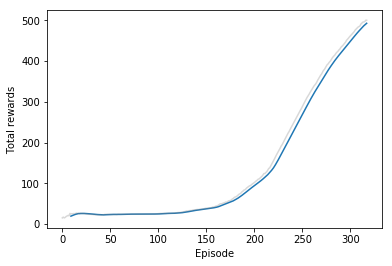

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

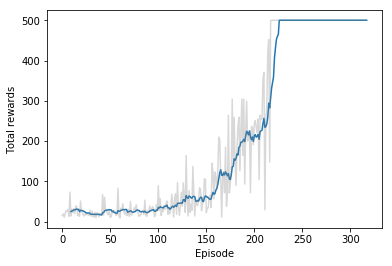

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

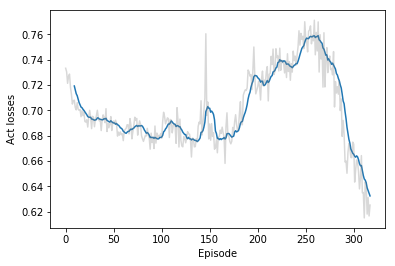

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

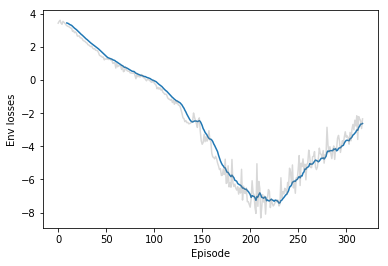

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

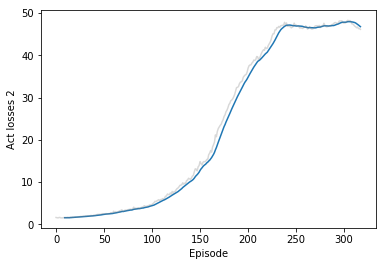

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
